In [1]:
import pandas as pd
import scipy.stats as ss
import numpy as np
import matplotlib.pyplot as plt
import datetime
from matplotlib import dates
from scipy.optimize import curve_fit
from libs.date_handle import diff_dates

from IPython.display import clear_output

%config InlineBackend.figure_format = 'retina'

#### 0. Injestion ####

In [2]:
url = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv'

ti = pd.read_csv(url, index_col = 0)

In [3]:
ti = ti.reset_index()
ti.data = pd.to_datetime(ti.data).dt.date
ti = ti.set_index('data')

In [4]:
# try:
#     import get_data # script that automatically downloads data
# except:
#     import get_data # sometimes returns error for no reason so i'll just run it two times

In [5]:
ti = pd.read_csv('italia-terapie-intensive.csv', sep = ';', index_col = 0)

In [6]:
max_ti = ti[ti.terapia_intensiva == max(ti.terapia_intensiva)].terapia_intensiva[0]
max_ric = ti[ti.ospedalizzati == max(ti.ospedalizzati)].ospedalizzati[0]

In [7]:
hists = ['diff_ricoverati', 'diff_terapia_intensiva', 'diff_ospedalizzati', 'nuovi_positivi', 'diff_deceduti', 'diff_tamponi']

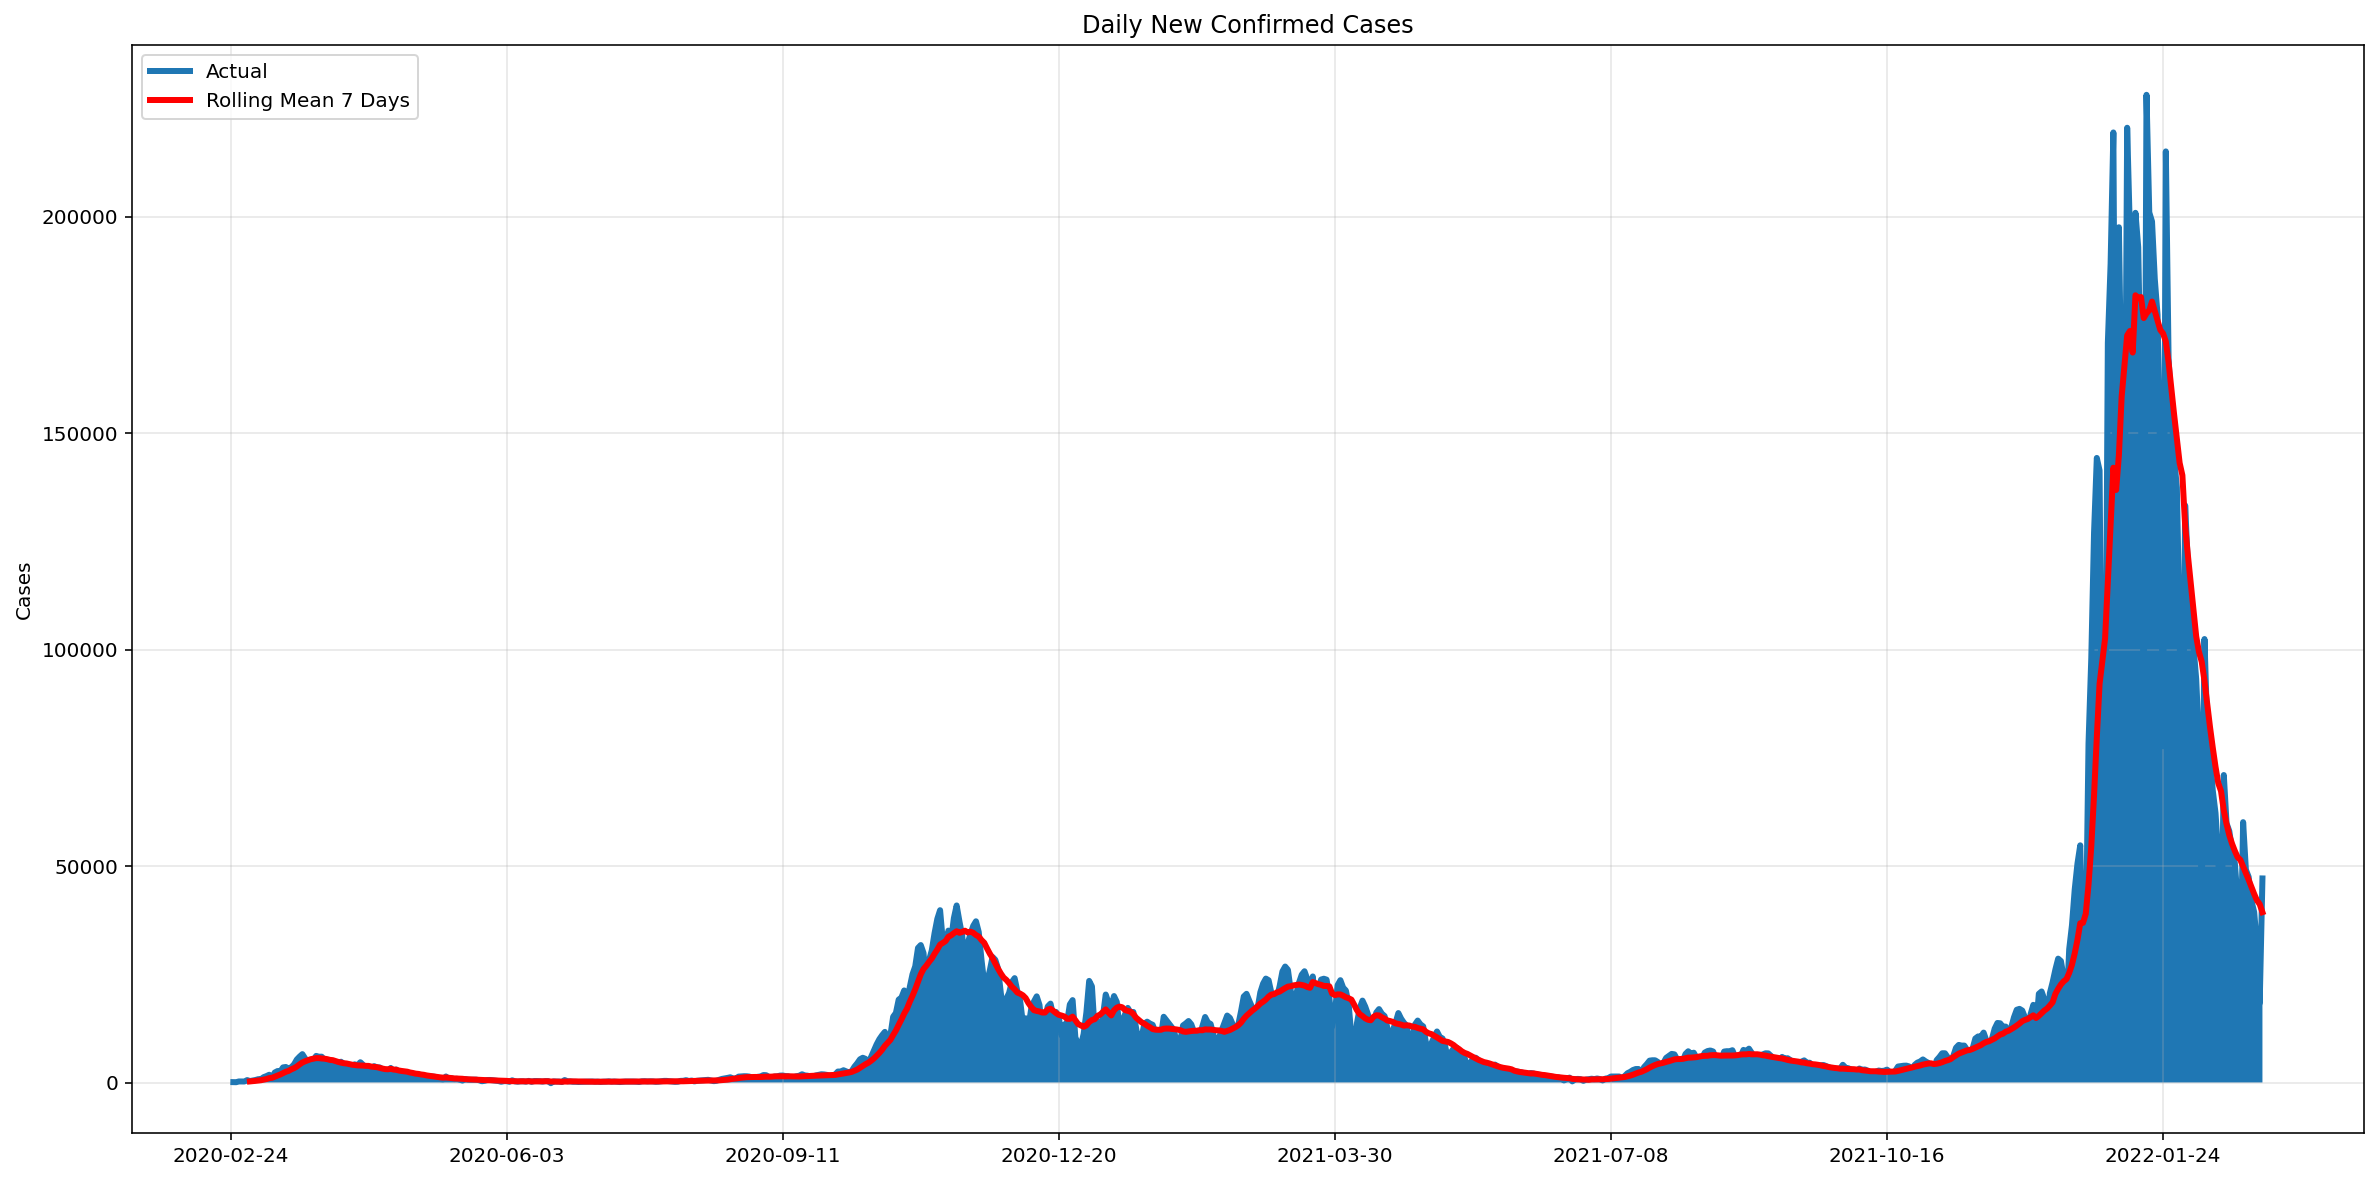

In [8]:
fig, ax = plt.subplots(figsize=(20,10))

ti.totale_casi.diff().plot(ax=ax, linewidth = 3, label = 'Actual')
ti.totale_casi.diff().rolling(7).mean().plot(ax=ax, c = 'r', linewidth = 3, label = 'Rolling Mean 7 Days')
_ = ax.fill_between(ti.totale_casi.diff().index, ti.totale_casi.diff())
_ = ax.legend()
_ = ax.grid(alpha=.3)
_ = ax.set_xlabel('')
_ = ax.set_ylabel('Cases')
_ = ax.set_title('Daily New Confirmed Cases')

#### Note: first wave infection data are highly untrustable due to poor testing procedure #####

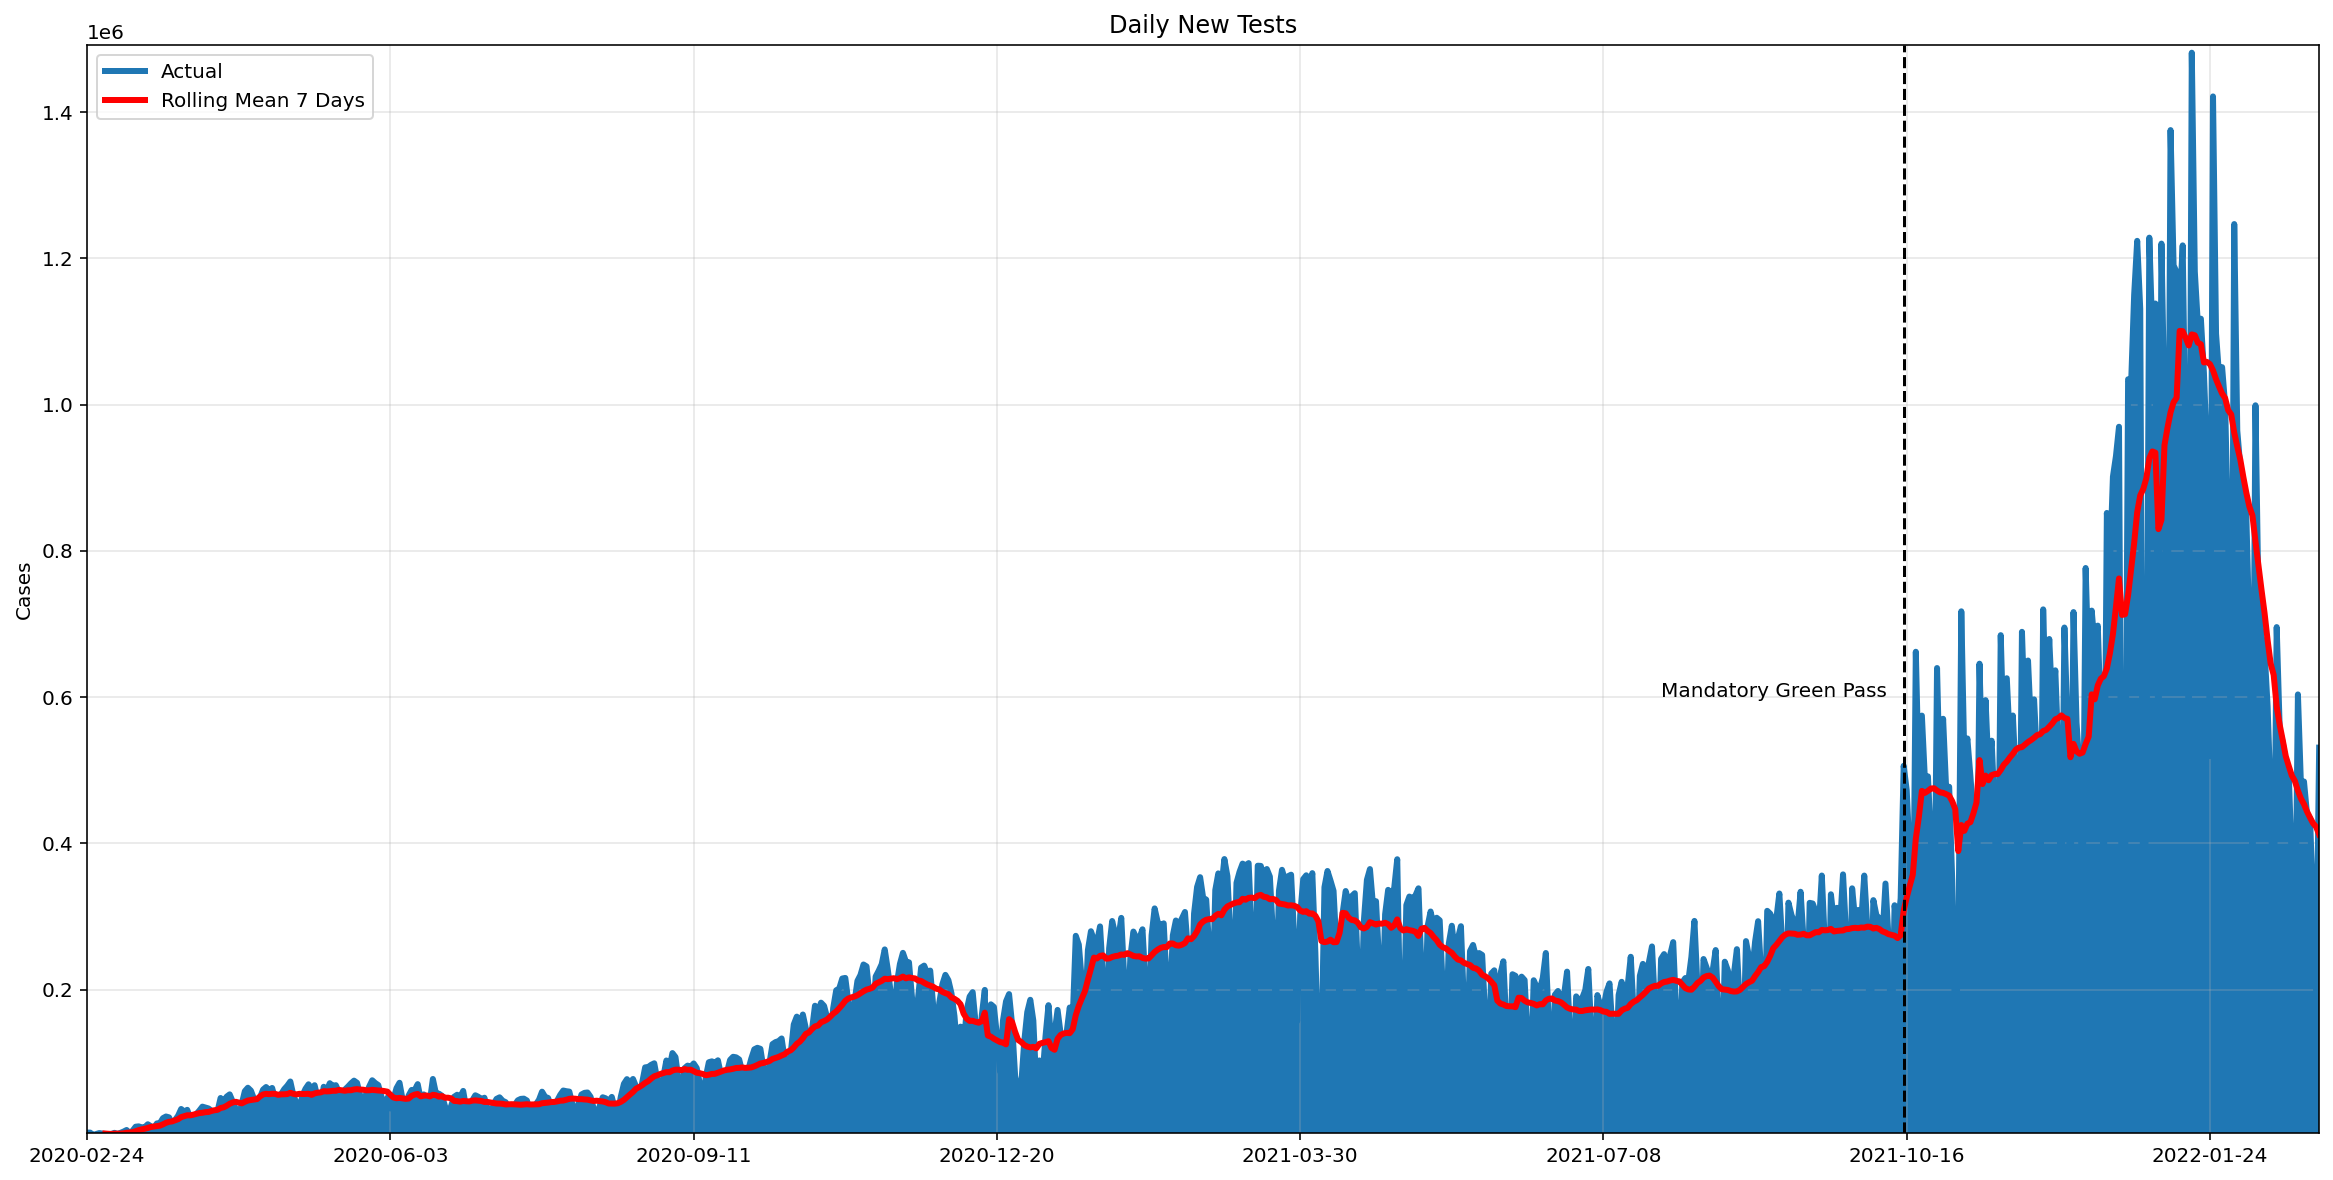

In [12]:
fig, ax = plt.subplots(figsize=(20,10))

mand_gp = (pd.to_datetime('2021-10-15') - pd.to_datetime(ti.index[0])).days

ti.diff_tamponi.plot(ax=ax, linewidth = 3, label = 'Actual')
ti.diff_tamponi.rolling(7).mean().plot(ax=ax, c = 'r', linewidth = 3, label = 'Rolling Mean 7 Days')
_ = ax.fill_between(ti.diff_tamponi.index, ti.diff_tamponi)
_ = ax.legend()
_ = ax.grid(alpha=.3)
_ = ax.axvline(mand_gp, c = 'k', linestyle = '--')
_ = ax.text(mand_gp - 80, 600000, 'Mandatory Green Pass')
_ = ax.set_xlabel('')
_ = ax.set_ylabel('Cases')
_ = ax.set_title('Daily New Tests')
_ = ax.set_xlim(ti.diff_tamponi.index[0], ti.diff_tamponi.index[-1])
_ = ax.set_ylim(ti.diff_tamponi[0], ti.diff_tamponi.max() + 10000)
fig.savefig('Daily_tests.png')

#### 1. EDA ####

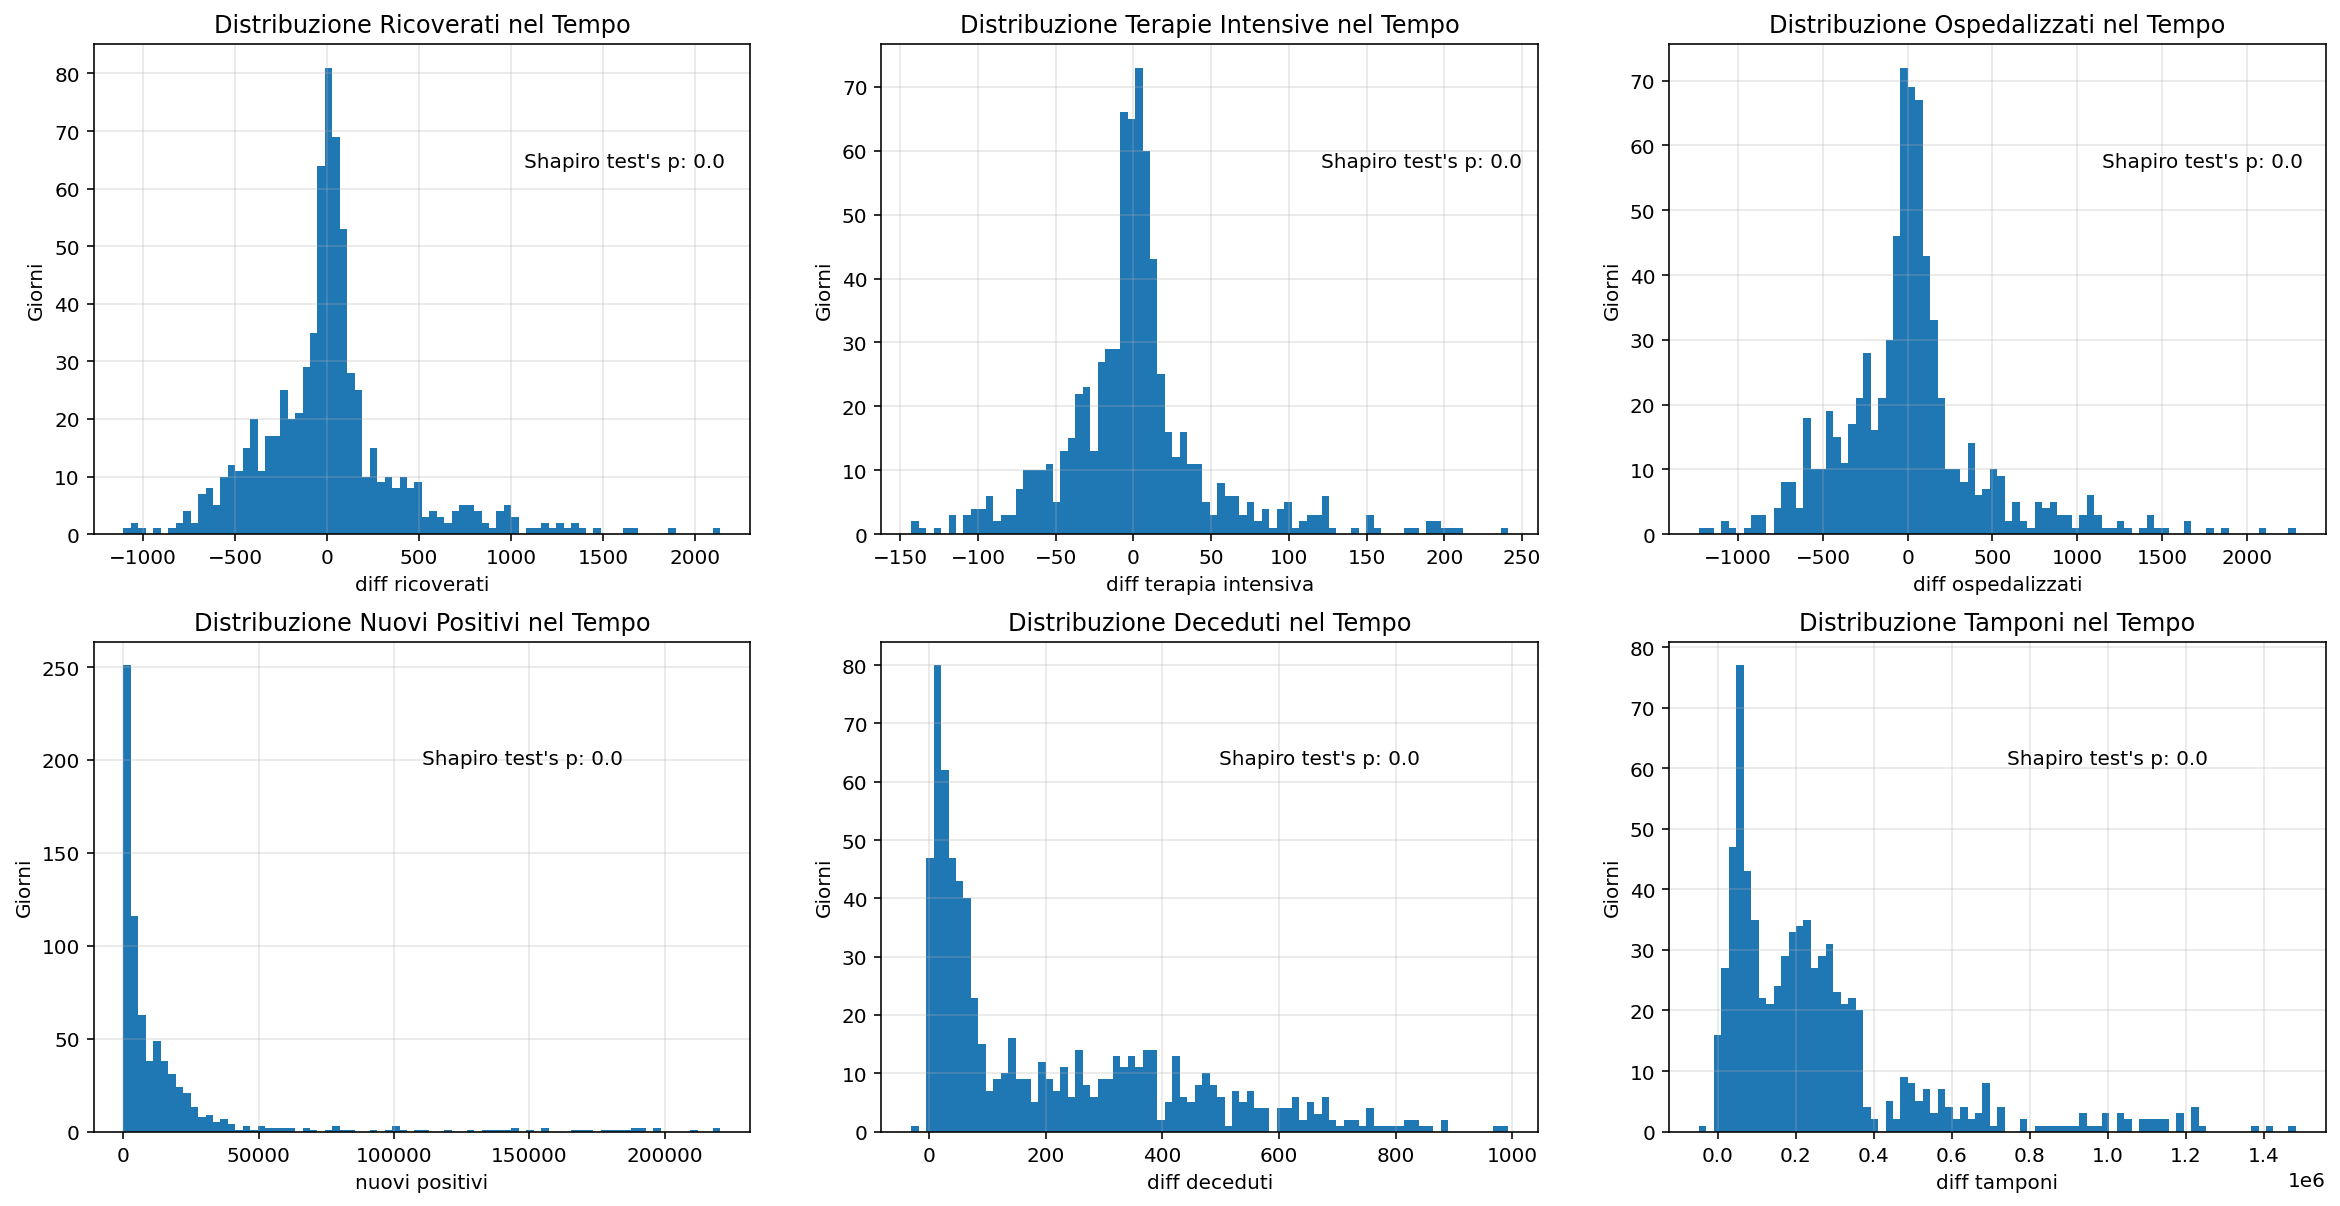

In [13]:
titles = ['Ricoverati', 'Terapie Intensive', 'Ospedalizzati', 'Nuovi Positivi', 'Deceduti', 'Tamponi']
fig, ax = plt.subplots(2,3, figsize=(20,10))

flax = ax.flatten()
for n, to_plot in enumerate(hists):
    _, p = ss.shapiro(ti[to_plot])
    ti[to_plot].hist(ax = flax[n], bins = 80)
    ylim = flax[n].get_ylim()
    _ = flax[n].grid(alpha = .3)
    _ = flax[n].set_ylabel('Giorni')
    _ = flax[n].set_xlabel(to_plot.replace('_', ' '))
    _ = flax[n].set_title(f'Distribuzione {titles[n]} nel Tempo')
    _ = flax[n].text(ti[to_plot].max() - ti[to_plot].max() / 2, ylim[1] - ylim[1] / 4, f'Shapiro test\'s p: {round(p, 6)}')

_ = fig.subplots_adjust(hspace=.22)

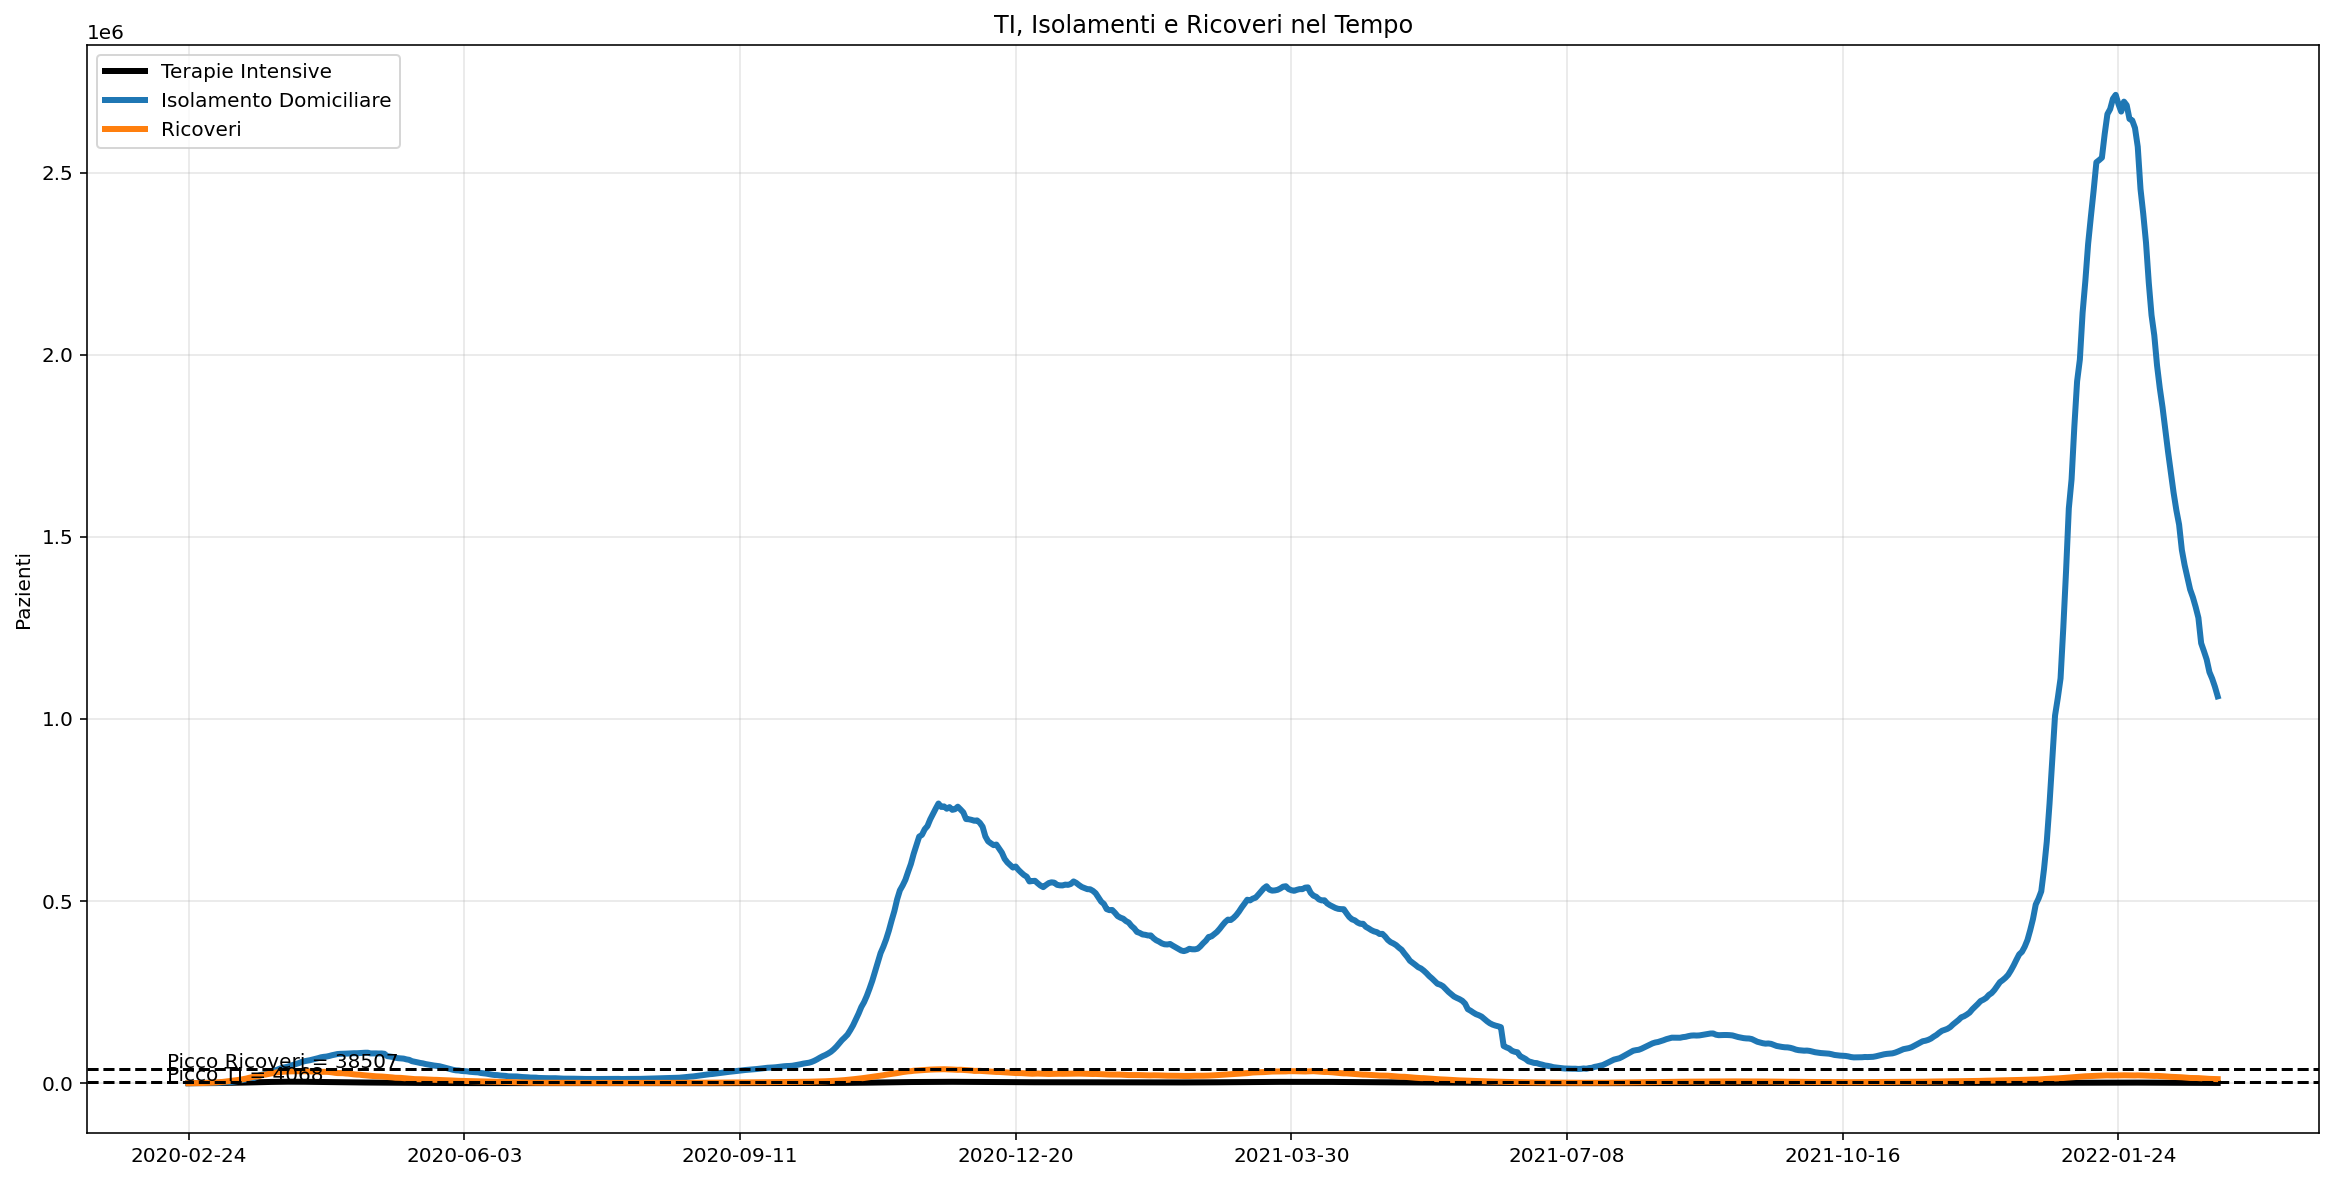

In [14]:
fig, ax = plt.subplots(figsize = (20,10))

ti.terapia_intensiva.plot(ax = ax, c = 'k', linewidth = 3, label = 'Terapie Intensive')
ti.isolamento_domiciliare.plot(ax = ax, linewidth = 3, label = 'Isolamento Domiciliare')
ti.ospedalizzati.plot(ax = ax, linewidth = 3, label = 'Ricoveri')
_ = ax.legend()
_ = ax.grid(alpha = .3)
_ = ax.set_ylabel('Pazienti')
_ = ax.set_xlabel('')
_ = ax.set_title('TI, Isolamenti e Ricoveri nel Tempo')
_ = ax.axhline(max(ti.terapia_intensiva), c = 'k', linestyle = '--')
_ = ax.axhline(max(ti.ospedalizzati), c = 'k', linestyle = '--')
_ = ax.text(-8, max_ti+2000, f'Picco TI = {max_ti}')
_ = ax.text(-8, max_ric+2000, f'Picco Ricoveri = {max_ric}')

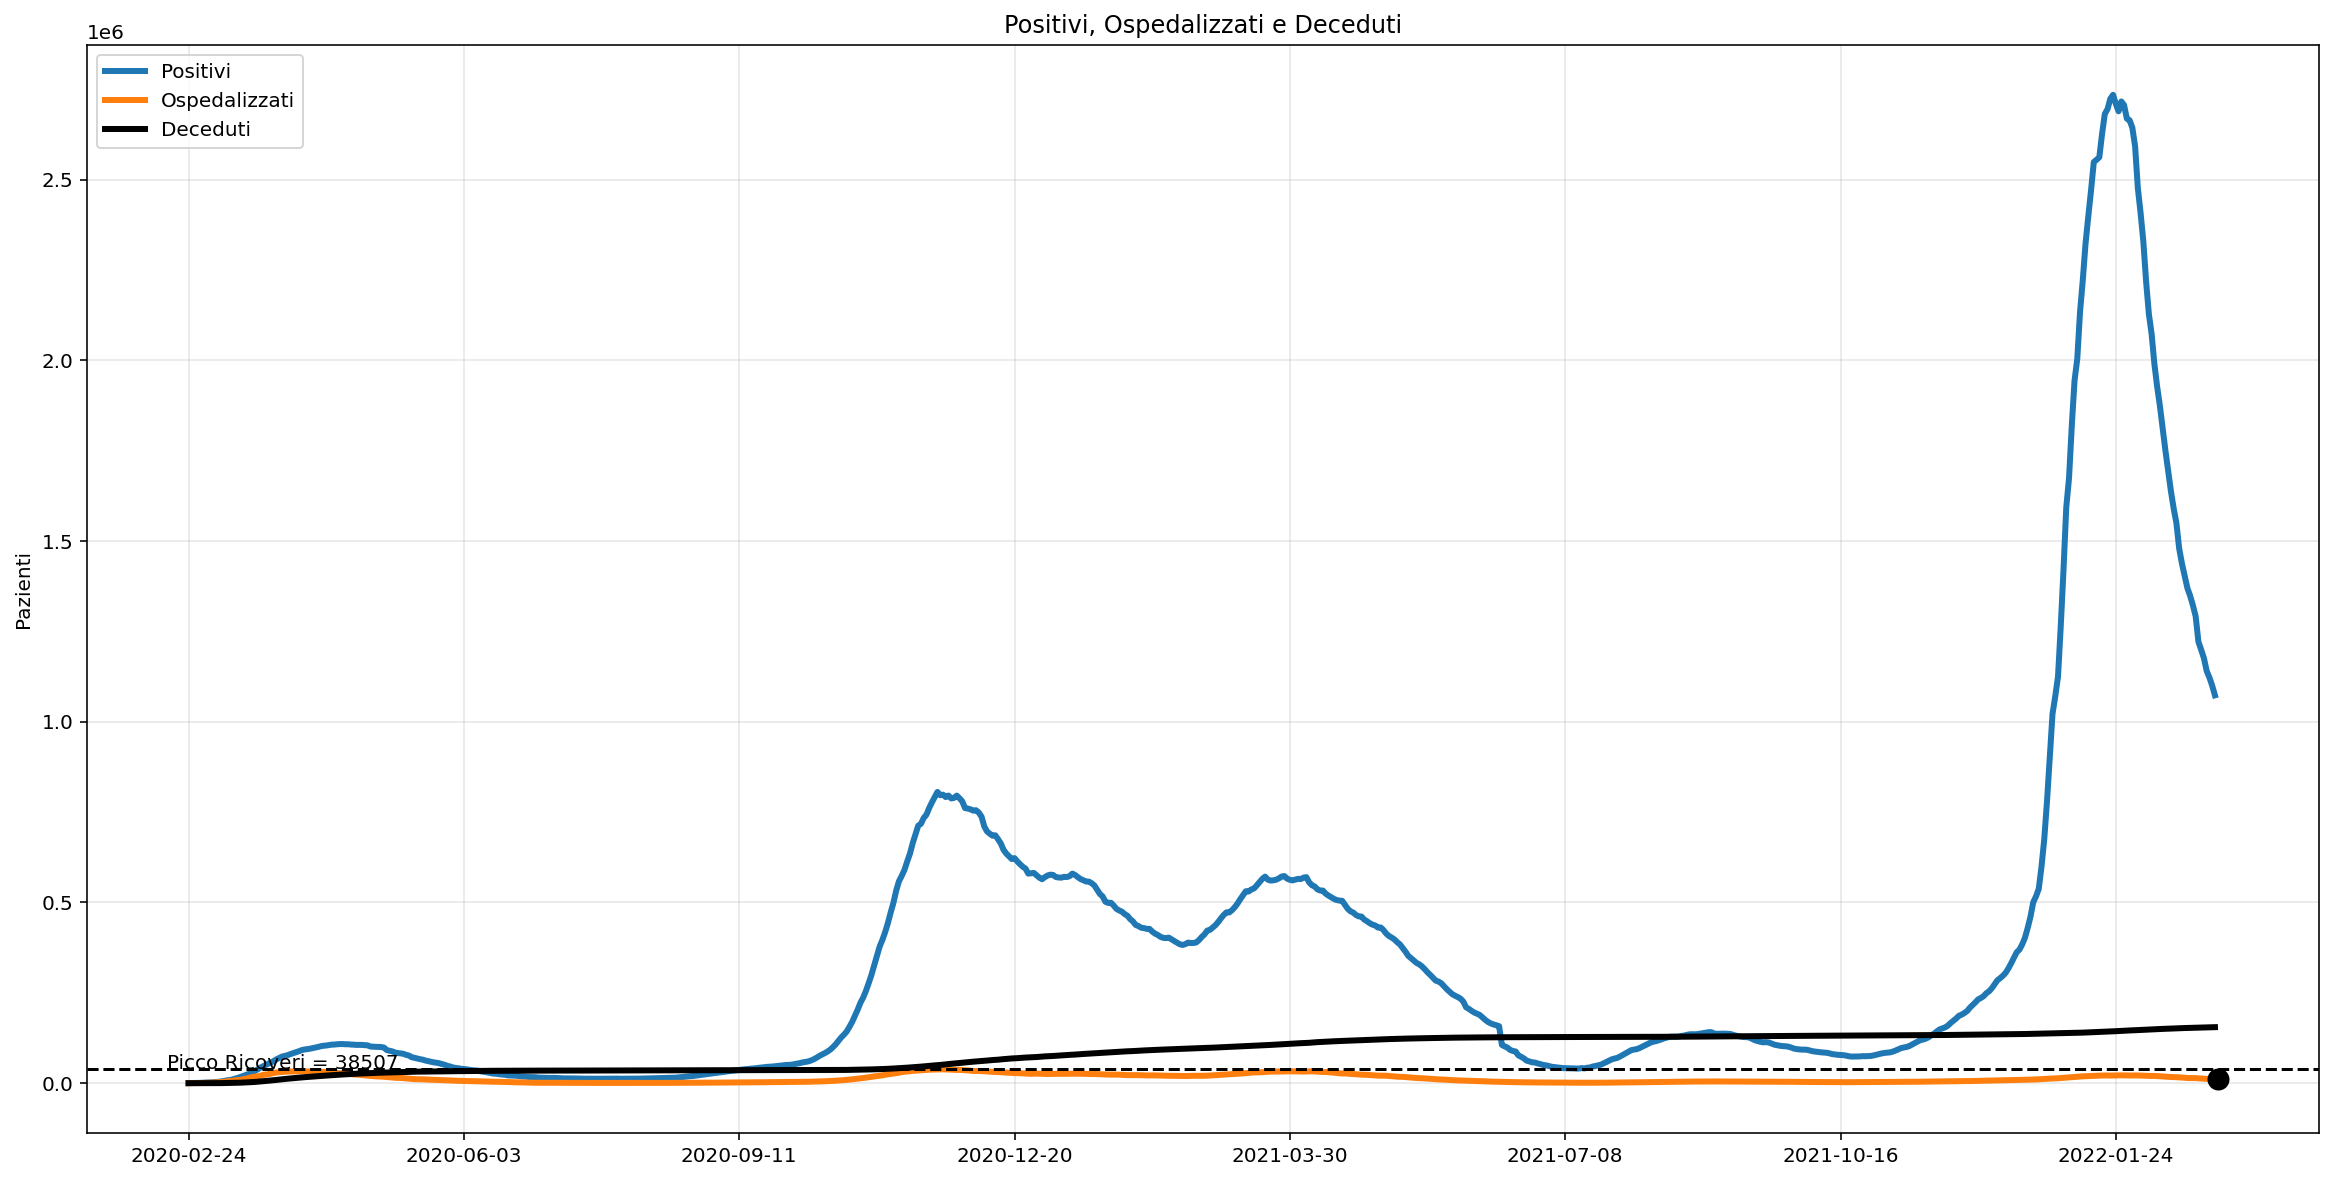

In [15]:
fig, ax = plt.subplots(figsize = (20,10))

ti.totale_positivi.plot(ax = ax, linewidth = 3, label = 'Positivi')
ti.ospedalizzati.plot(ax = ax, linewidth = 3, label = 'Ospedalizzati')
ti.deceduti.plot(ax = ax, c = 'k', linewidth = 3, label = 'Deceduti')
_ = ax.legend()
_ = ax.grid(alpha = .3)
_ = ax.set_ylabel('Pazienti')
_ = ax.set_xlabel('')
_ = ax.set_title('Positivi, Ospedalizzati e Deceduti')
_ = ax.axhline(max(ti.ospedalizzati), c = 'k', linestyle = '--')
_ = ax.scatter(len(ti.index), ti.ospedalizzati[-1], c = 'k', s = 100, zorder = 3)
_ = ax.text(-8, max_ric+2000, f'Picco Ricoveri = {max_ric}')

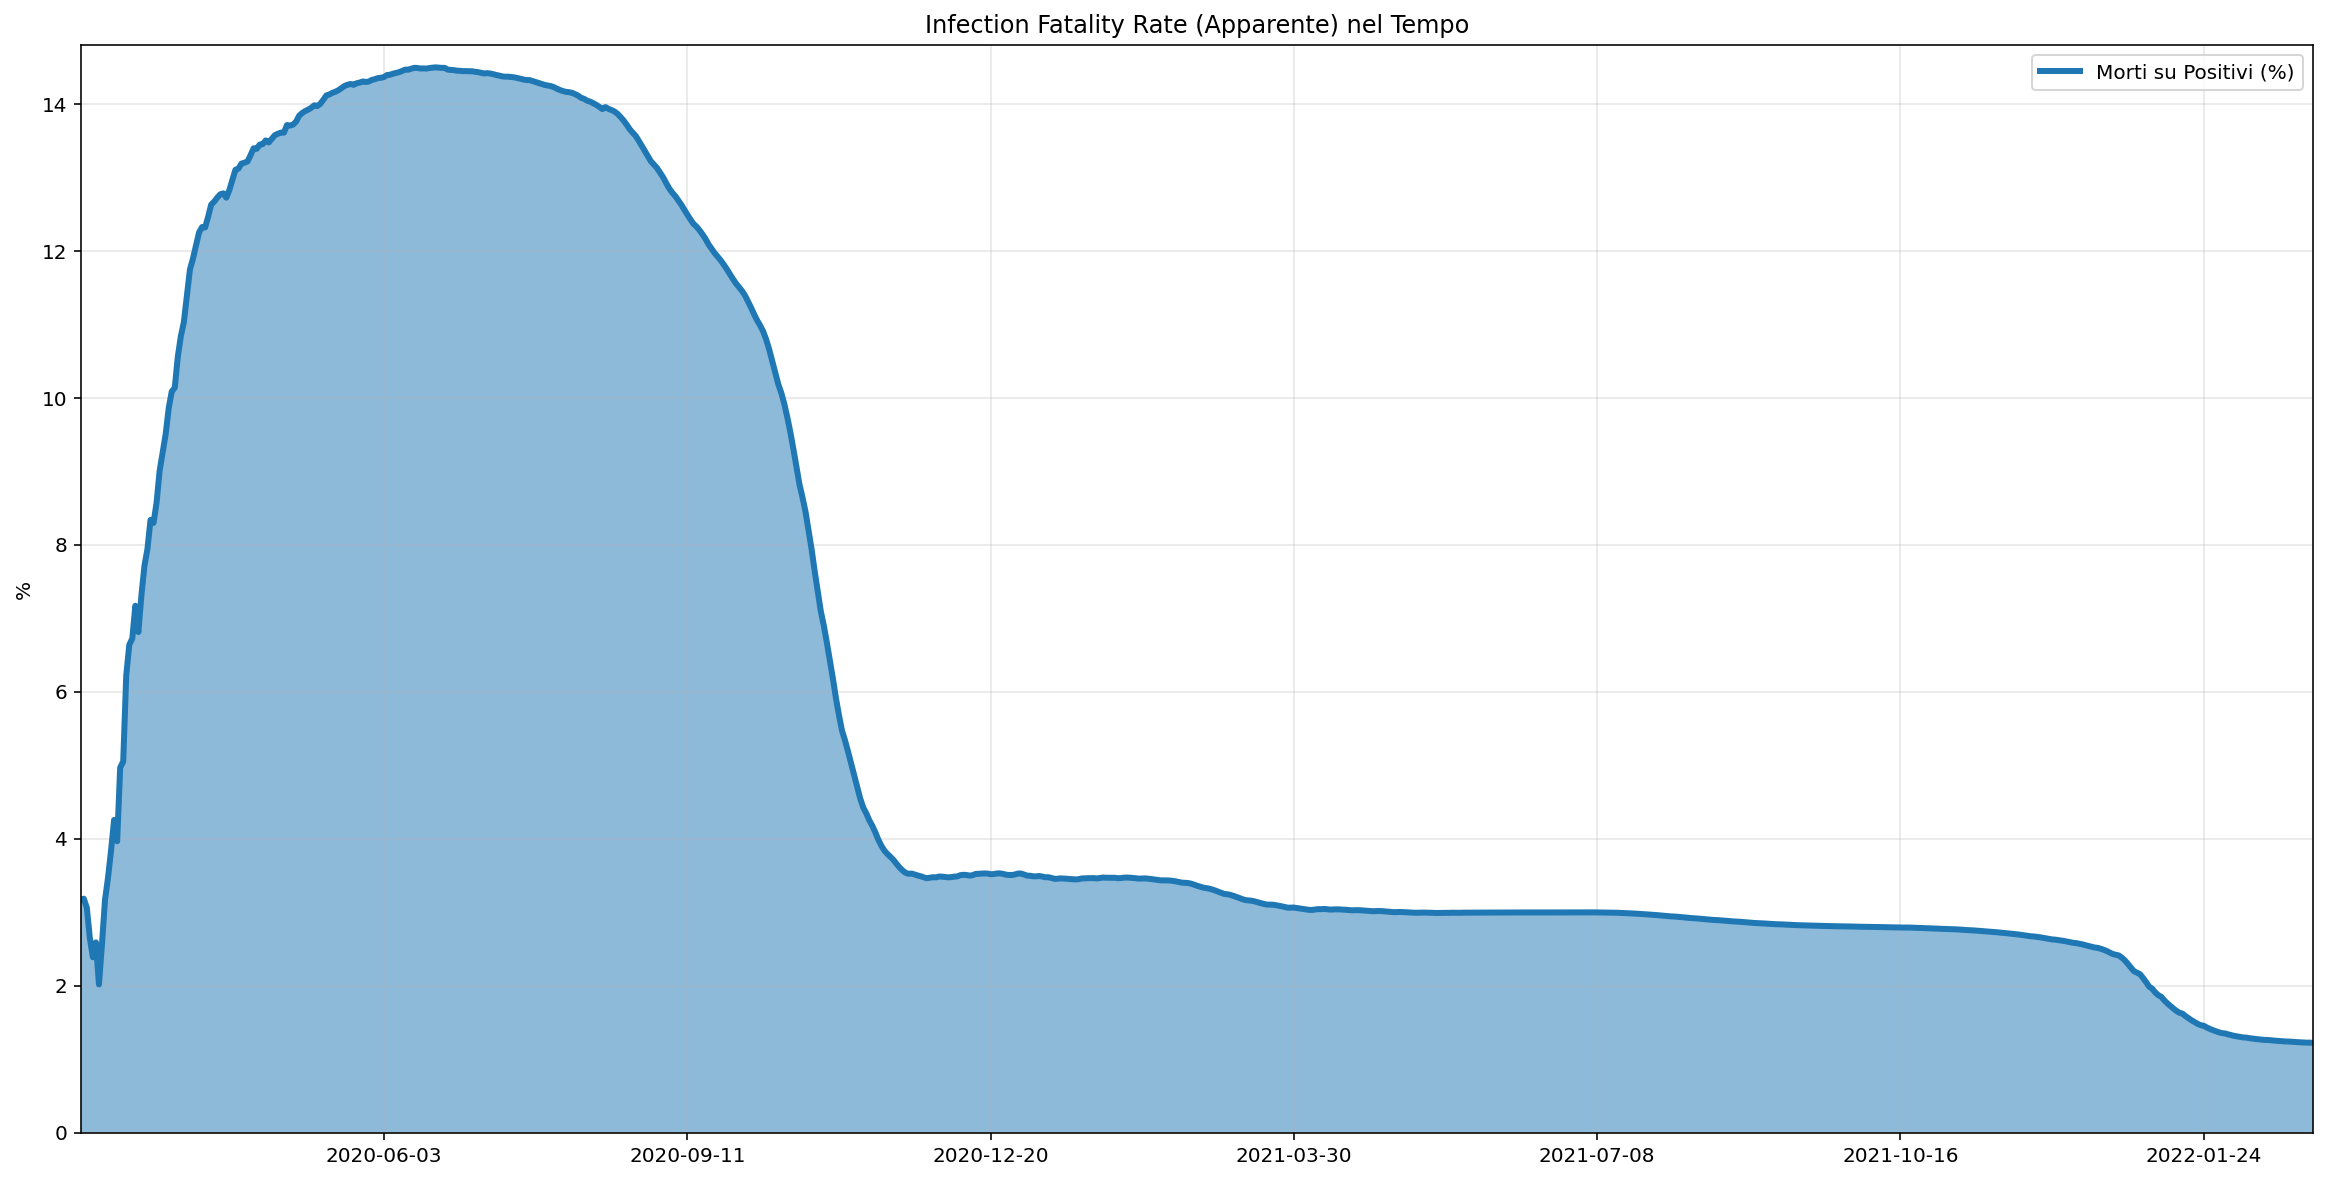

In [16]:
ti['Fatality'] = (ti.deceduti / np.cumsum(ti.nuovi_positivi)) * 100
# ti['ti_rate'] = (np.cumsum(ti.terapia_intensiva) / np.cumsum(ti.nuovi_positivi)) * 100

fig, ax = plt.subplots(figsize = (20,10))
ti.Fatality.plot(ax = ax, linewidth = 3, label = 'Morti su Positivi (%)')
_ = ax.fill_between(ti.Fatality.index, ti.Fatality, alpha = .5)
_ = ax.legend()
_ = ax.grid(alpha=.3)
_ = ax.set_xlabel('')
_ = ax.set_ylabel('%')
_ = ax.set_title('Infection Fatality Rate (Apparente) nel Tempo')
_ = ax.set_xlim(.05, (pd.to_datetime(ti.index[-1]) - pd.to_datetime(ti.index[0])).days)
_ = ax.set_ylim(0, 14.8)

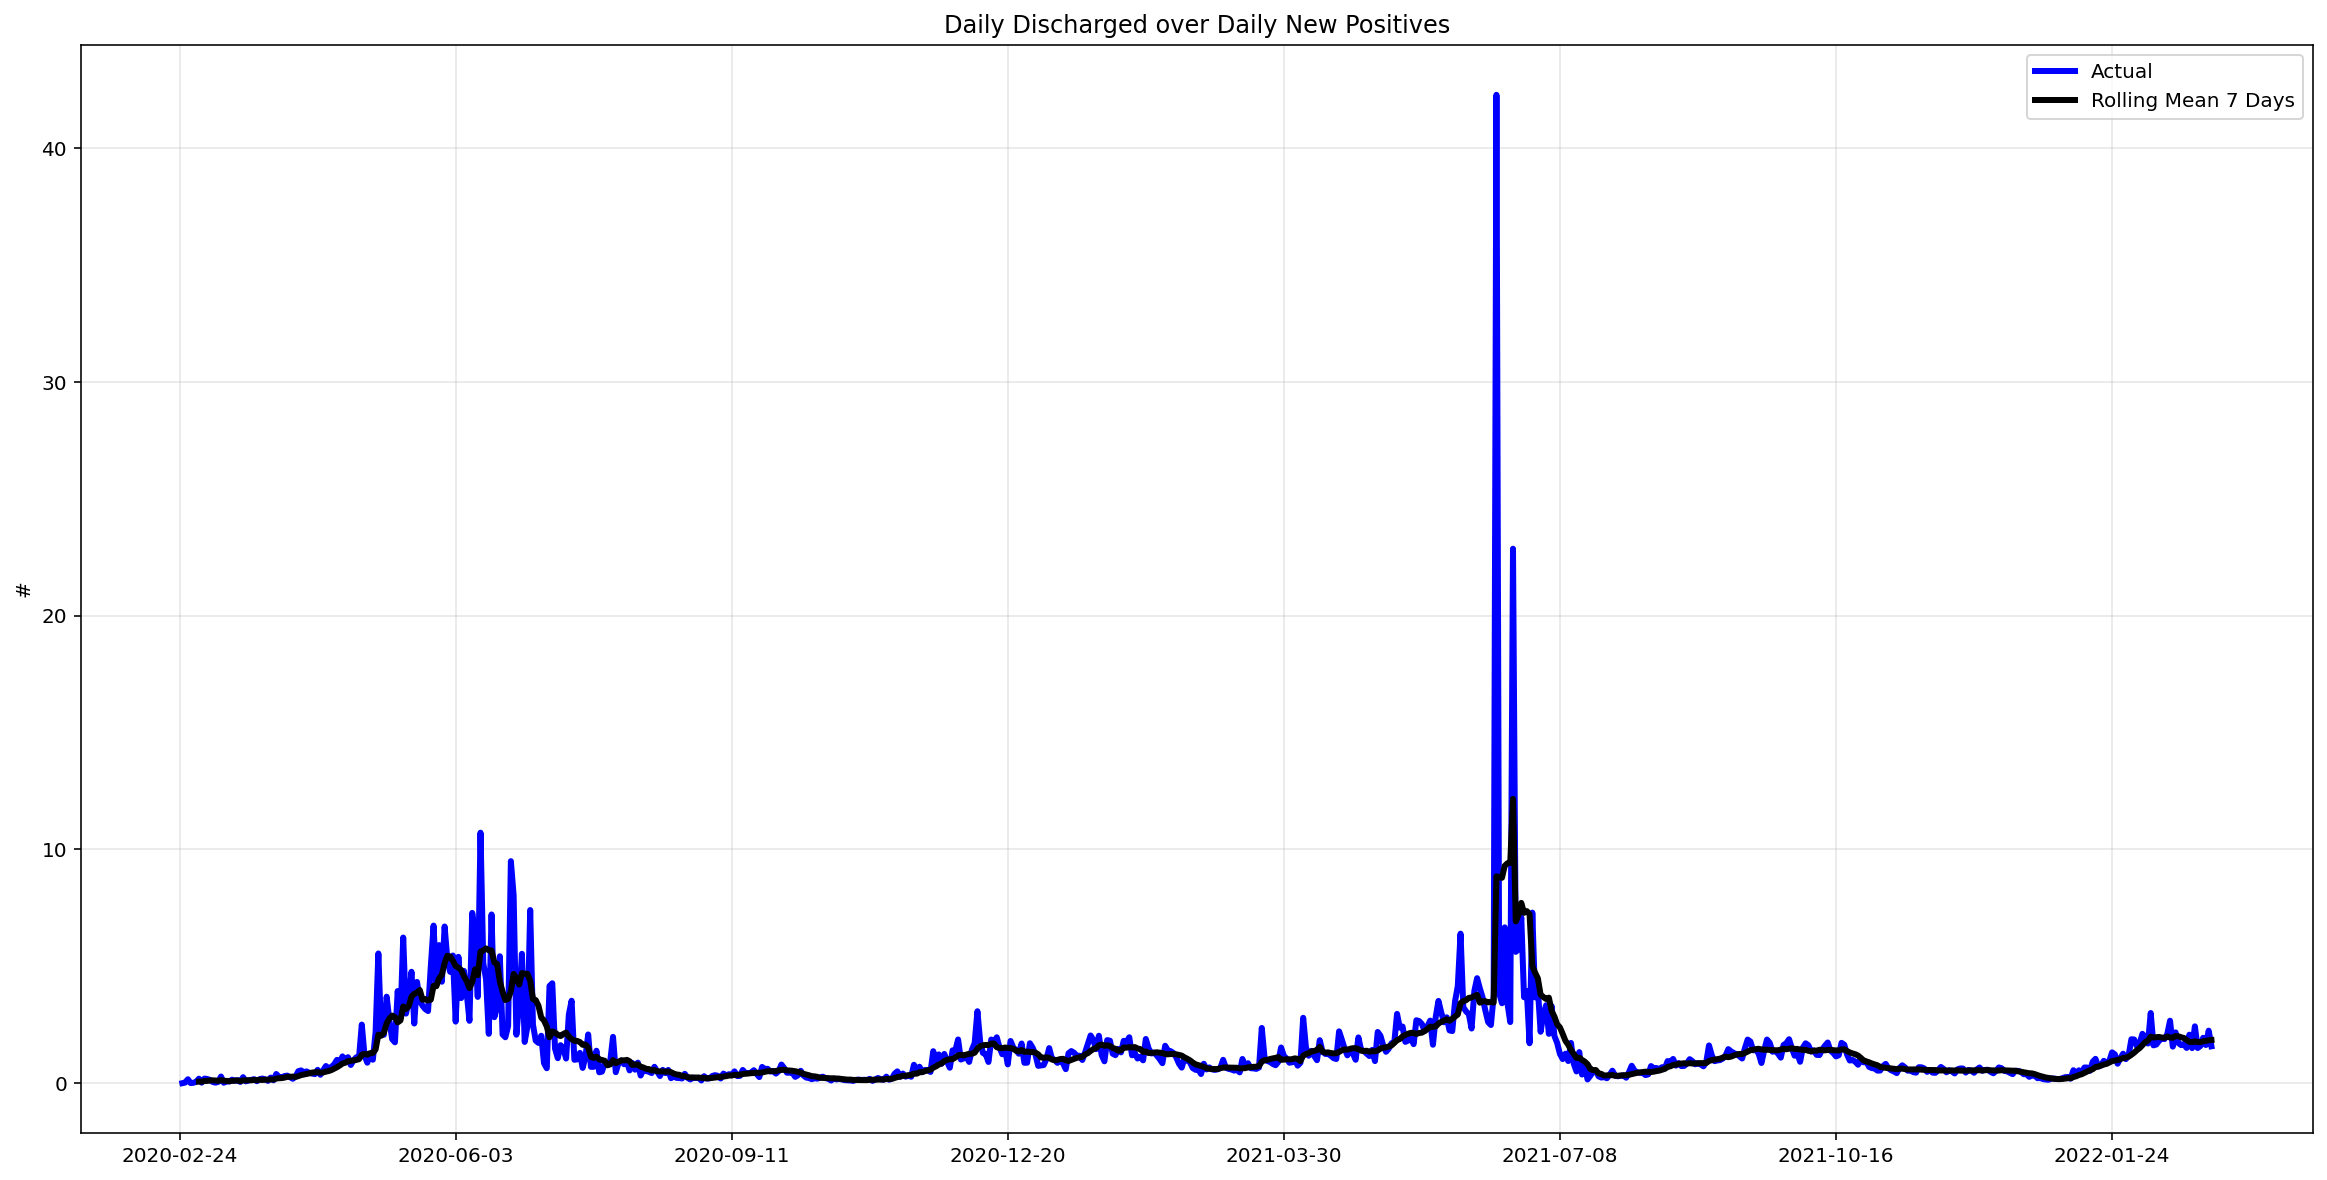

In [17]:
ti['g_over_p'] = (ti.guariti.diff() / ti.nuovi_positivi)# * 100

fig, ax = plt.subplots(figsize = (20,10))

ti.g_over_p.plot(ax = ax, linewidth = 3, label = 'Actual', c = 'b')
ti.g_over_p.rolling(7).mean().plot(ax = ax, linewidth = 3, label = 'Rolling Mean 7 Days', c = 'k')
_ = ax.grid(alpha = .3)
_ = ax.legend()
_ = ax.set_xlabel('')
_ = ax.set_ylabel('#')
_ = ax.set_title('Daily Discharged over Daily New Positives')

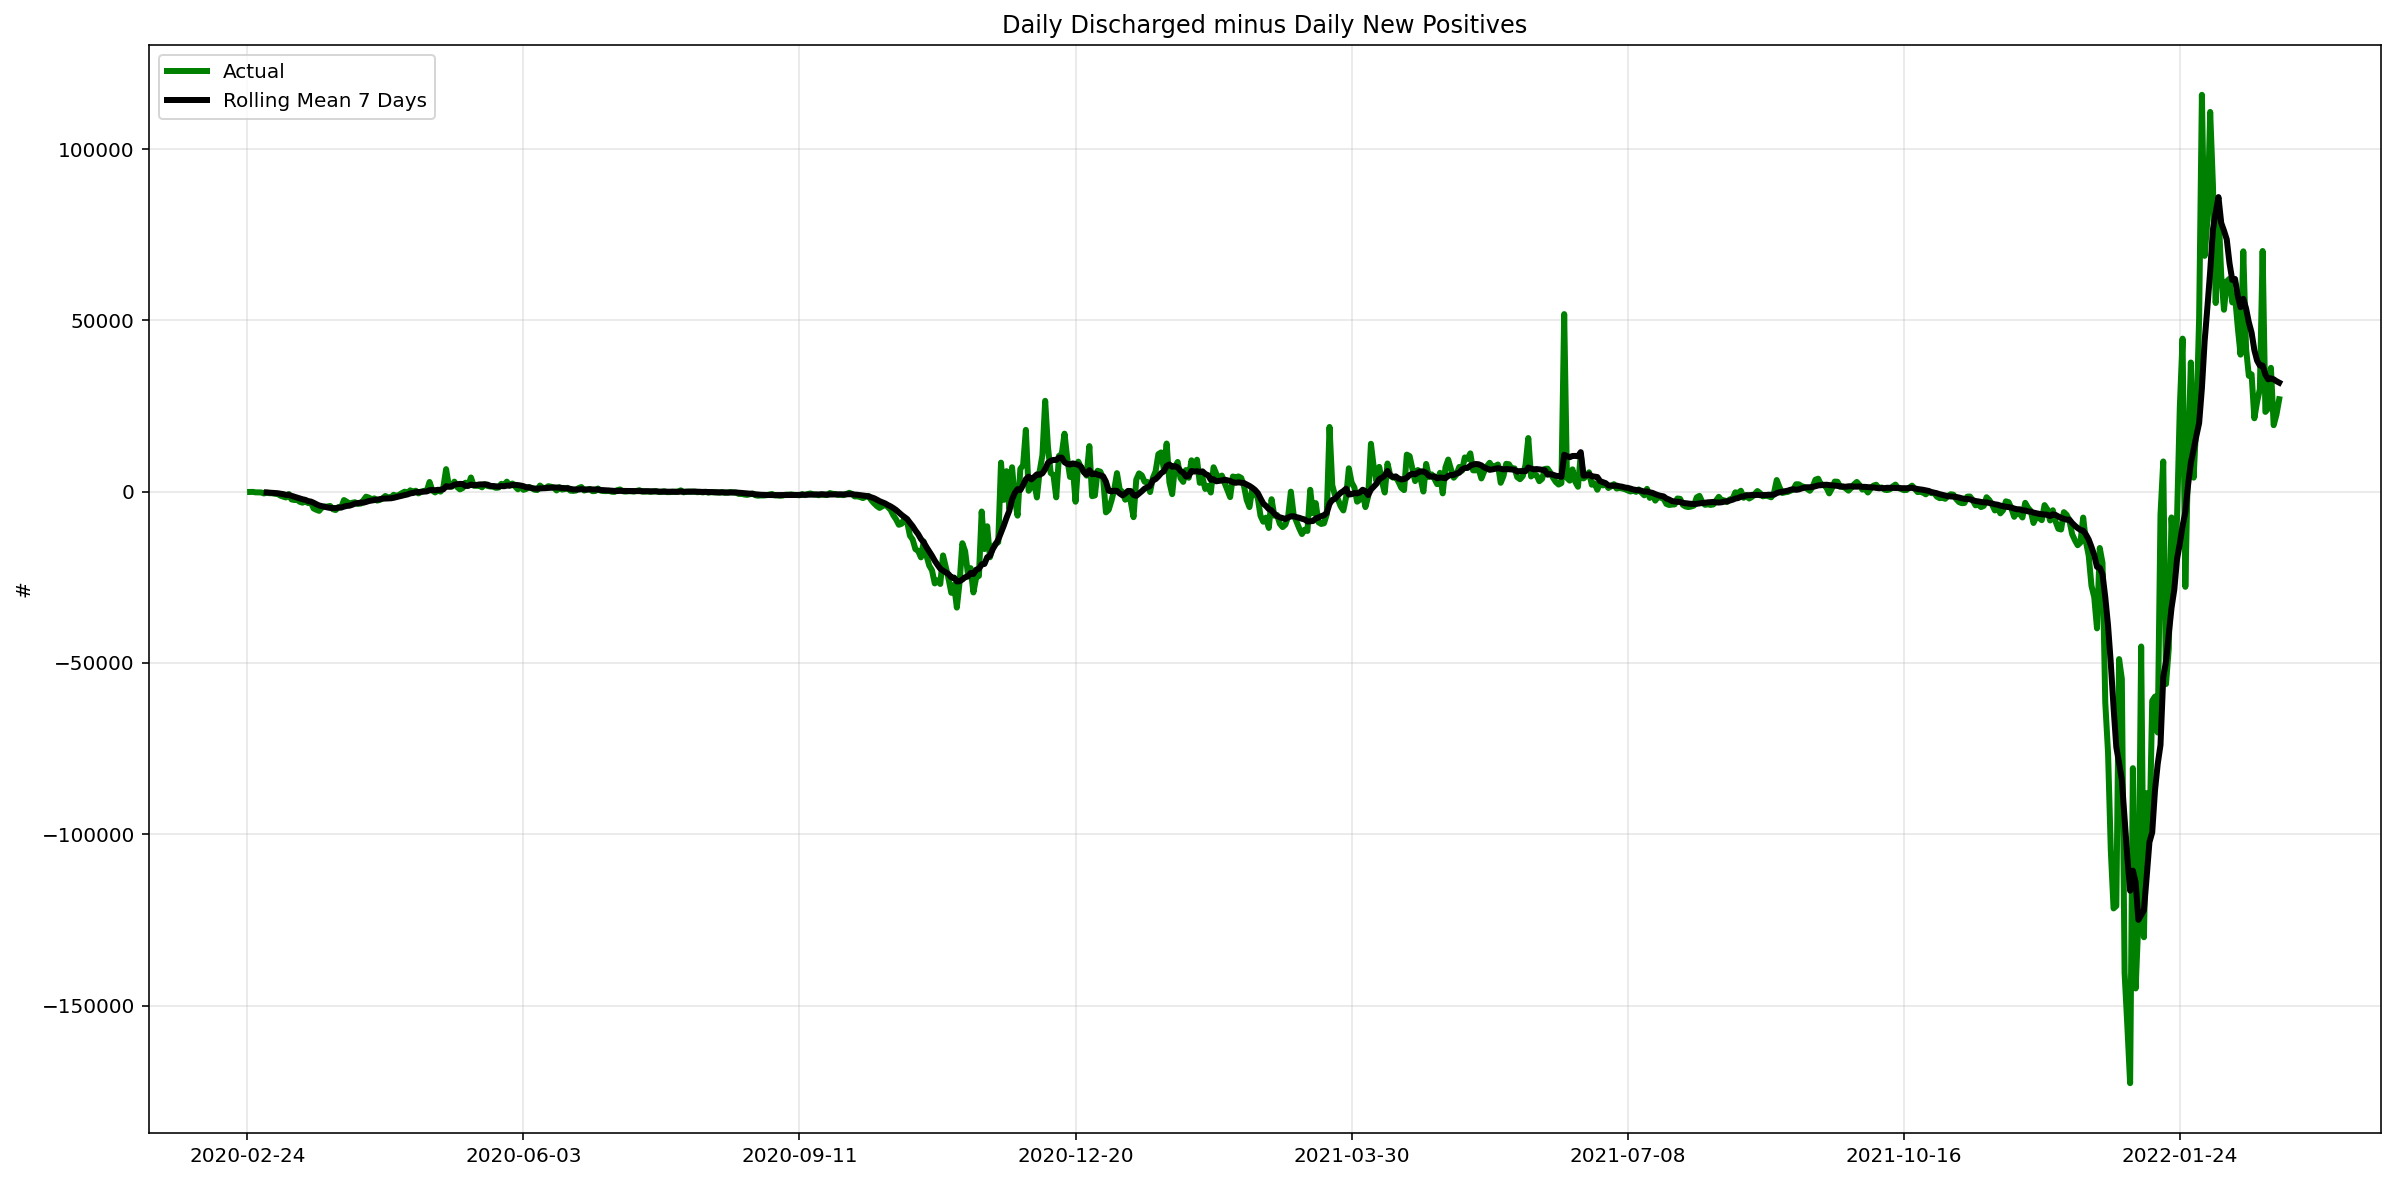

In [18]:
ti['g_minus_p'] = (ti.guariti.diff() - ti.nuovi_positivi)# * 100

fig, ax = plt.subplots(figsize = (20,10))

ti.g_minus_p.plot(ax = ax, linewidth = 3, label = 'Actual', c = 'g')
ti.g_minus_p.rolling(7).mean().plot(ax = ax, linewidth = 3, label = 'Rolling Mean 7 Days', c = 'k')
_ = ax.grid(alpha = .3)
_ = ax.legend()
_ = ax.set_xlabel('')
_ = ax.set_ylabel('#')
_ = ax.set_title('Daily Discharged minus Daily New Positives')

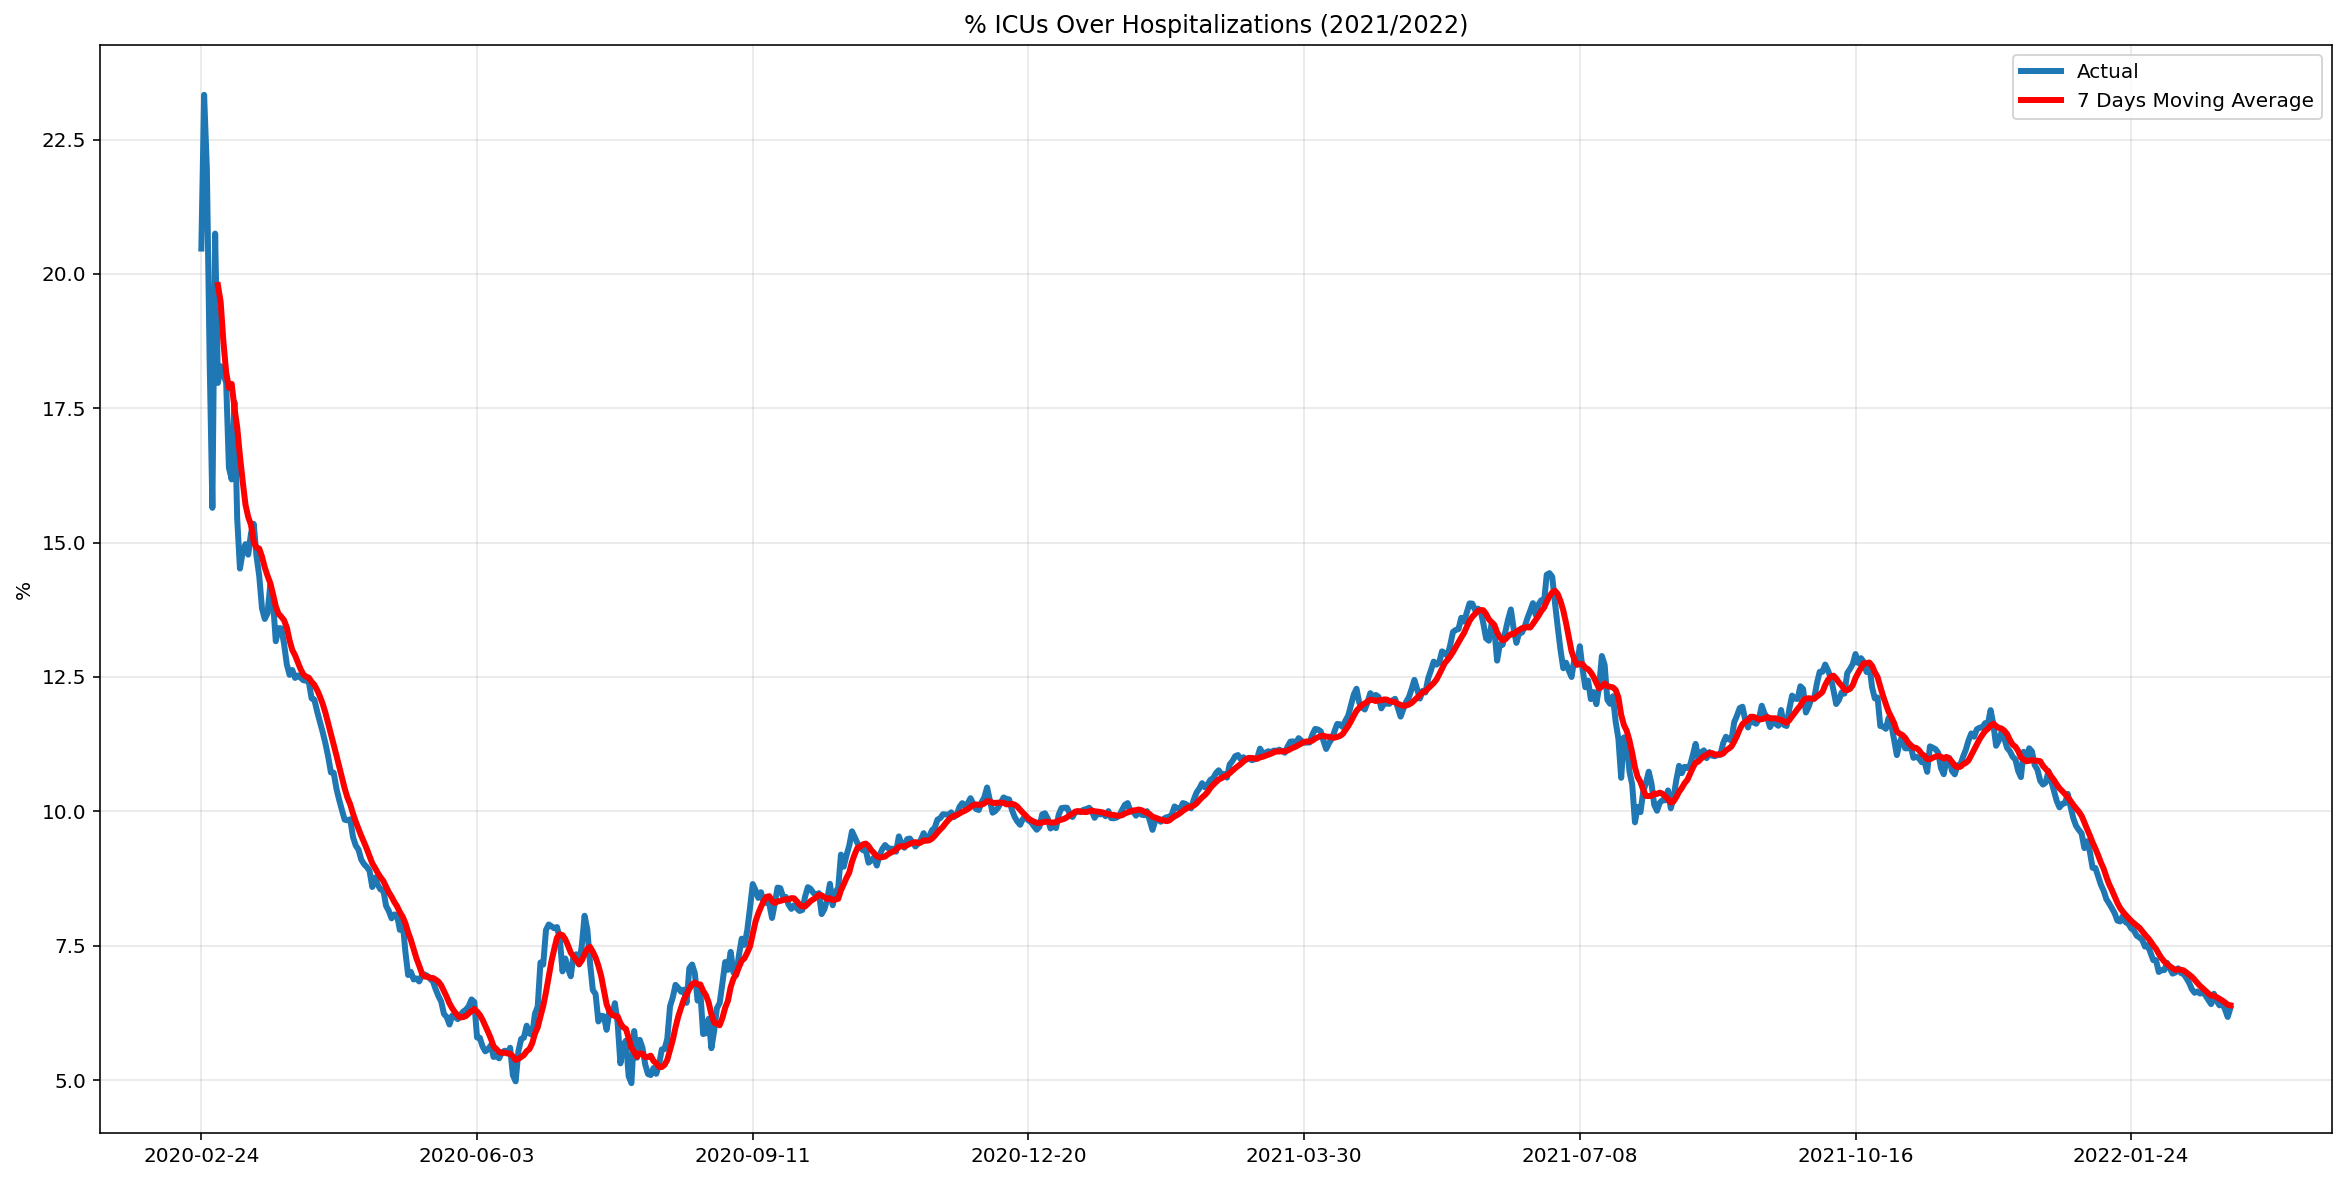

In [20]:
ti['ti_osp'] = (ti.terapia_intensiva / ti.ospedalizzati) * 100
flim = ti.reset_index().query("data=='2021-01-30'").index[0]
fend = ti.reset_index()['ti_osp'].index[-1]

fig, ax = plt.subplots(figsize = (20,10))

ti.ti_osp.plot(ax = ax, linewidth = 3, label = 'Actual')
ti.ti_osp.rolling(7).mean().plot(ax = ax, linewidth = 3, c = 'r', label = '7 Days Moving Average')
_ = ax.legend()
_ = ax.grid(alpha=.3)
_ = ax.set_xlabel('')
_ = ax.set_ylabel('%')
_ = ax.set_title('% ICUs Over Hospitalizations (2021/2022)')
# _ = ax.set_xlim(flim, fend)

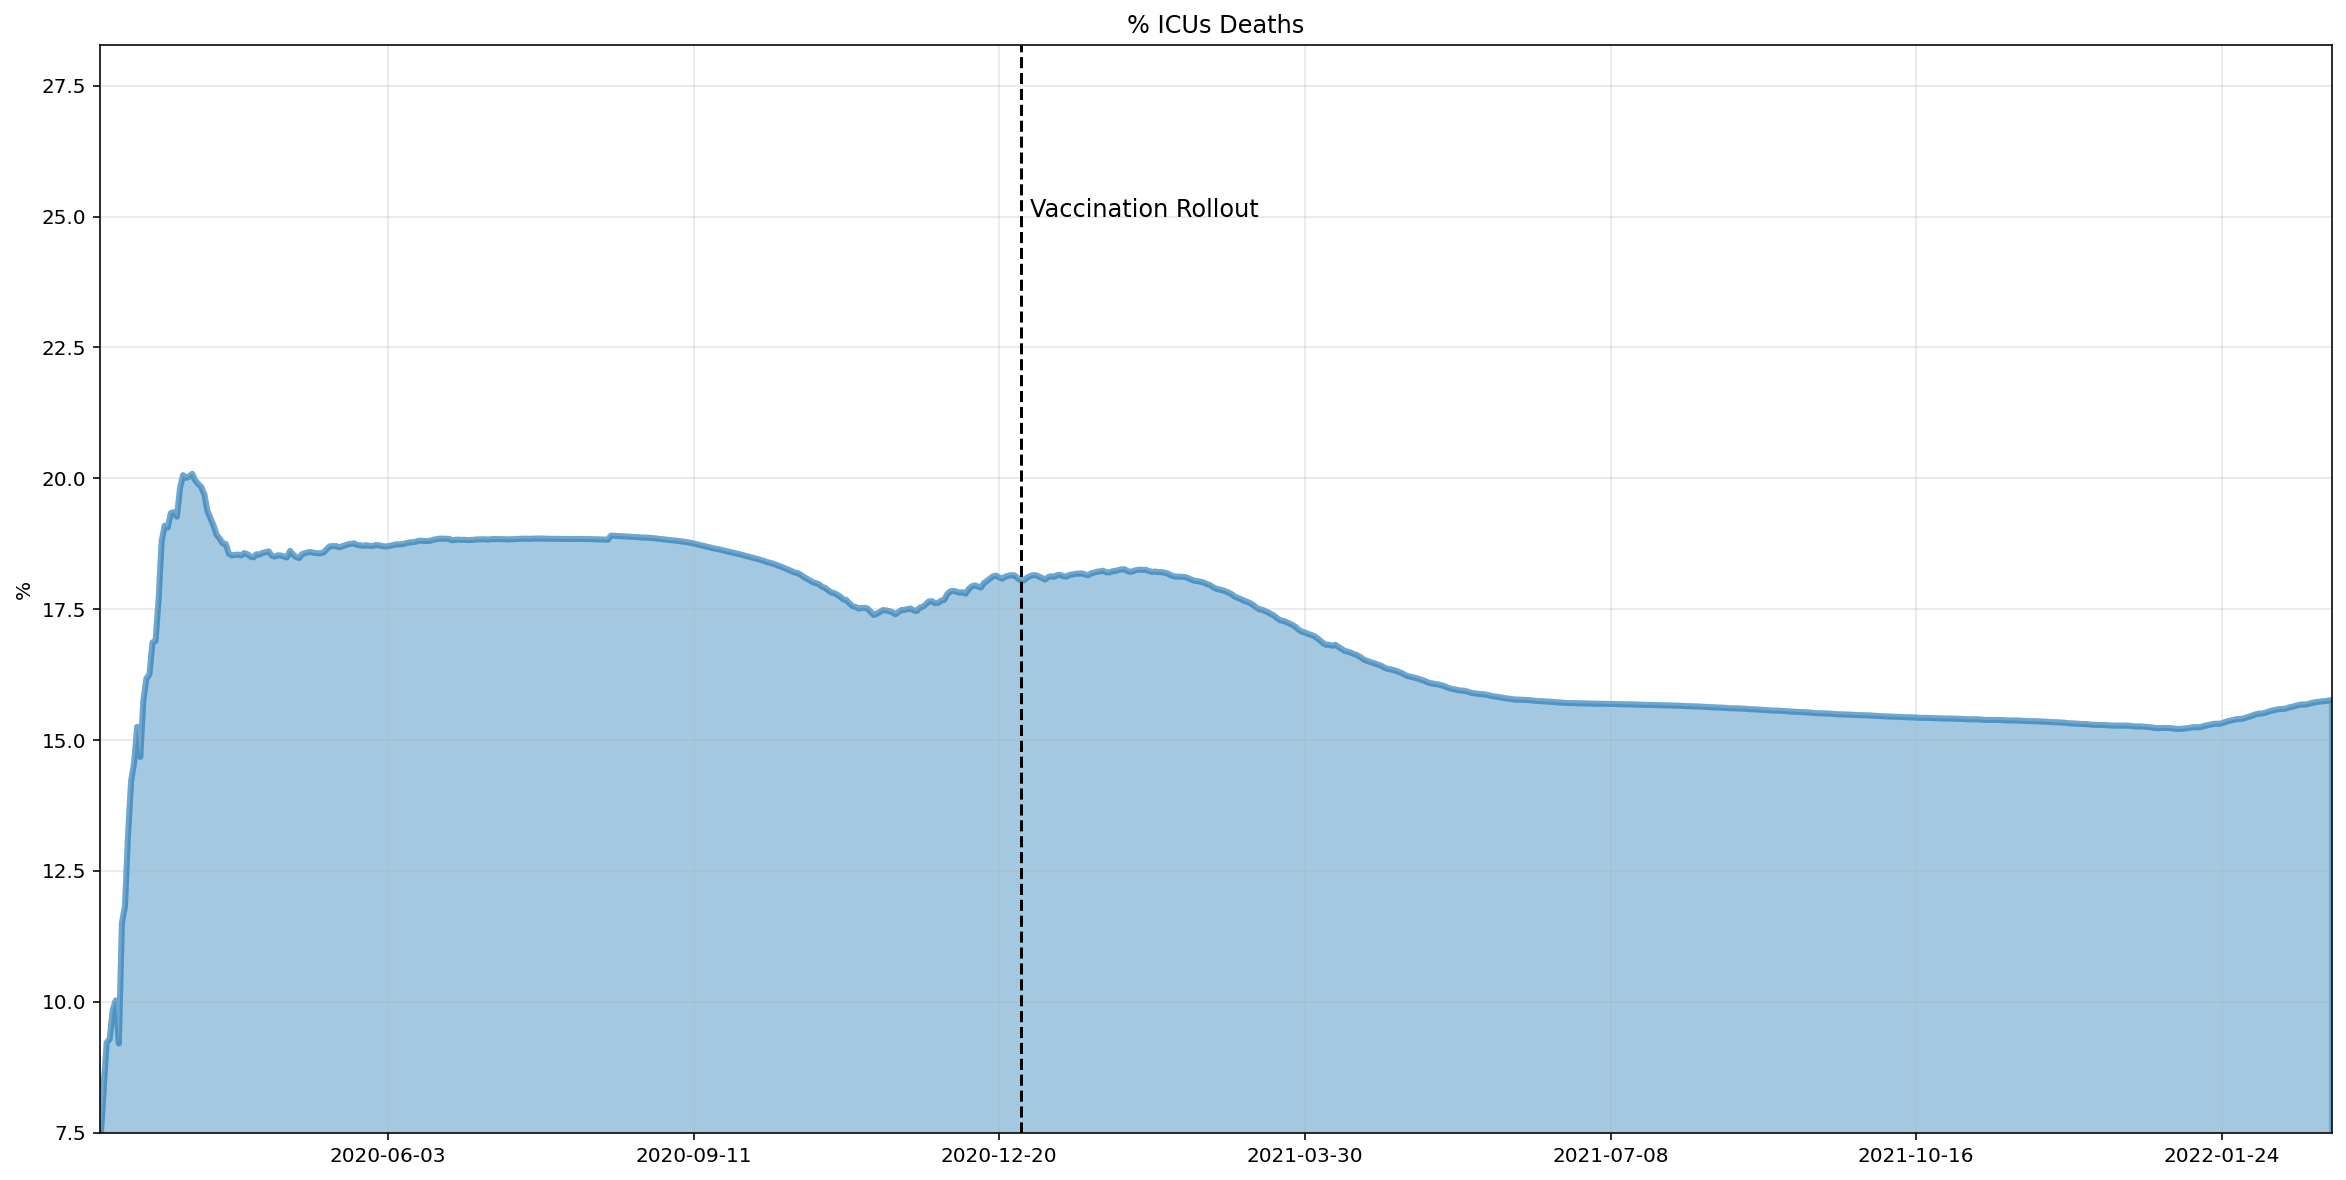

In [21]:
ti['ti_dec_ti'] = (ti.deceduti / ti.terapia_intensiva.cumsum()) * 100

vaccine_start = (pd.to_datetime('2020-12-27') - pd.to_datetime(ti.index[0])).days
trentaM = (pd.to_datetime('2021-07-26') - pd.to_datetime(ti.index[0])).days
ventiM = (pd.to_datetime('2021-05-22') - pd.to_datetime(ti.index[0])).days
fig, ax = plt.subplots(figsize = (20,10))

ti.ti_dec_ti.plot.area(ax = ax, linewidth = 3, alpha = 0.4, legend = False)
_ = ax.grid(alpha=.3)
_ = ax.set_xlabel('')
_ = ax.set_ylabel('%')
_ = ax.set_title('% ICUs Deaths')
_ = ax.set_xlim(5.8, (pd.to_datetime(ti.index[-1]) - pd.to_datetime(ti.index[0])).days)
_ = ax.axvline(vaccine_start, c = 'k', linestyle = '--')
_ = ax.text(vaccine_start+3, 25, 'Vaccination Rollout', fontsize = 12)
_ = ax.set_ylim(7.5)

The protection of the elderly starts to show his effects: few months after the start of the vaccination campaigne, the IC death rate started to decrease, with a 15% drop. The hope is to see a greater decrease after the total vaccination of all people with an age greater than 60 yo.

In [22]:
ti = ti.reset_index()
ti['year'] = pd.to_datetime(ti.reset_index().data).dt.year
ti = ti.set_index('data')
y20 = ti[ti.year == 2020]
y21 = ti[ti.year == 2021]
y22 = ti[ti.year == 2022]

In [19]:
# y21 = y21[y21.days_since_start >= y21.days_since_start[54]]

C:\Users\TTOMMA~1\AppData\Local\Temp/ipykernel_12760/790608759.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y20['days_since_start'] = diff_dates(pd.to_datetime(start_20), pd.to_datetime(y20.index), days = True)
C:\Users\TTOMMA~1\AppData\Local\Temp/ipykernel_12760/790608759.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y21['days_since_start'] = diff_dates(pd.to_datetime(start_21), pd.to_datetime(y21.index), days = True)
C:\Users\TTOMMA~1\AppData\Local\Temp/ipykernel_12760/790608759.py:7: Setting

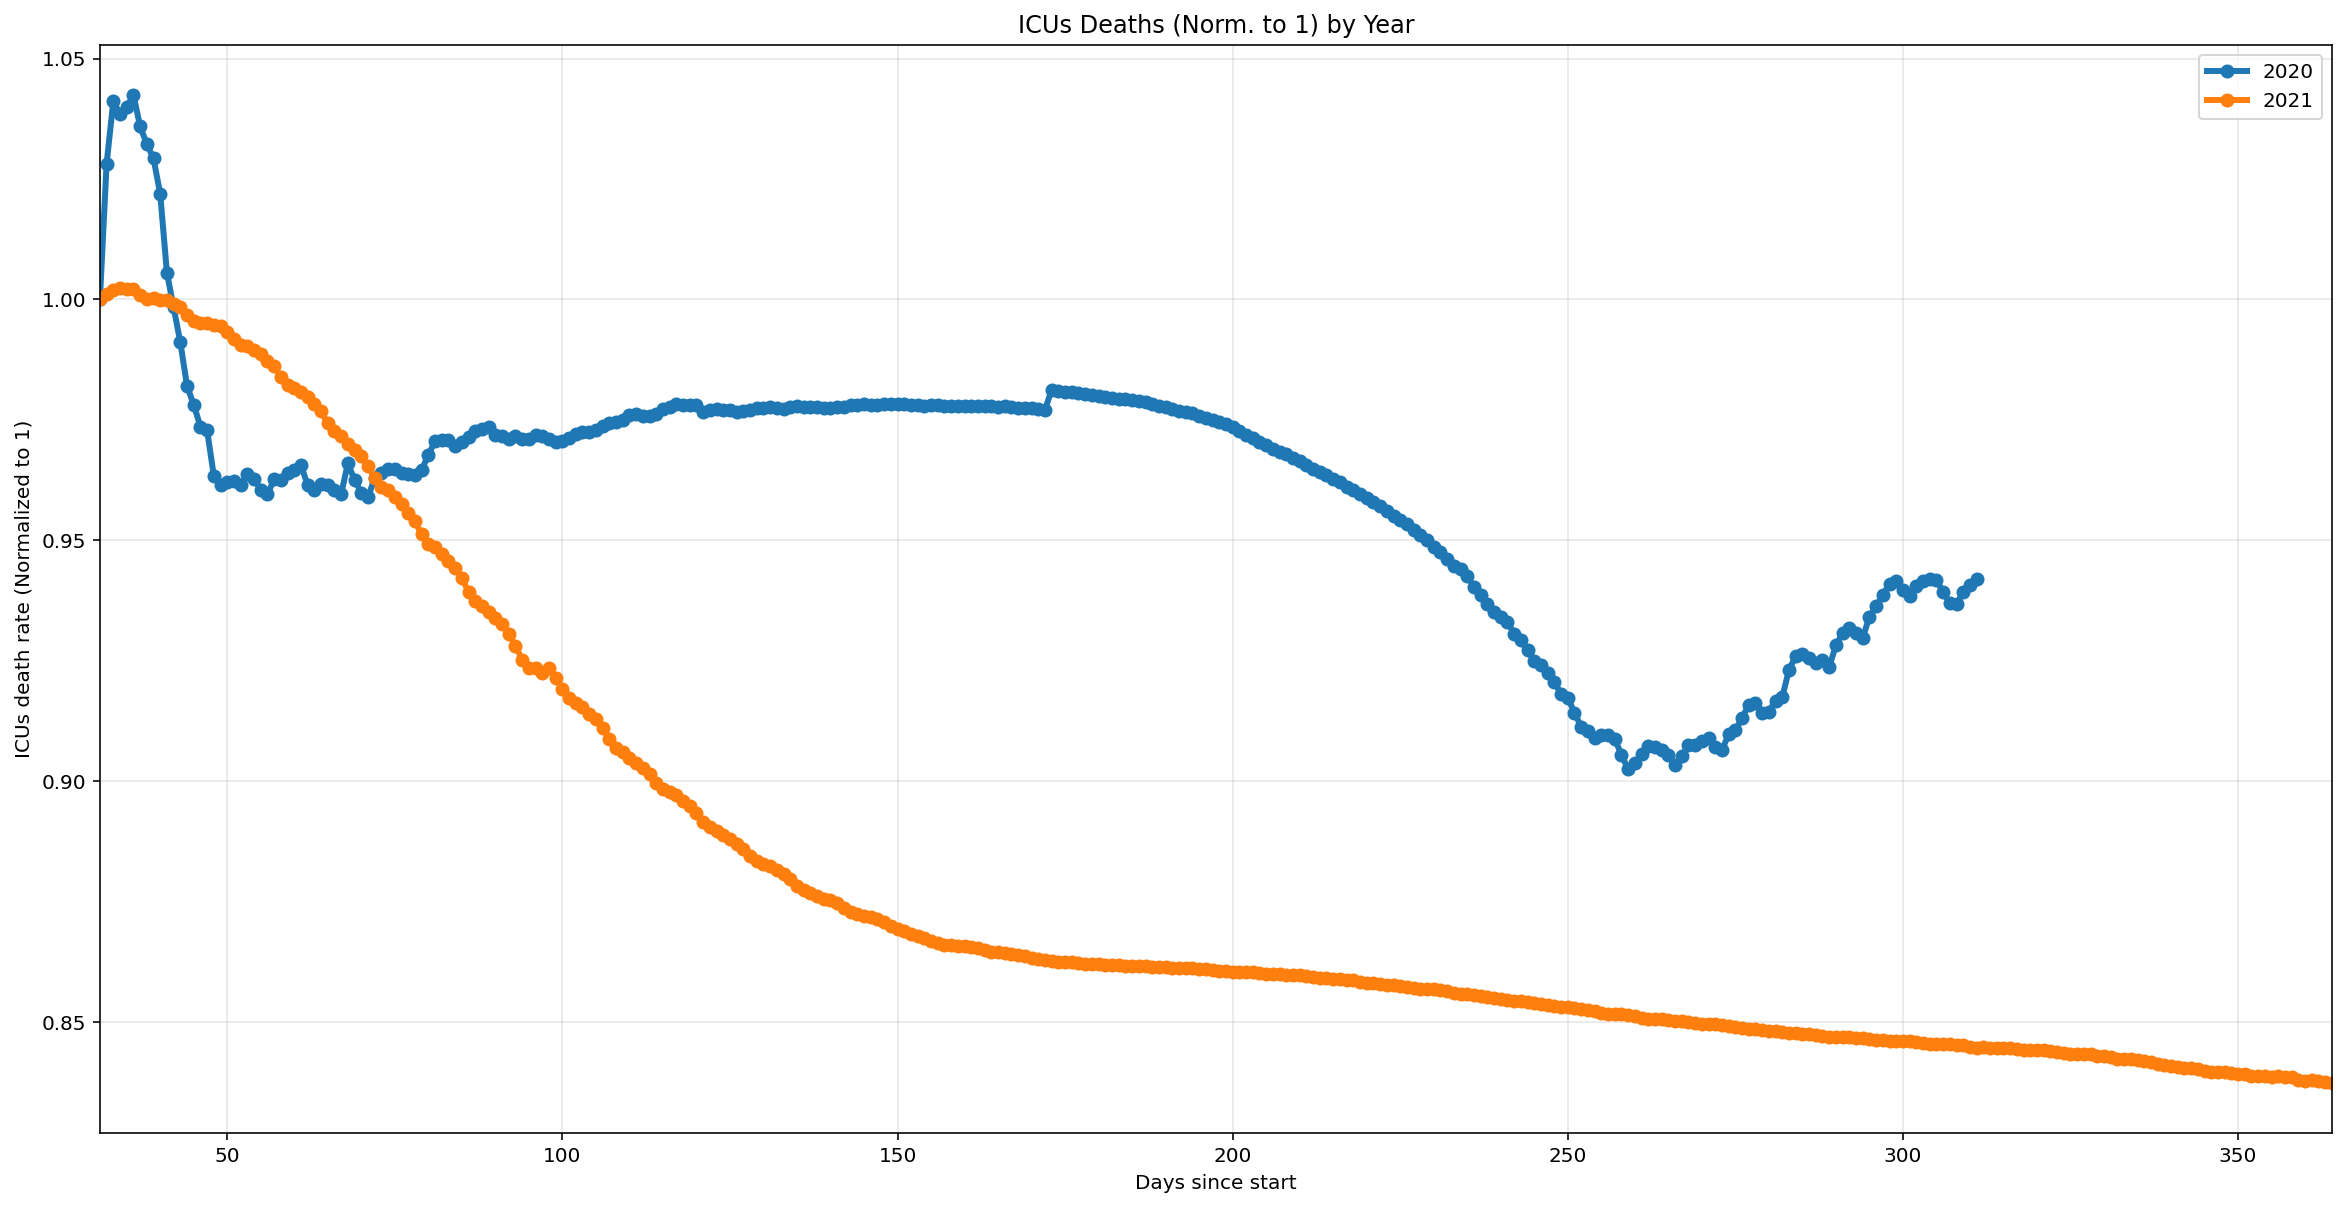

In [23]:
start_20 = y20.index[0]
start_21 = y21.index[0]
start_22 = y22.index[0]

y20['days_since_start'] = diff_dates(pd.to_datetime(start_20), pd.to_datetime(y20.index), days = True)
y21['days_since_start'] = diff_dates(pd.to_datetime(start_21), pd.to_datetime(y21.index), days = True)
y22['days_since_start'] = diff_dates(pd.to_datetime(start_22), pd.to_datetime(y22.index), days = True)

fig, ax = plt.subplots(figsize = (20,10))

ax.plot(y20[31:].days_since_start, y20[31:].ti_dec_ti.div(y20[31:].ti_dec_ti[0]), linewidth = 3, marker = 'o', label = '2020')
ax.plot(y21[31:].days_since_start, y21[31:].ti_dec_ti.div(y21[31:].ti_dec_ti[0]), linewidth = 3, marker = 'o', label = '2021')
_ = ax.grid(alpha = .3)
_ = ax.legend()
_ = ax.set_xlim([31, y21.days_since_start[-1]])
_ = ax.set_ylabel('ICUs death rate (Normalized to 1)')
_ = ax.set_xlabel('Days since start')
_ = ax.set_title('ICUs Deaths (Norm. to 1) by Year')

#### VACCINATION IS WORKING !!!!! ####

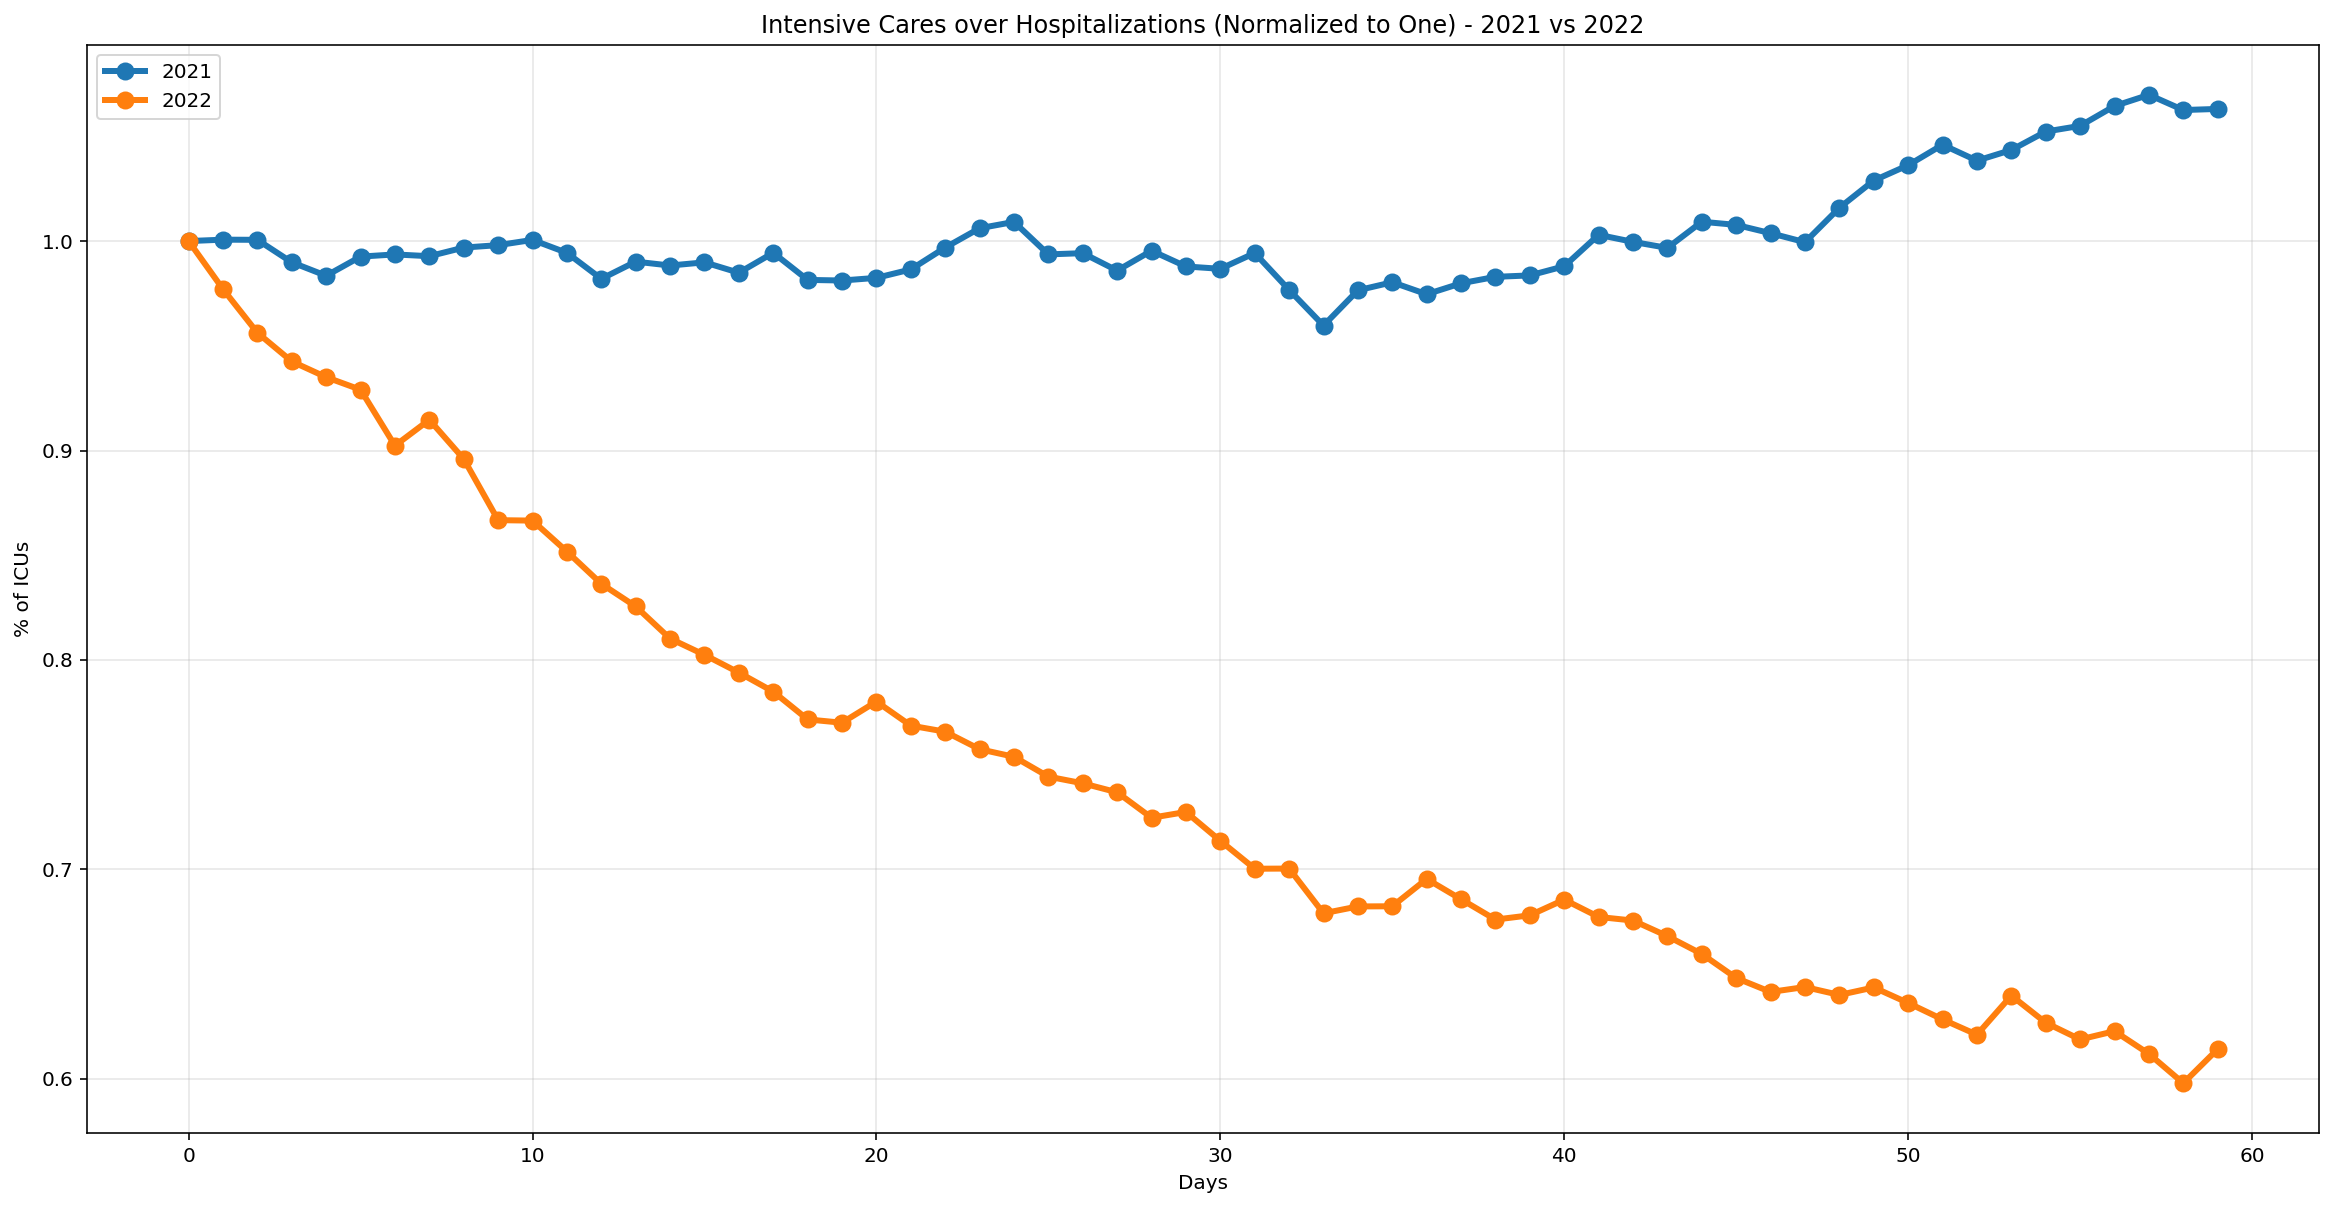

In [24]:
fig, ax = plt.subplots(figsize = (20,10))

y22_end = y22.reset_index().index[-1]
ax.plot(
    y21[:y22_end+1].days_since_start, 
    y21[:y22_end+1].ti_osp.div(y21[:y22_end+1].ti_osp[0]), 
    linewidth = 3, marker = 'o', label = '2021', markersize = 8
)
ax.plot(
    y22.days_since_start, 
    y22.ti_osp.div(y22.ti_osp[0]), 
    linewidth = 3, marker = 'o', label = '2022', markersize = 8
)
_ = ax.legend()
_ = ax.grid(alpha = .3)
_ = ax.set_title('Intensive Cares over Hospitalizations (Normalized to One) - 2021 vs 2022')
_ = ax.set_xlabel('Days')
_ = ax.set_ylabel('% of ICUs')

In [26]:
y21 = y21.reset_index()
y21['day'] = pd.to_datetime(y21.data).dt.day
y21['month'] = pd.to_datetime(y21.data).dt.month

In [47]:
y22 = y22.reset_index()
y22['day'] = pd.to_datetime(y22.data).dt.day
y22['month'] = pd.to_datetime(y22.data).dt.month

In [27]:
bymonth_mean = pd.pivot_table(y21, index = 'day', columns = 'month', values = 'ti_osp').mean(axis = 1)
bymonth_std = pd.pivot_table(y21, index = 'day', columns = 'month', values = 'ti_osp').std(axis = 1)

In [28]:
bymonth_mean.index = np.arange(len(bymonth_mean.index))
bymonth_std.index = np.arange(len(bymonth_std.index))

In [67]:
bymonth_mean_22 = pd.pivot_table(y22, index = 'day', columns = 'month', values = 'ti_osp').iloc[:, :2]
bymonth_std_22 = pd.pivot_table(y22, index = 'day', columns = 'month', values = 'ti_osp').iloc[:, :2]
bymonth_mean_22[2] = bymonth_mean_22[2].interpolate(method = 'spline', order = 2)
bymonth_std_22[2] = bymonth_std_22[2].interpolate(method = 'spline', order = 2)

In [70]:
bymonth_mean_22 = bymonth_mean_22.mean(axis = 1)
bymonth_std_22 = bymonth_std_22.mean(axis = 1)

In [68]:
bymonth_mean_22.index = np.arange(len(bymonth_mean_22.index))
bymonth_std_22.index = np.arange(len(bymonth_std_22.index))

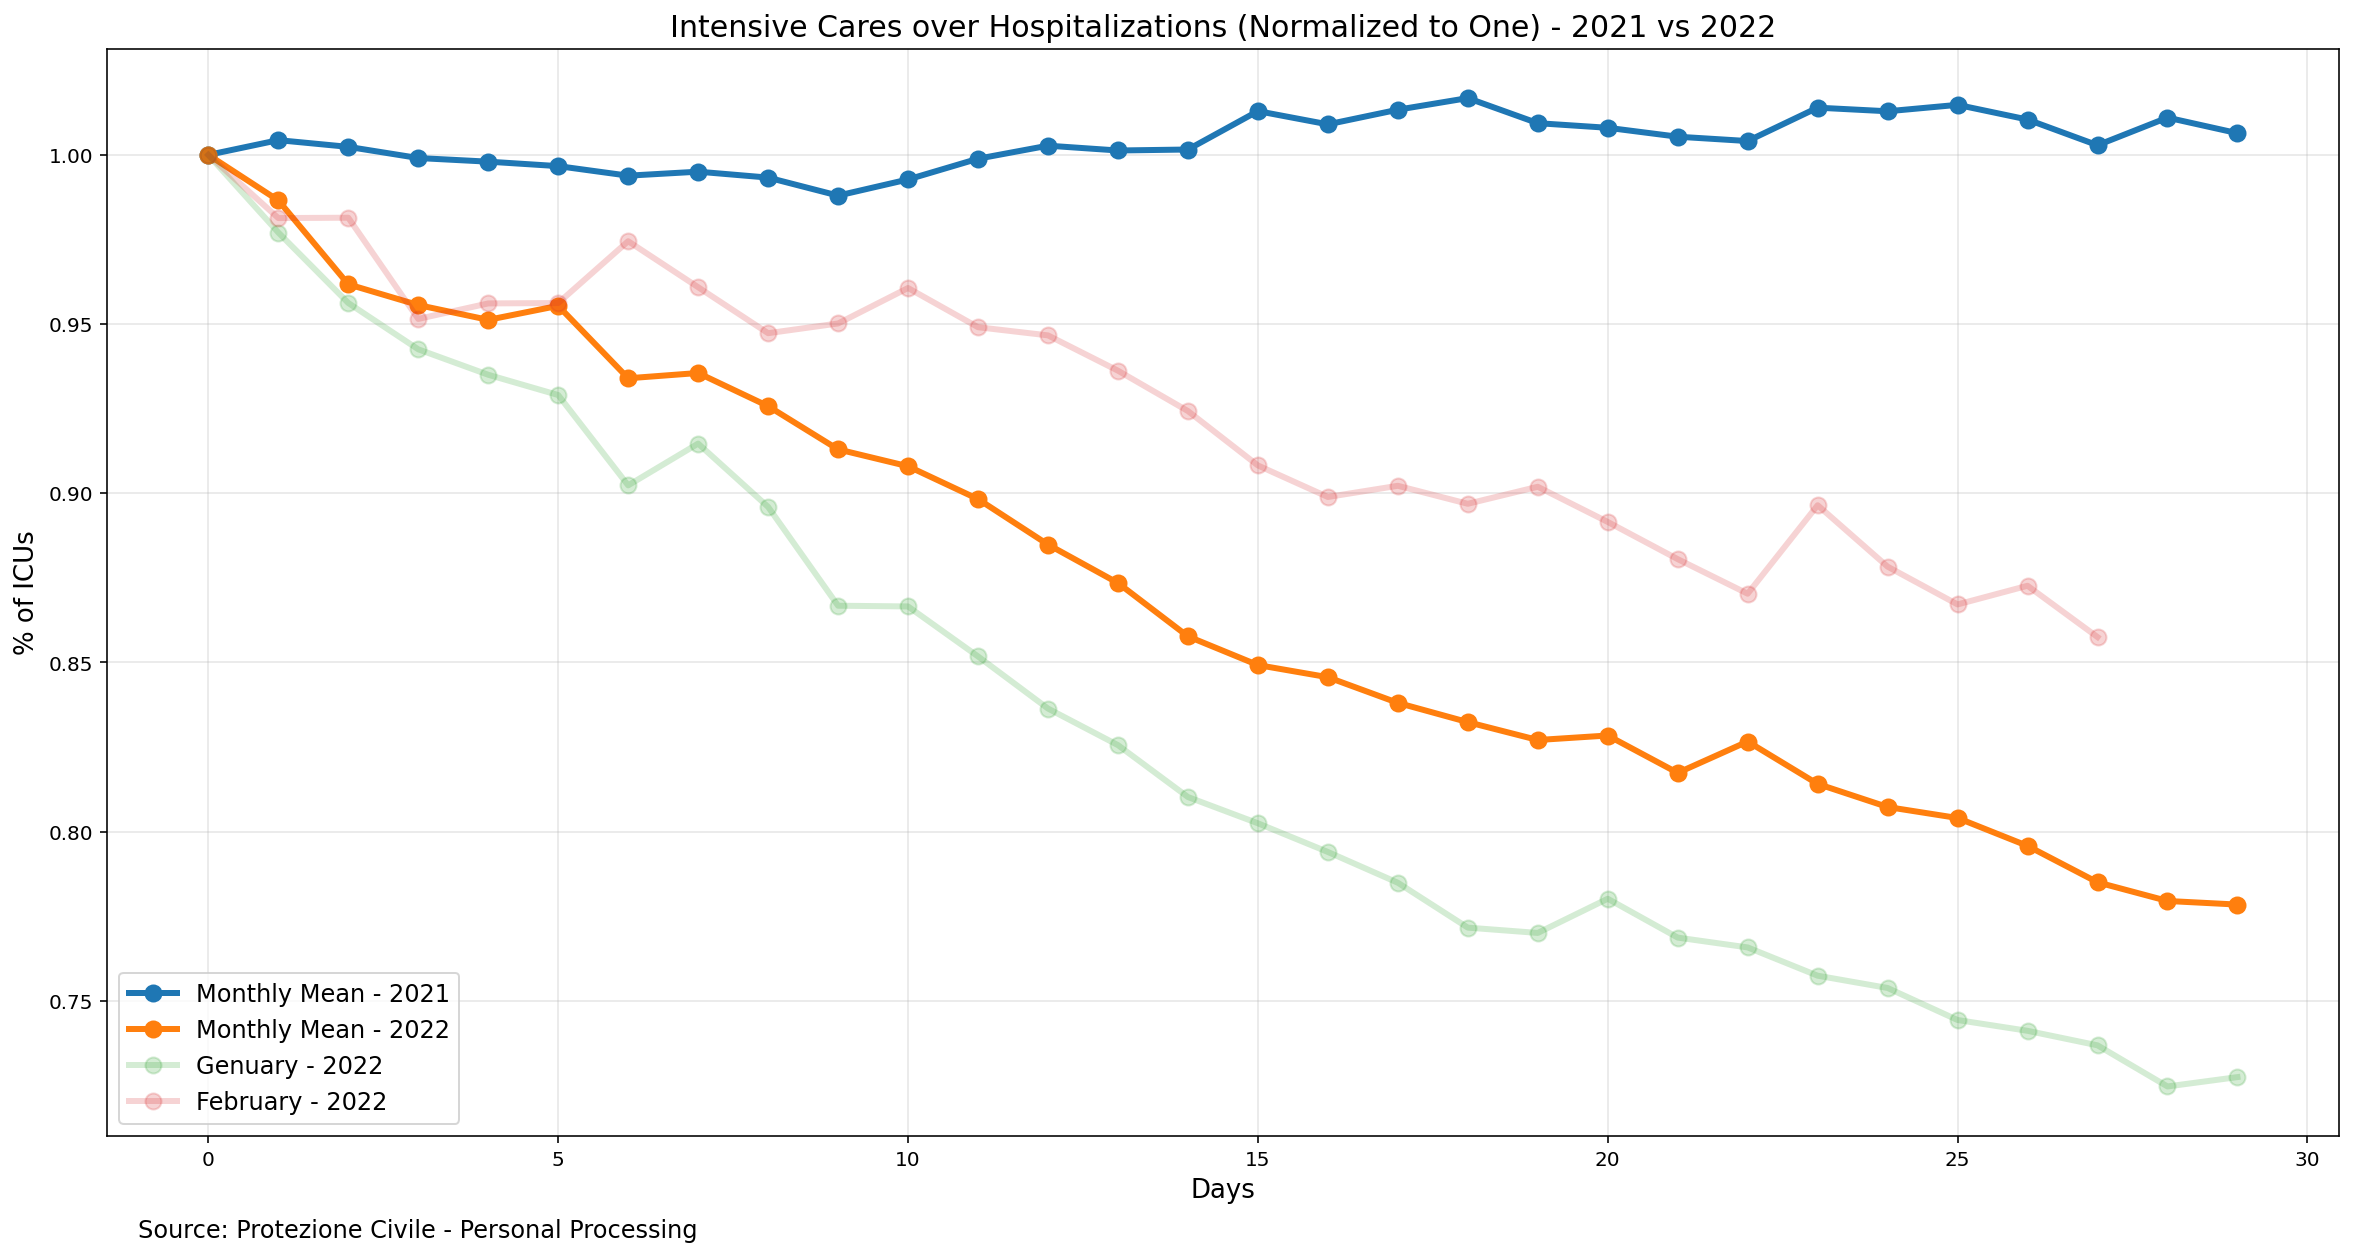

In [76]:
fig, ax = plt.subplots(figsize = (20,10))

y22_end = y22.reset_index().index[-1]
ax.plot(
    bymonth_mean.index[:-1], 
    bymonth_mean.div(bymonth_mean[0])[:-1], 
    linewidth = 3, marker = 'o', label = 'Monthly Mean - 2021', markersize = 8
)

ax.plot(
    bymonth_mean_22.index[:-1], 
    bymonth_mean_22.div(bymonth_mean_22[0])[:-1], 
    linewidth = 3, marker = 'o', label = 'Monthly Mean - 2022', markersize = 8
)

ax.plot(
    y22.days_since_start[:30], 
    y22.ti_osp.div(y22.ti_osp[0])[:30], 
    linewidth = 3, marker = 'o', alpha = .2,
    label = 'Genuary - 2022', markersize = 8
)

ax.plot(
    y22.days_since_start[:28], 
    y22.ti_osp.div(y22.ti_osp[30])[30:58], 
    linewidth = 3, marker = 'o', alpha = .2,
    label = 'February - 2022', markersize = 8
)

_ = ax.legend(fontsize = 12)
_ = ax.grid(alpha = .3)
_ = ax.set_title('Intensive Cares over Hospitalizations (Normalized to One) - 2021 vs 2022', fontsize = 15)
_ = ax.set_xlabel('Days', fontsize = 13)
_ = ax.set_ylabel('% of ICUs', fontsize = 13)
_ = ax.text(-1, 0.68, 'Source: Protezione Civile - Personal Processing', fontsize = 12)

In [63]:
bymonth_mean = pd.pivot_table(y21, index = 'day', columns = 'month', values = 'ti_osp').mean(axis = 1)
bymonth_std = pd.pivot_table(y21, index = 'day', columns = 'month', values = 'ti_osp').std(axis = 1)

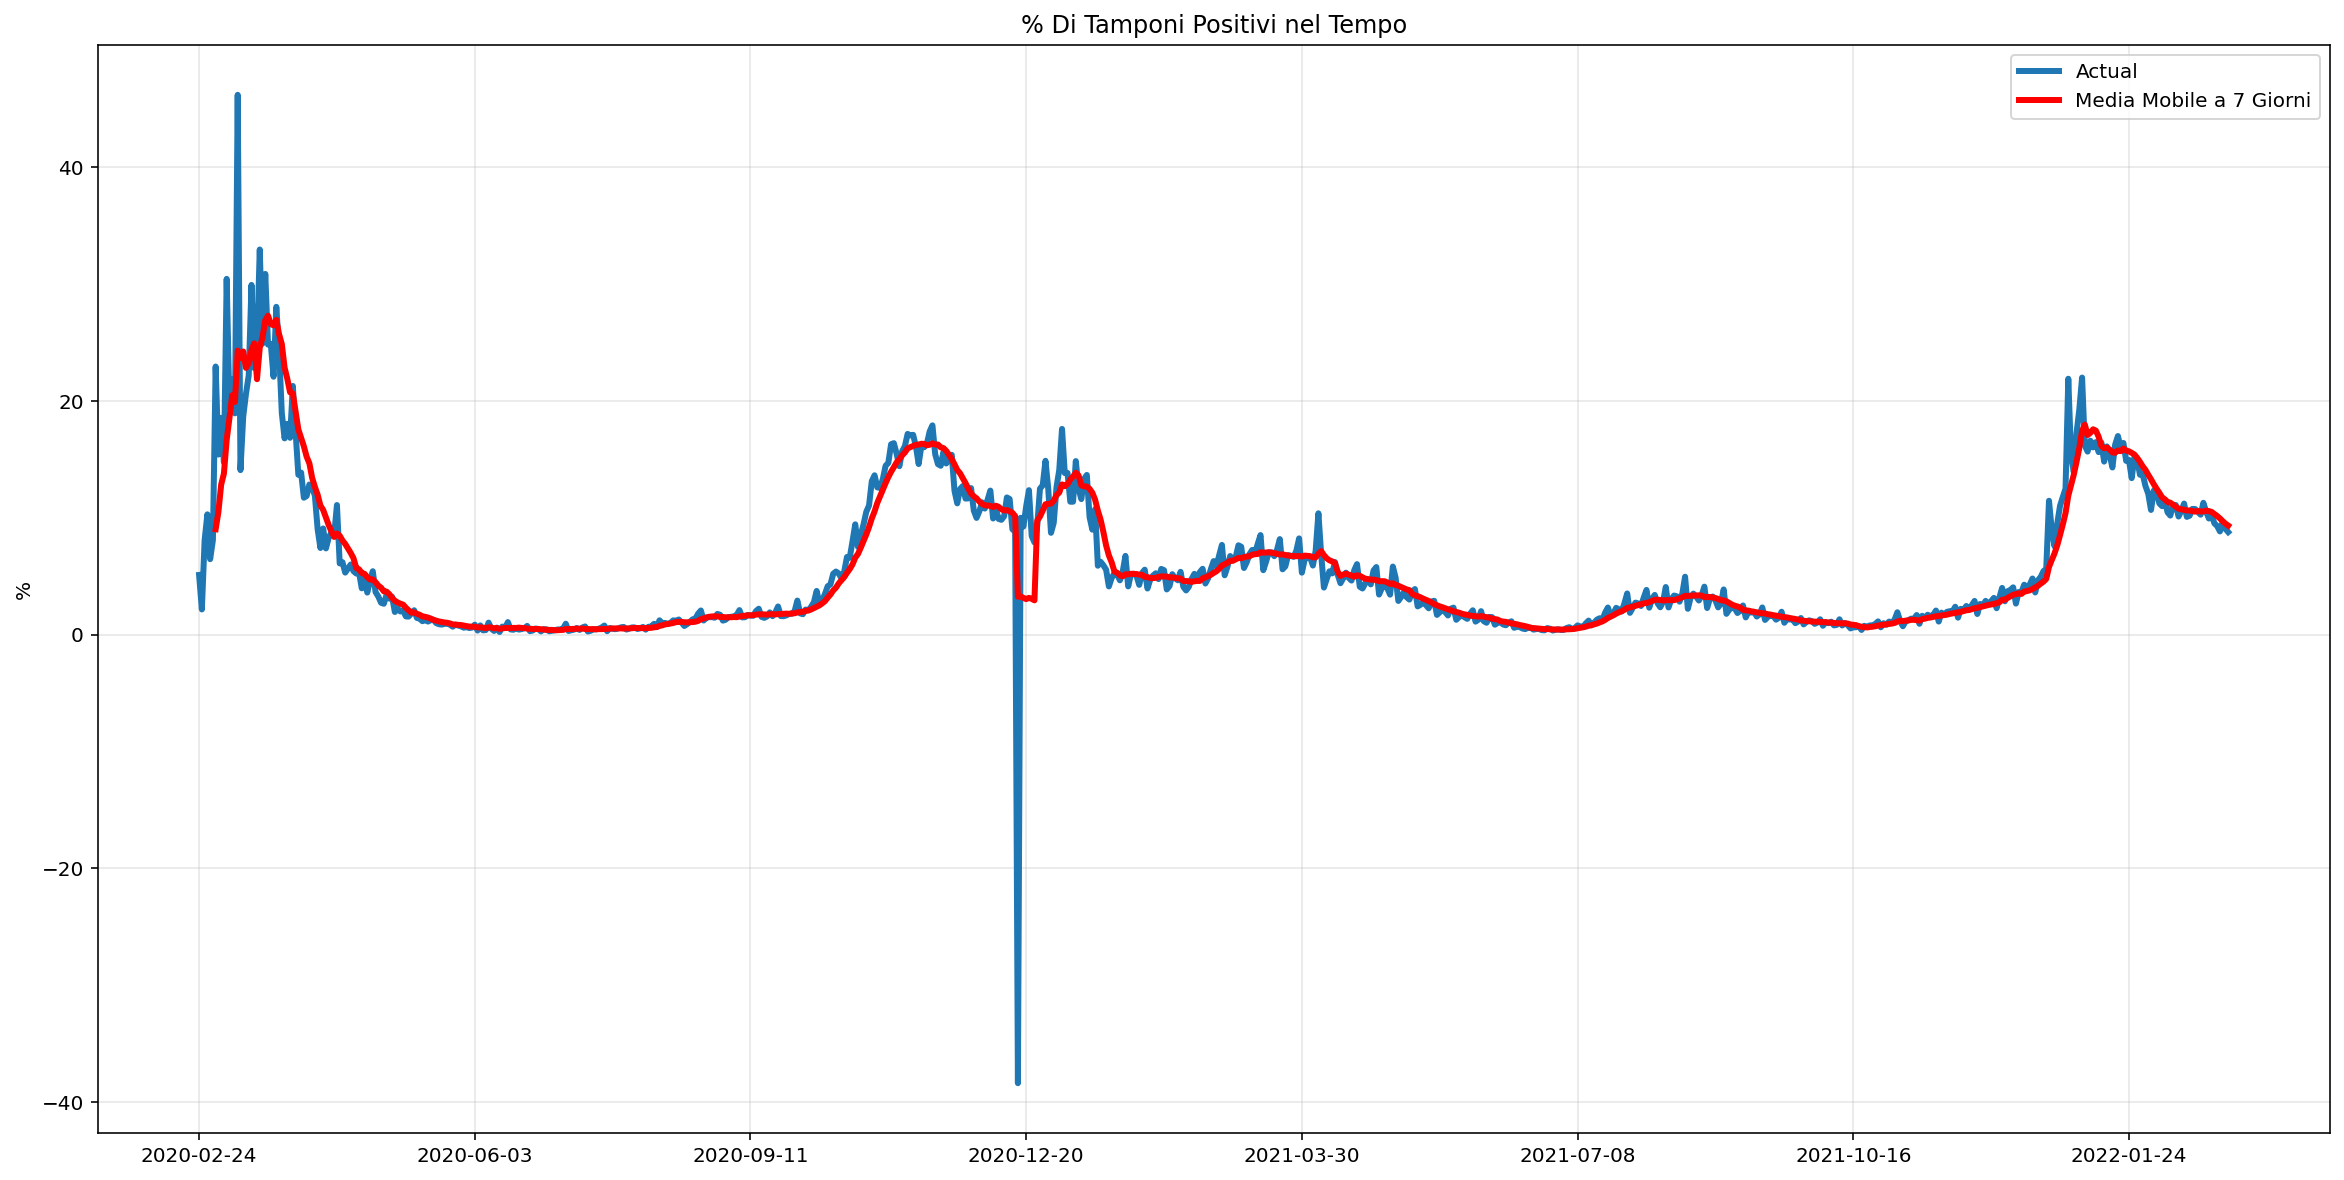

In [77]:
ti['pos_perc'] = (ti.nuovi_positivi / ti.diff_tamponi) * 100

fig, ax = plt.subplots(figsize = (20,10))

ti.pos_perc.plot(ax = ax, linewidth = 3, label = 'Actual')
ti.pos_perc.rolling(7).mean().plot(ax = ax, linewidth = 3, c = 'r', label = 'Media Mobile a 7 Giorni')
_ = ax.legend()
_ = ax.grid(alpha=.3)
_ = ax.set_xlabel('')
_ = ax.set_ylabel('%')
_ = ax.set_title('% Di Tamponi Positivi nel Tempo')

In [78]:
ti['pos_perc_firstder'] = ti.pos_perc.diff()

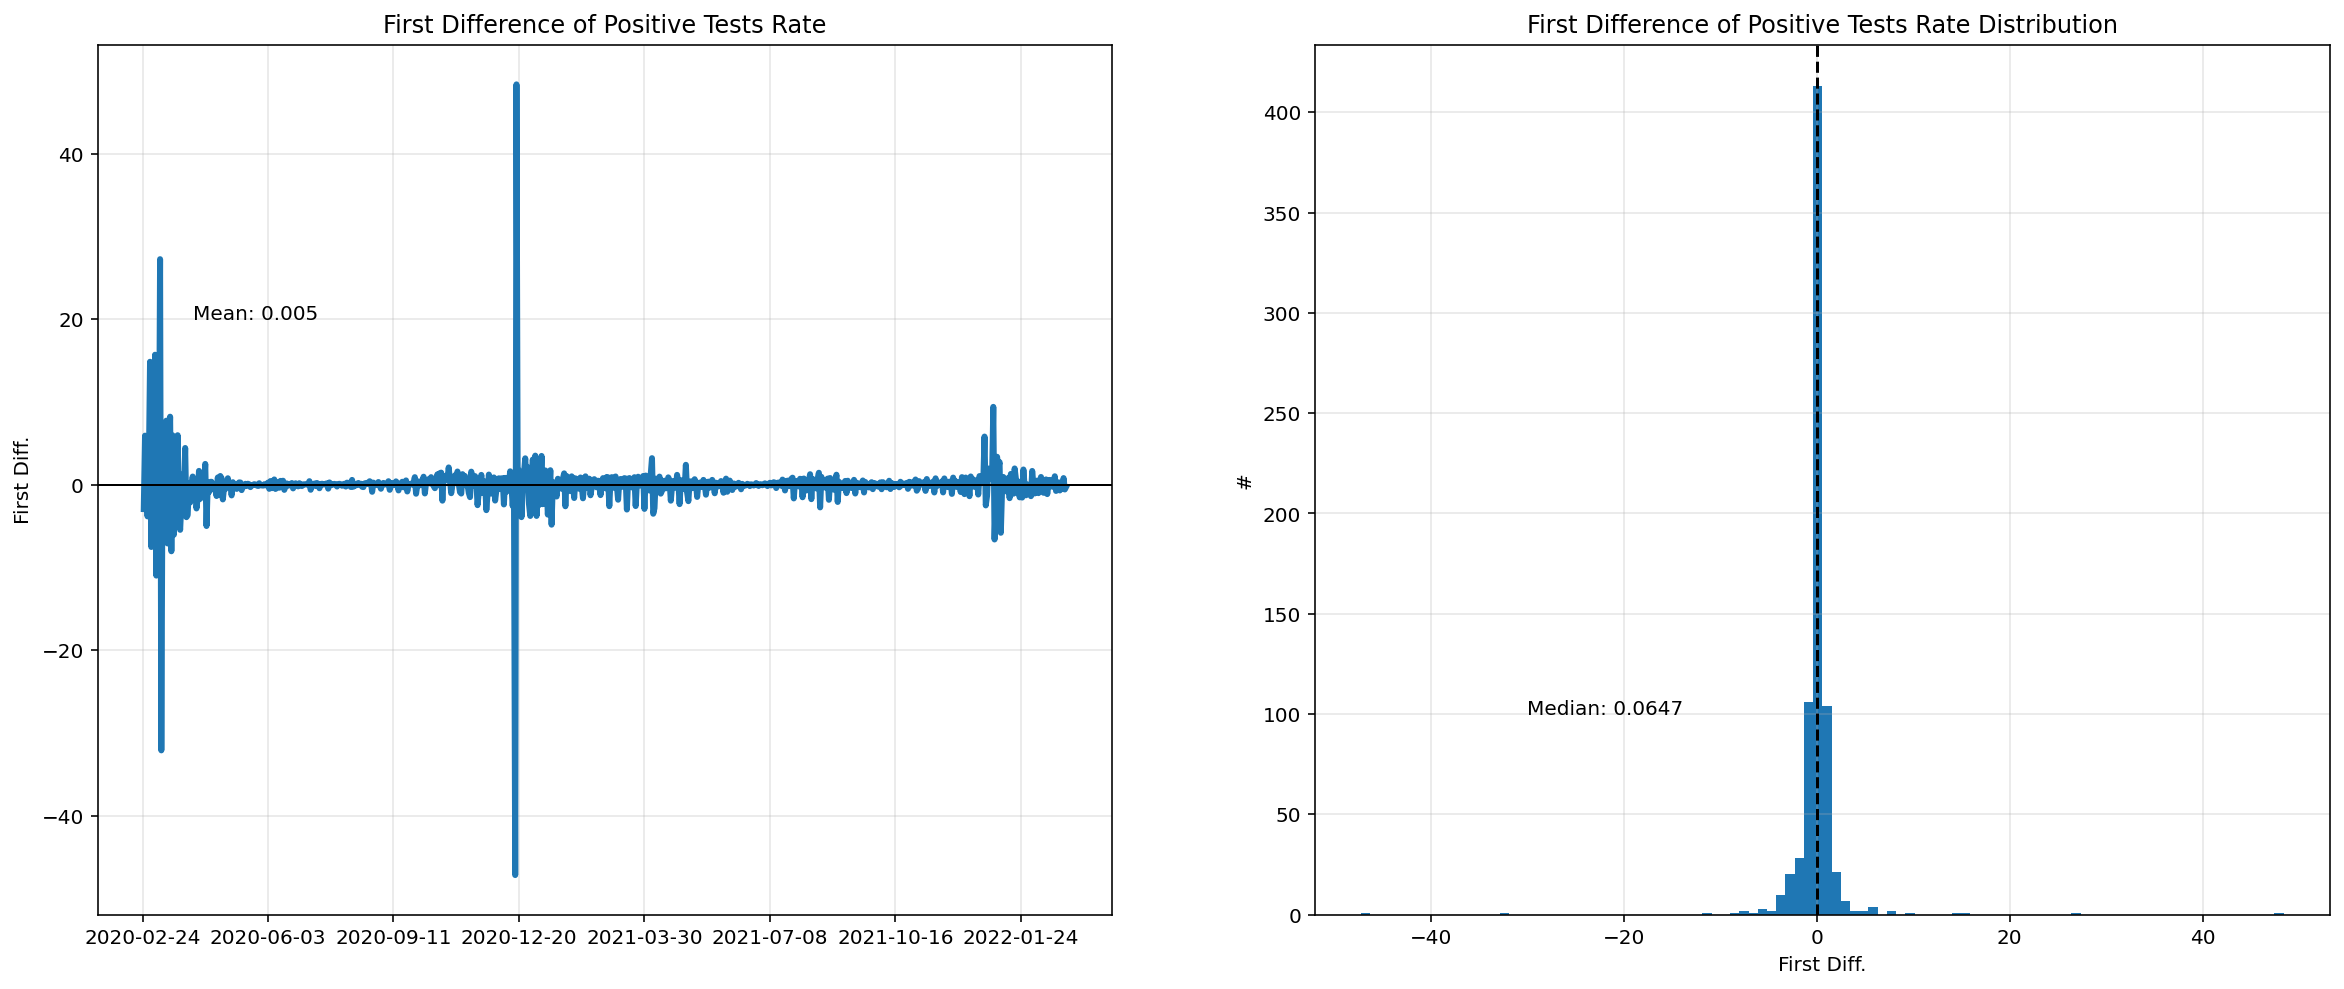

In [79]:
fig, ax = plt.subplots(1,2, figsize=(20,8))

ti.pos_perc_firstder.plot(ax = ax[0], linewidth = 3)
ti.pos_perc_firstder.hist(ax = ax[1], bins = 100)
_ = ax[0].axhline(ti.pos_perc_firstder.mean(), c = 'k', linewidth = 1)
_ = ax[1].axvline(ti.pos_perc_firstder.median(), c = 'k', linestyle = '--')
_ = ax[0].set_xlabel('')
_ = ax[0].text(40, 20, f'Mean: {round(ti.pos_perc_firstder.mean(),4)}')
_ = ax[1].text(-30, 100, f'Median: {round(ti.pos_perc_firstder.median(),4)}')

for n, _ in enumerate(ax):
    _ = ax[n].grid(alpha=.3)
    _ = ax[n].set_title(['First Difference of Positive Tests Rate', 'First Difference of Positive Tests Rate Distribution'][n])
    _ = ax[n].set_ylabel(['First Diff.', '#'][n])
    _ = ax[n].set_xlabel(['', 'First Diff.'][n])

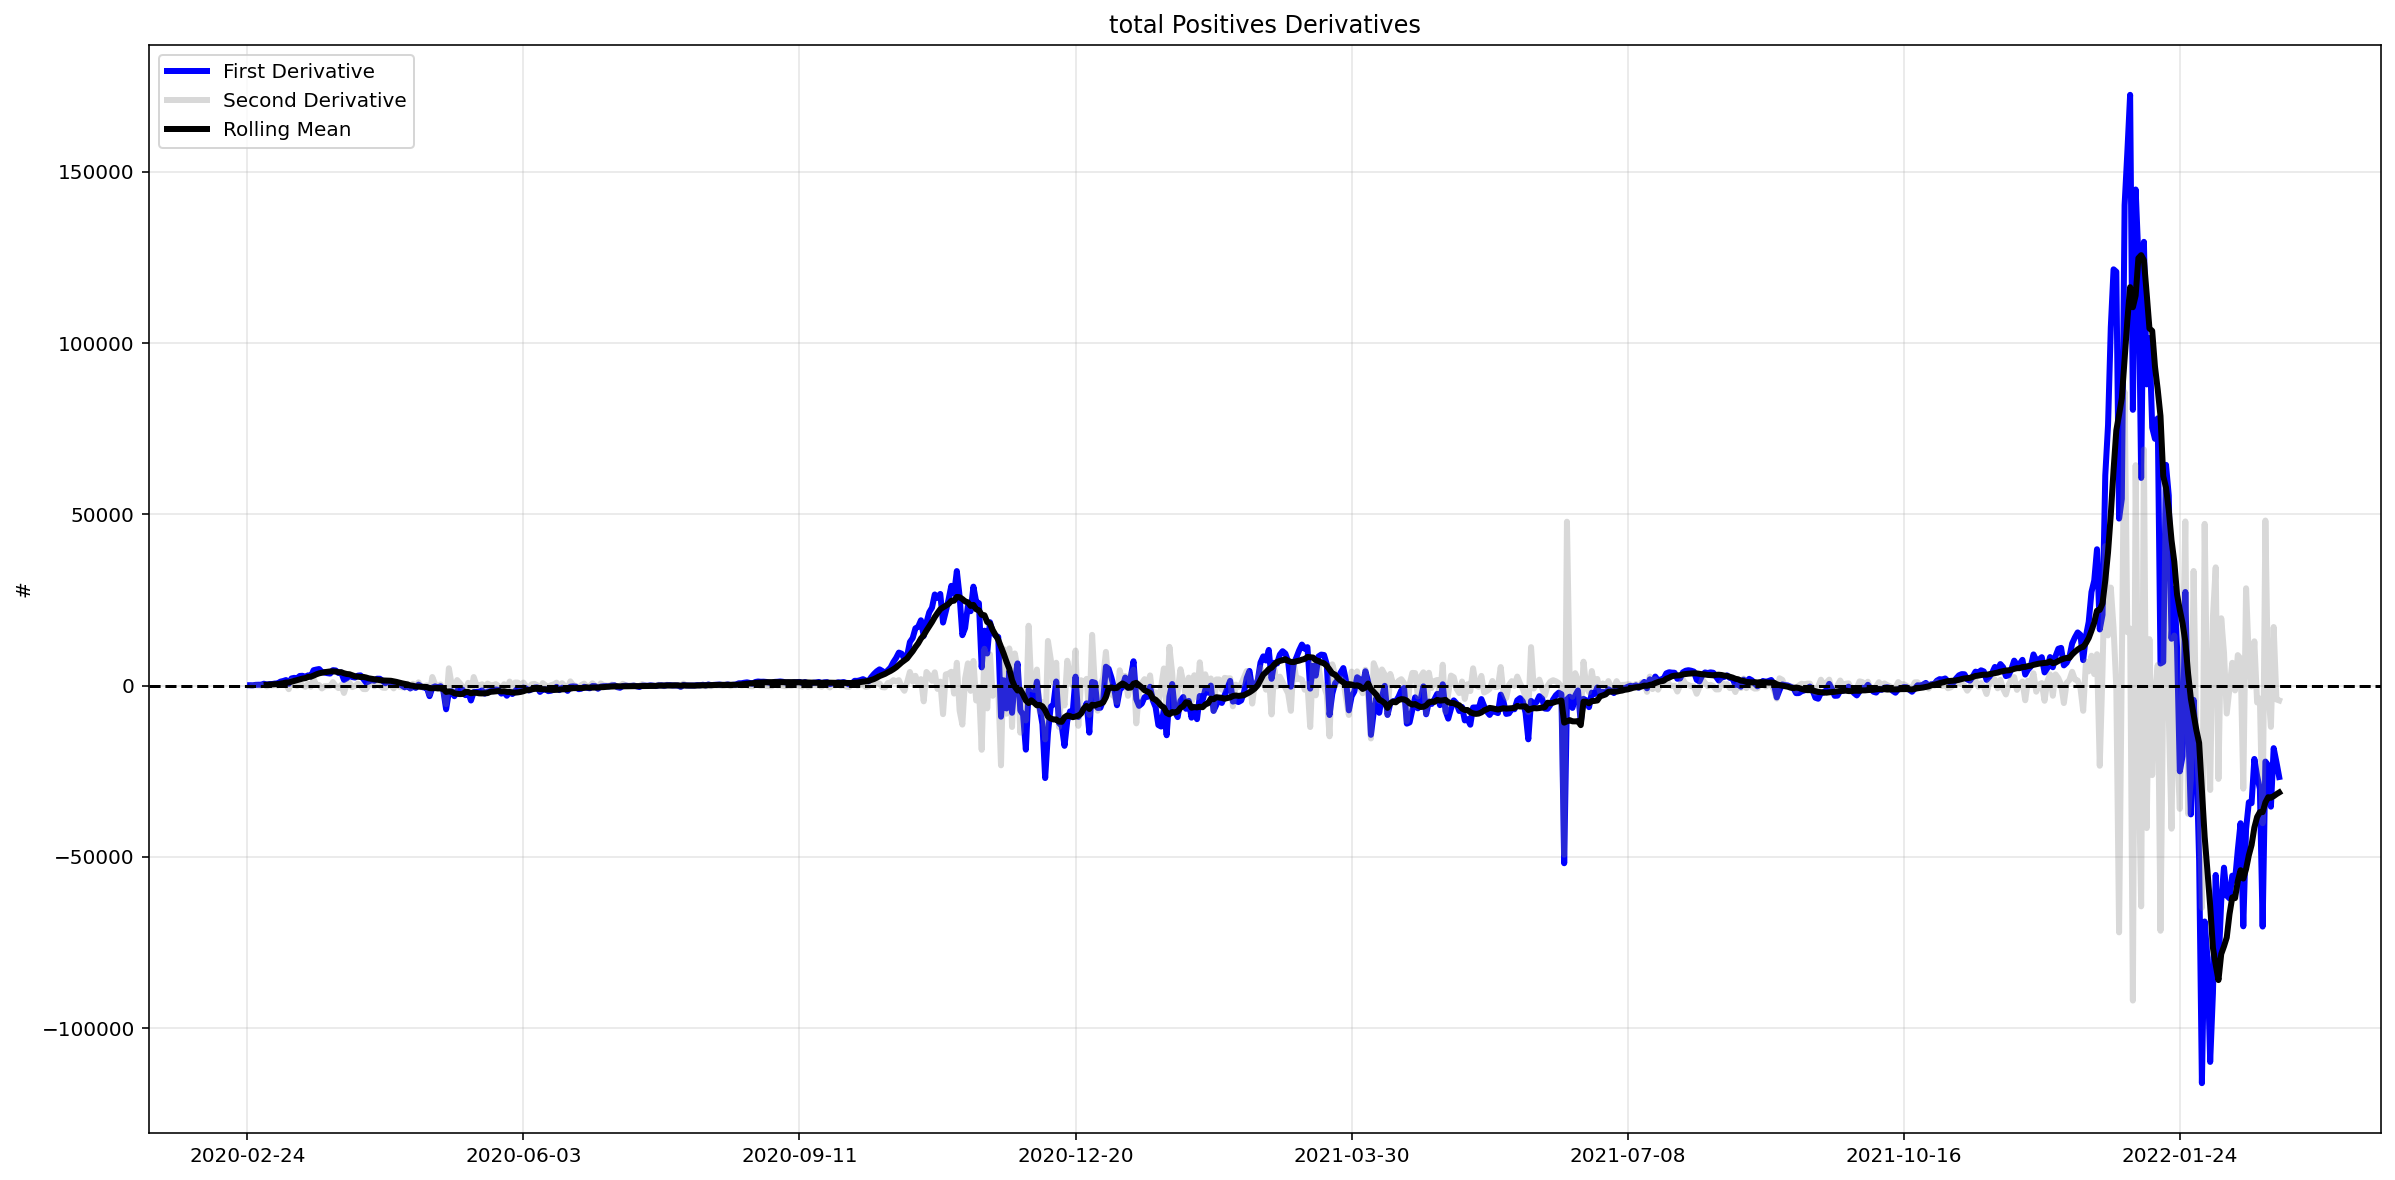

In [80]:
d_pos = ti.totale_positivi.diff()
d2_pos = d_pos.diff()
ti['d_pos'] = d_pos

fig, ax = plt.subplots(figsize=(20,10))

d_pos.plot(ax=ax, linewidth=3, label = 'First Derivative', c = 'b')
d2_pos.plot(ax=ax, linewidth=3, c='grey', label = 'Second Derivative', alpha = .3)
d_pos.rolling(7).mean().plot(ax=ax, linewidth=3, c = 'k', label = 'Rolling Mean')
_ = ax.legend()
_ = ax.axhline(0, c='k', linestyle='--')
_ = ax.grid(alpha=.3)
_ = ax.set_xlabel('')
_ = ax.set_ylabel('#')
_ = ax.set_title('total Positives Derivatives')

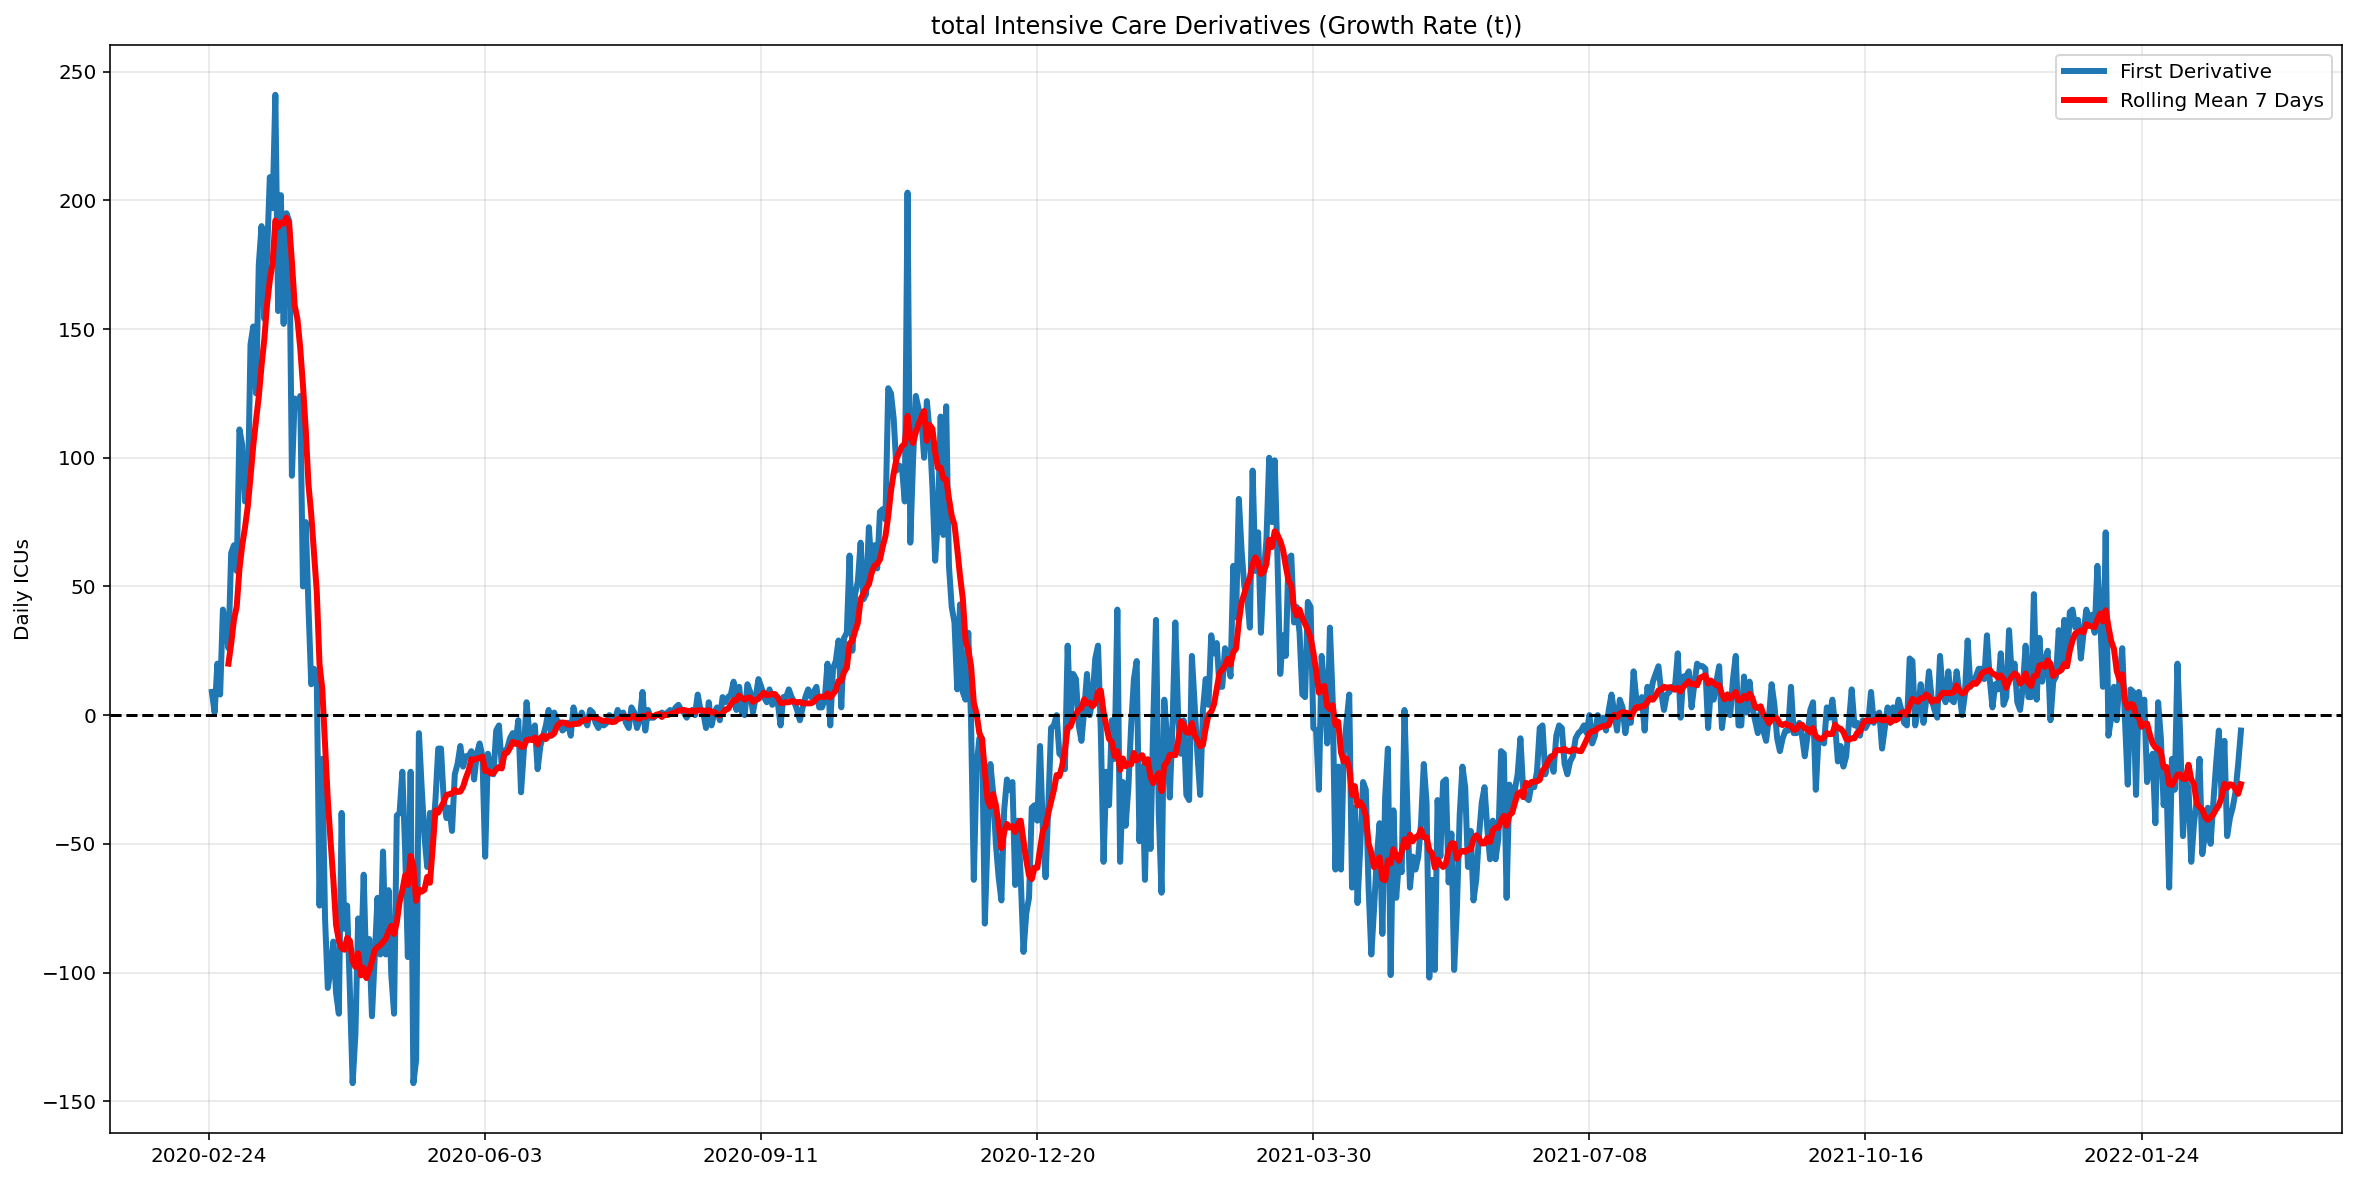

In [81]:
d_ti = ti.terapia_intensiva.diff()
d2_ti = d_ti.diff()
ti['d_pos'] = d_pos

fig, ax = plt.subplots(figsize=(20,10))

d_ti.plot(ax=ax, linewidth=3, label = 'First Derivative')
d_ti.rolling(7).mean().plot(ax=ax, linewidth=3, c='r', label = 'Rolling Mean 7 Days')
_ = ax.legend()
_ = ax.axhline(0, c='k', linestyle='--')
_ = ax.grid(alpha=.3)
_ = ax.set_xlabel('')
_ = ax.set_ylabel('Daily ICUs')
_ = ax.set_title('total Intensive Care Derivatives (Growth Rate (t))')

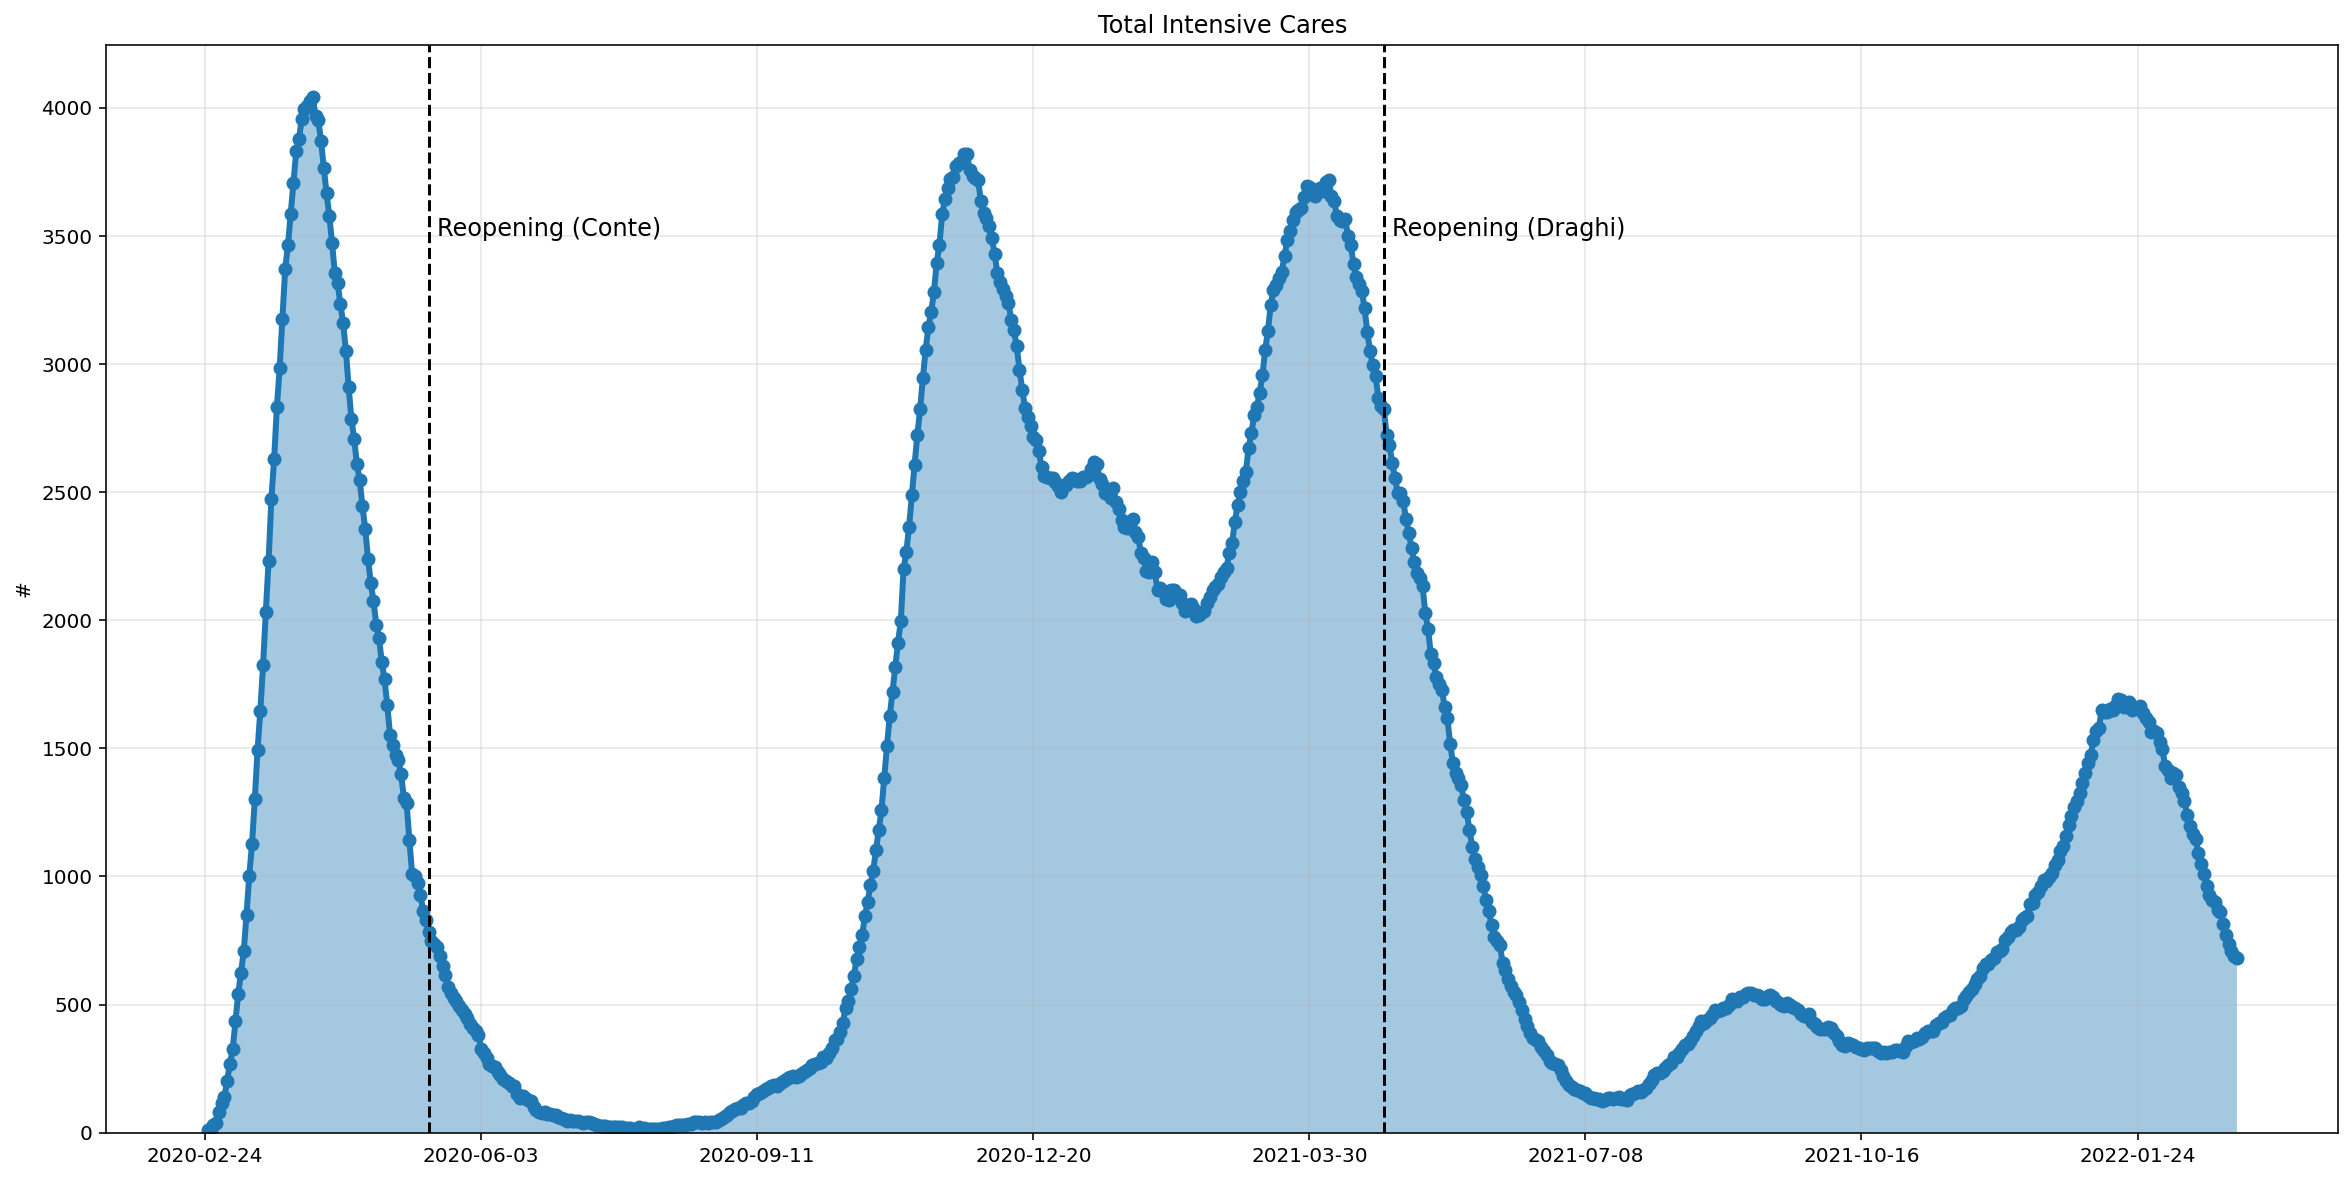

In [82]:
fig, ax = plt.subplots(figsize=(20,10))

draghi_reop = (pd.to_datetime('2021-04-26') - pd.to_datetime(d_ti.index[0])).days
conte_reop = (pd.to_datetime('2020-05-15') - pd.to_datetime(d_ti.index[0])).days
d_ti.cumsum().plot(ax=ax, linewidth = 3, marker = 'o')
_ = ax.fill_between(d_ti.cumsum().index, d_ti.cumsum(), alpha = .4)
_ = ax.grid(alpha = .3)
_ = ax.set_xlabel('')
_ = ax.set_ylabel('#')
_ = ax.set_title('Total Intensive Cares')
_ = ax.axvline(draghi_reop, c = 'k', linestyle = '--')
_ = ax.axvline(conte_reop, c = 'k', linestyle = '--')
_ = ax.text(draghi_reop+3, 3500, 'Reopening (Draghi)', fontsize = 12)
_ = ax.text(conte_reop+3, 3500, 'Reopening (Conte)', fontsize = 12)
_ = ax.set_ylim(0)

Nowdays excess of deaths respect to the same period of 2020 is crearly explained by this plot: the first re-opening was made with about 750 ICU patients, while the second re-opening was made with almost 3000 ICU patients. By now, the number of ICU patients is more than double last year. 

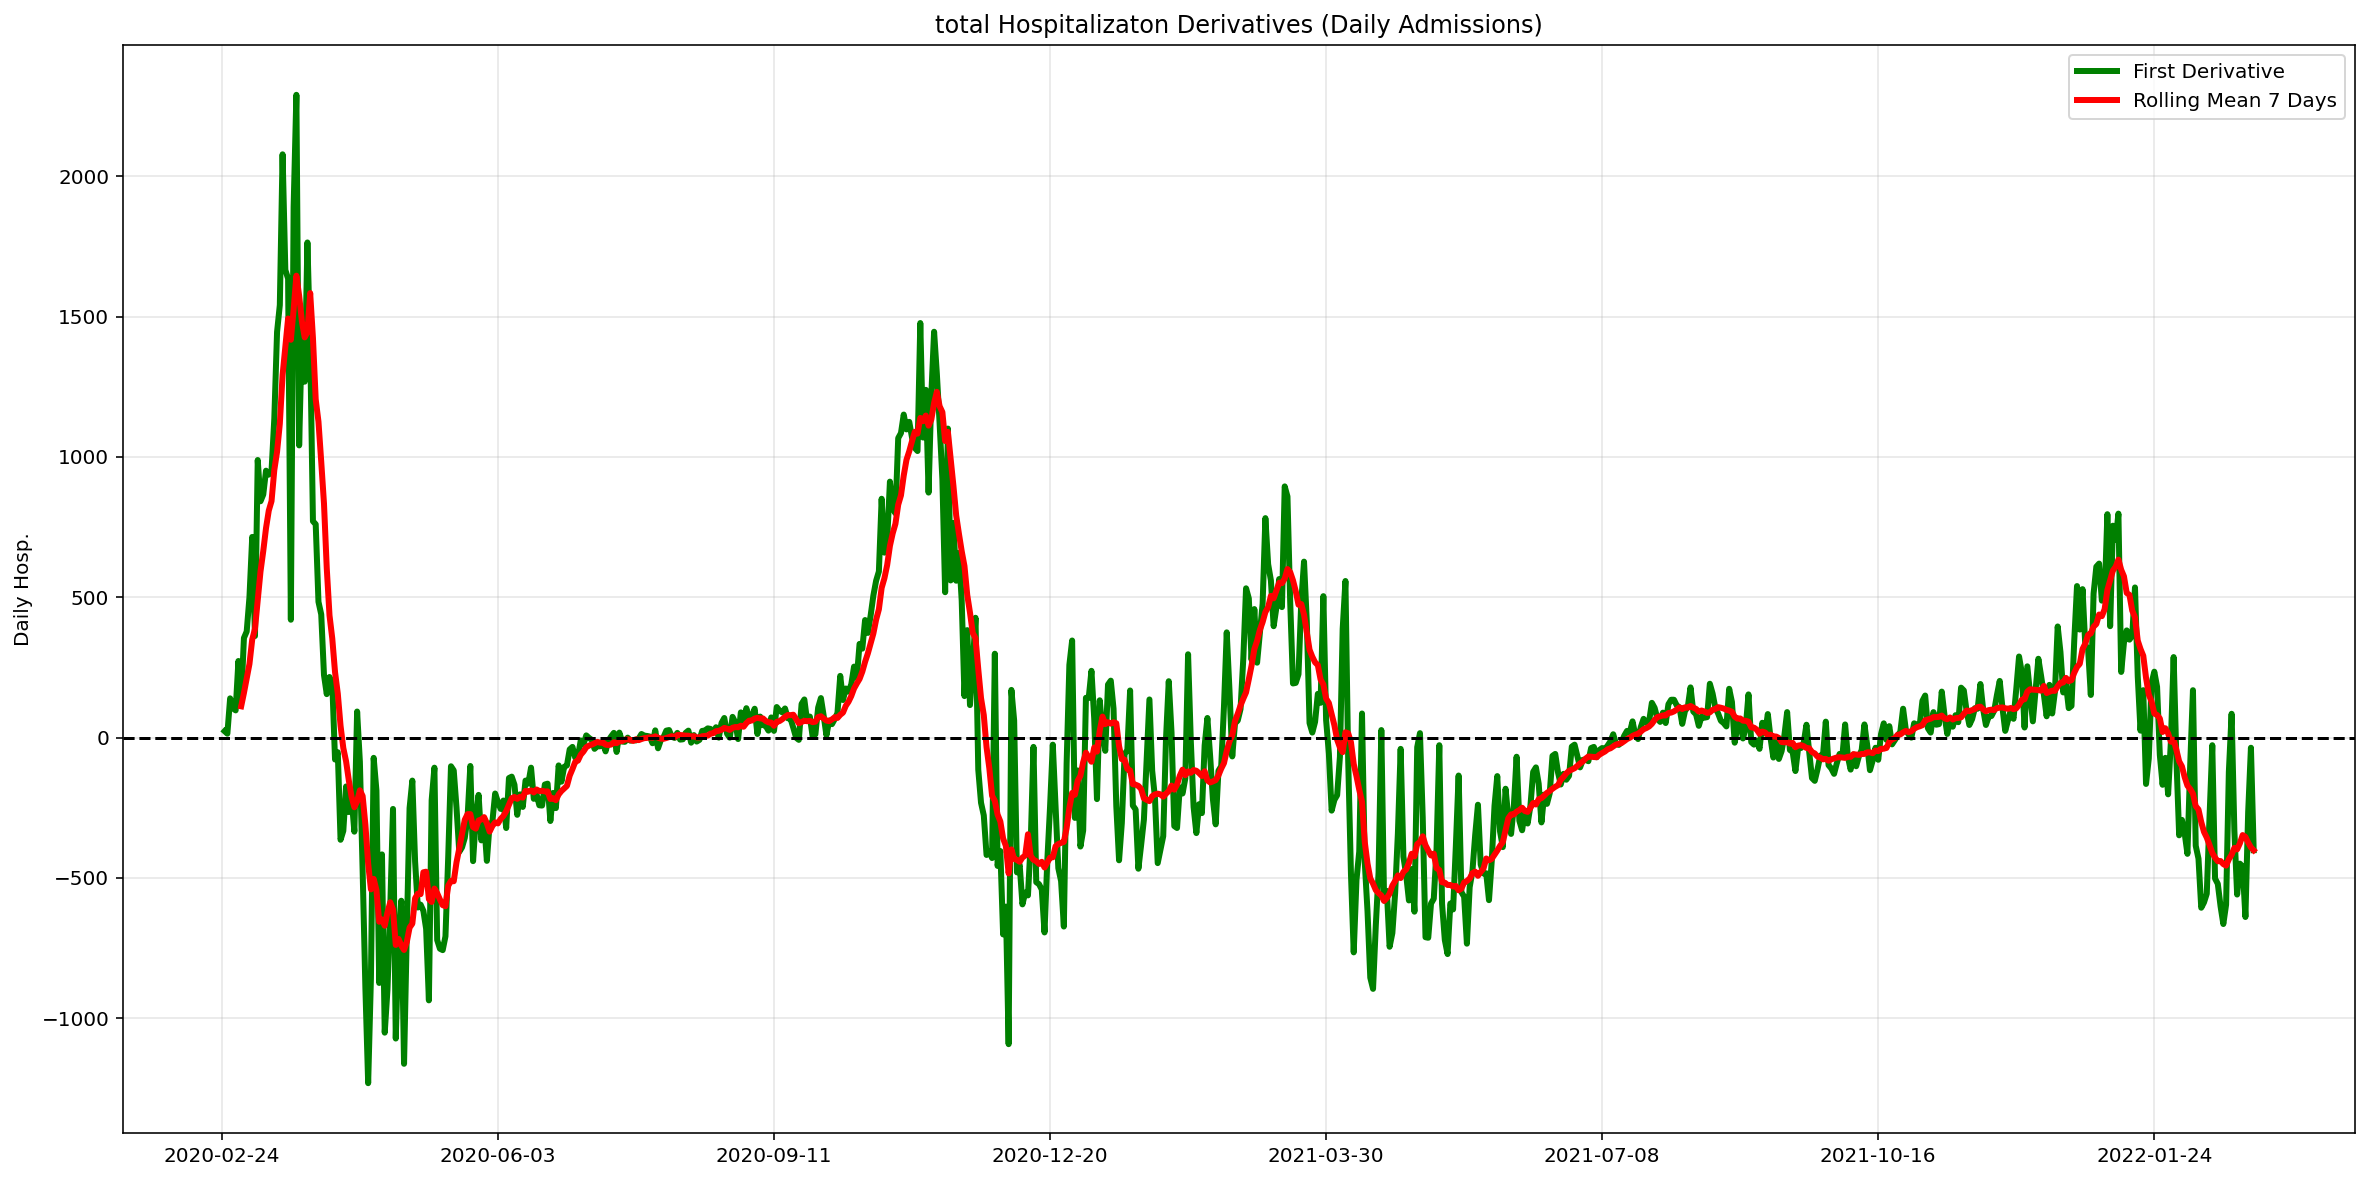

In [83]:
d_osp = ti.ospedalizzati.diff()
d2_osp = d_osp.diff()

fig, ax = plt.subplots(figsize=(20,10))

d_osp.plot(ax=ax, linewidth=3, label = 'First Derivative', c = 'green')
d_osp.rolling(7).mean().plot(ax=ax, linewidth=3, c='r', label = 'Rolling Mean 7 Days')
_ = ax.legend()
_ = ax.axhline(0, c='k', linestyle='--')
_ = ax.grid(alpha=.3)
_ = ax.set_xlabel('')
_ = ax.set_ylabel('Daily Hosp.')
_ = ax.set_title('total Hospitalizaton Derivatives (Daily Admissions)')

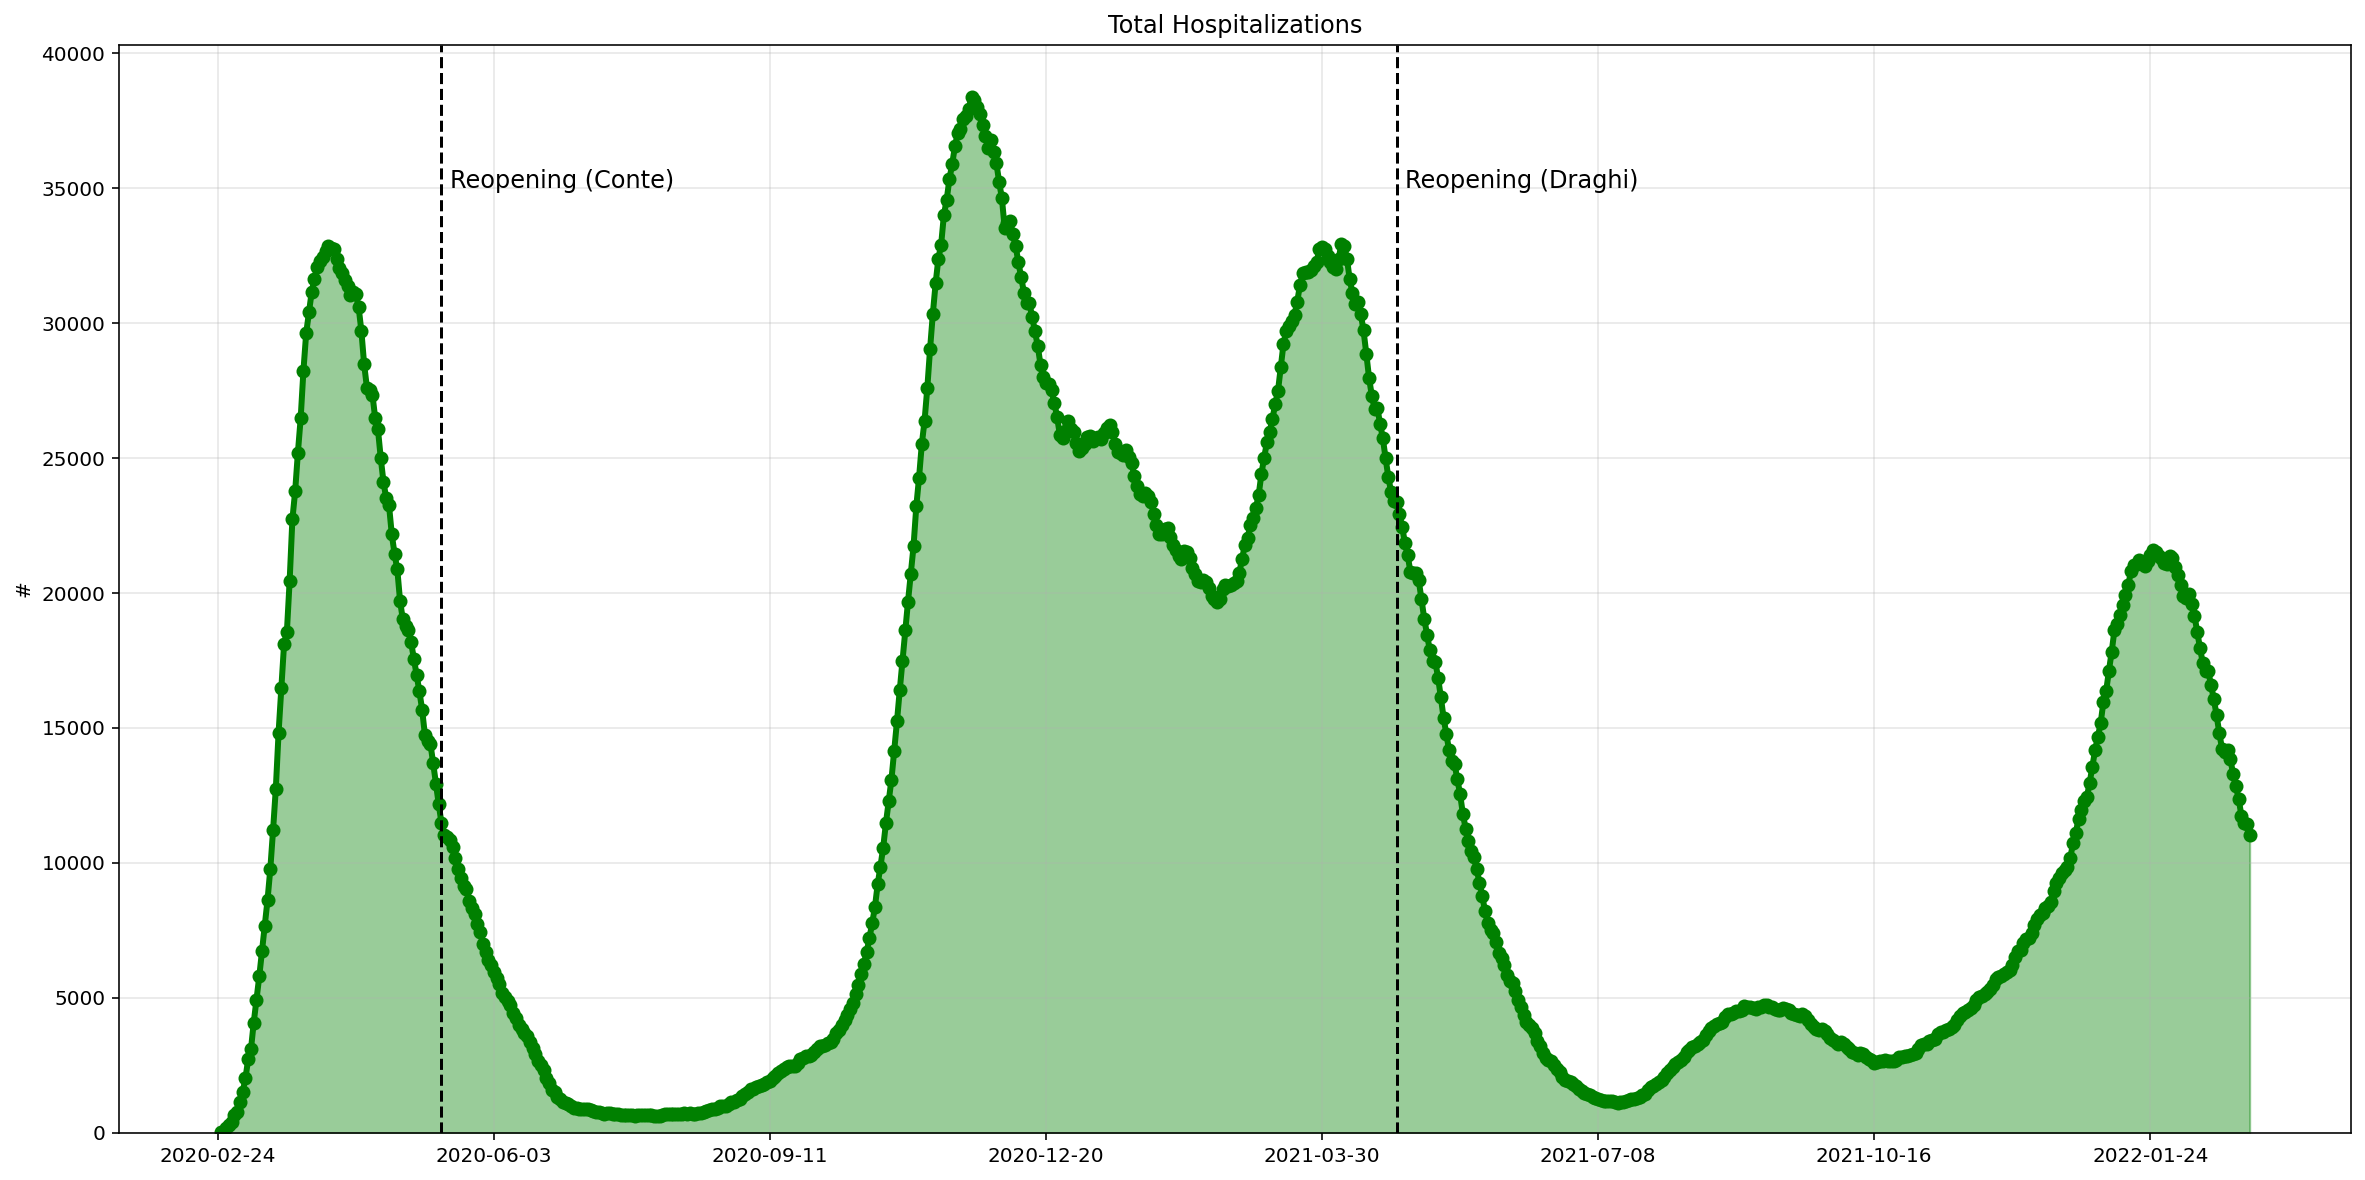

In [84]:
fig, ax = plt.subplots(figsize=(20,10))

draghi_reop = (pd.to_datetime('2021-04-26') - pd.to_datetime(d_ti.index[0])).days
conte_reop = (pd.to_datetime('2020-05-15') - pd.to_datetime(d_ti.index[0])).days
d_osp.cumsum().plot(ax=ax, linewidth = 3, marker = 'o', c = 'g')
_ = ax.fill_between(d_osp.cumsum().index, d_osp.cumsum(), alpha = .4, color = 'g')
_ = ax.grid(alpha = .3)
_ = ax.set_xlabel('')
_ = ax.set_ylabel('#')
_ = ax.set_title('Total Hospitalizations')
_ = ax.axvline(draghi_reop, c = 'k', linestyle = '--')
_ = ax.axvline(conte_reop, c = 'k', linestyle = '--')
_ = ax.text(draghi_reop+3, 35000, 'Reopening (Draghi)', fontsize = 12)
_ = ax.text(conte_reop+3, 35000, 'Reopening (Conte)', fontsize = 12)
_ = ax.set_ylim(0)

In [85]:
def std_scal(x):
    return pd.Series((x - np.mean(x)) / np.std(x))

def minmax(x):
    return pd.Series((x - x.min()) / (x.max() - x.min()))

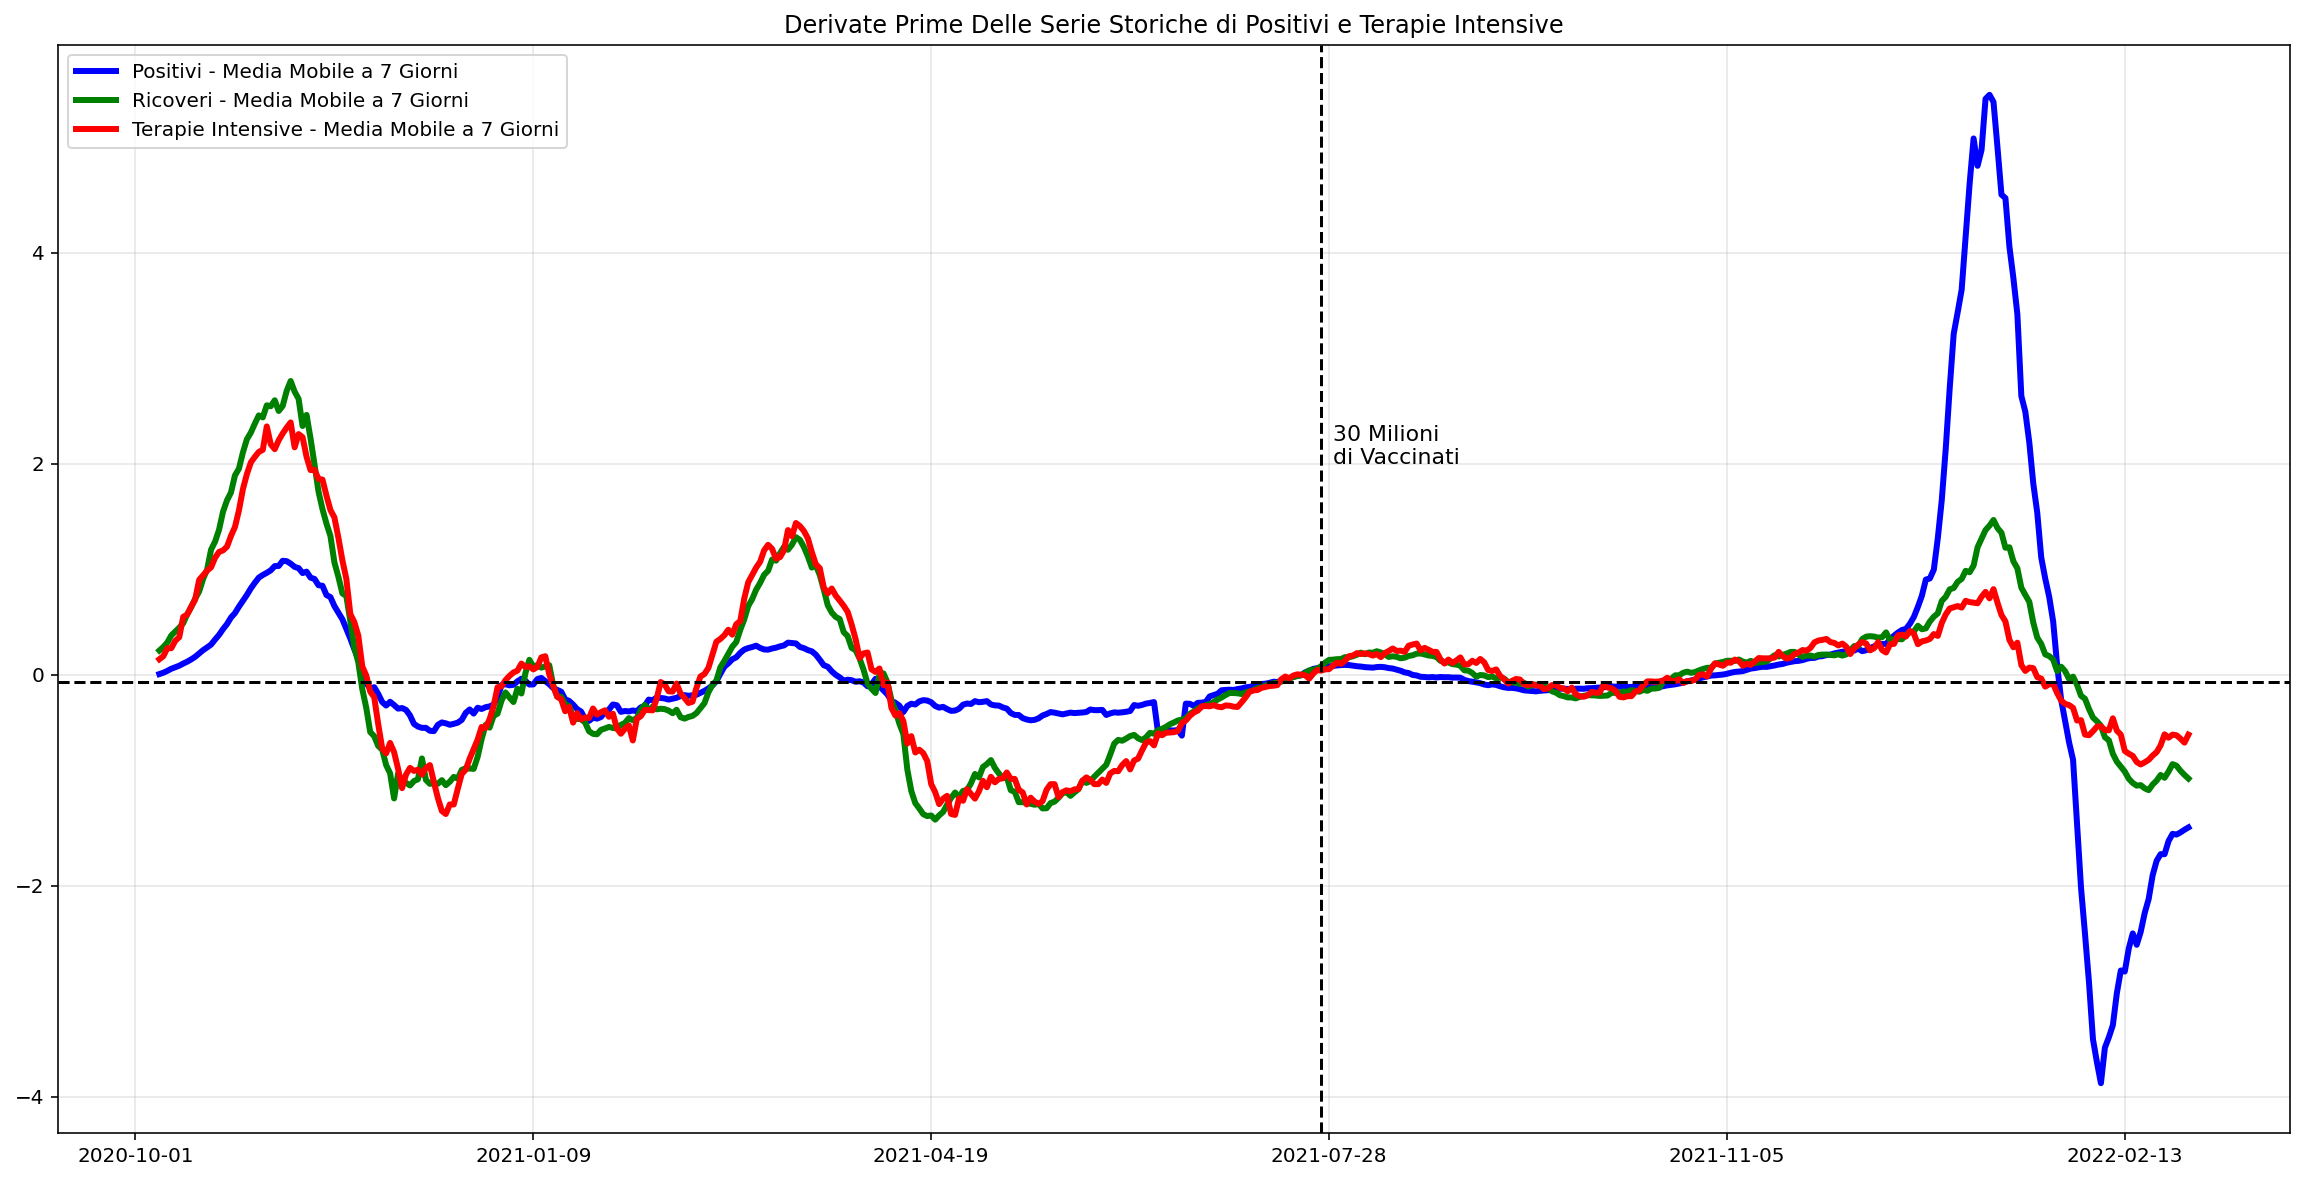

In [86]:
d_ti = ti.terapia_intensiva.diff()
d_osp = ti.ricoverati.diff()
d_deac = ti.deceduti.diff()
d2_ti = d_ti.diff()
std_zero = (0 - np.mean(d_pos)) / np.std(d_pos)

fig, ax = plt.subplots(figsize=(20,10))

std_scal(d_pos)[220:].rolling(7).mean().plot(ax=ax, linewidth=3, c = 'b', label = 'Positivi - Media Mobile a 7 Giorni')
std_scal(d_osp)[220:].rolling(7).mean().plot(ax=ax, linewidth=3, c = 'g', label = 'Ricoveri - Media Mobile a 7 Giorni')
std_scal(d_ti)[220:].rolling(7).mean().plot(ax=ax, linewidth=3, c = 'r', label = 'Terapie Intensive - Media Mobile a 7 Giorni')
_ = ax.legend()
_ = ax.axhline(std_zero, c='k', linestyle='--')
_ = ax.grid(alpha=.3)
_ = ax.set_xlabel('')
_ = ax.set_ylabel('')
_ = ax.set_title('Derivate Prime Delle Serie Storiche di Positivi e Terapie Intensive')
_ = ax.axvline(trentaM-220, c = 'k', linestyle = '--')
_ = ax.text(trentaM-220+3, 2, '30 Milioni \ndi Vaccinati', fontsize = 11)

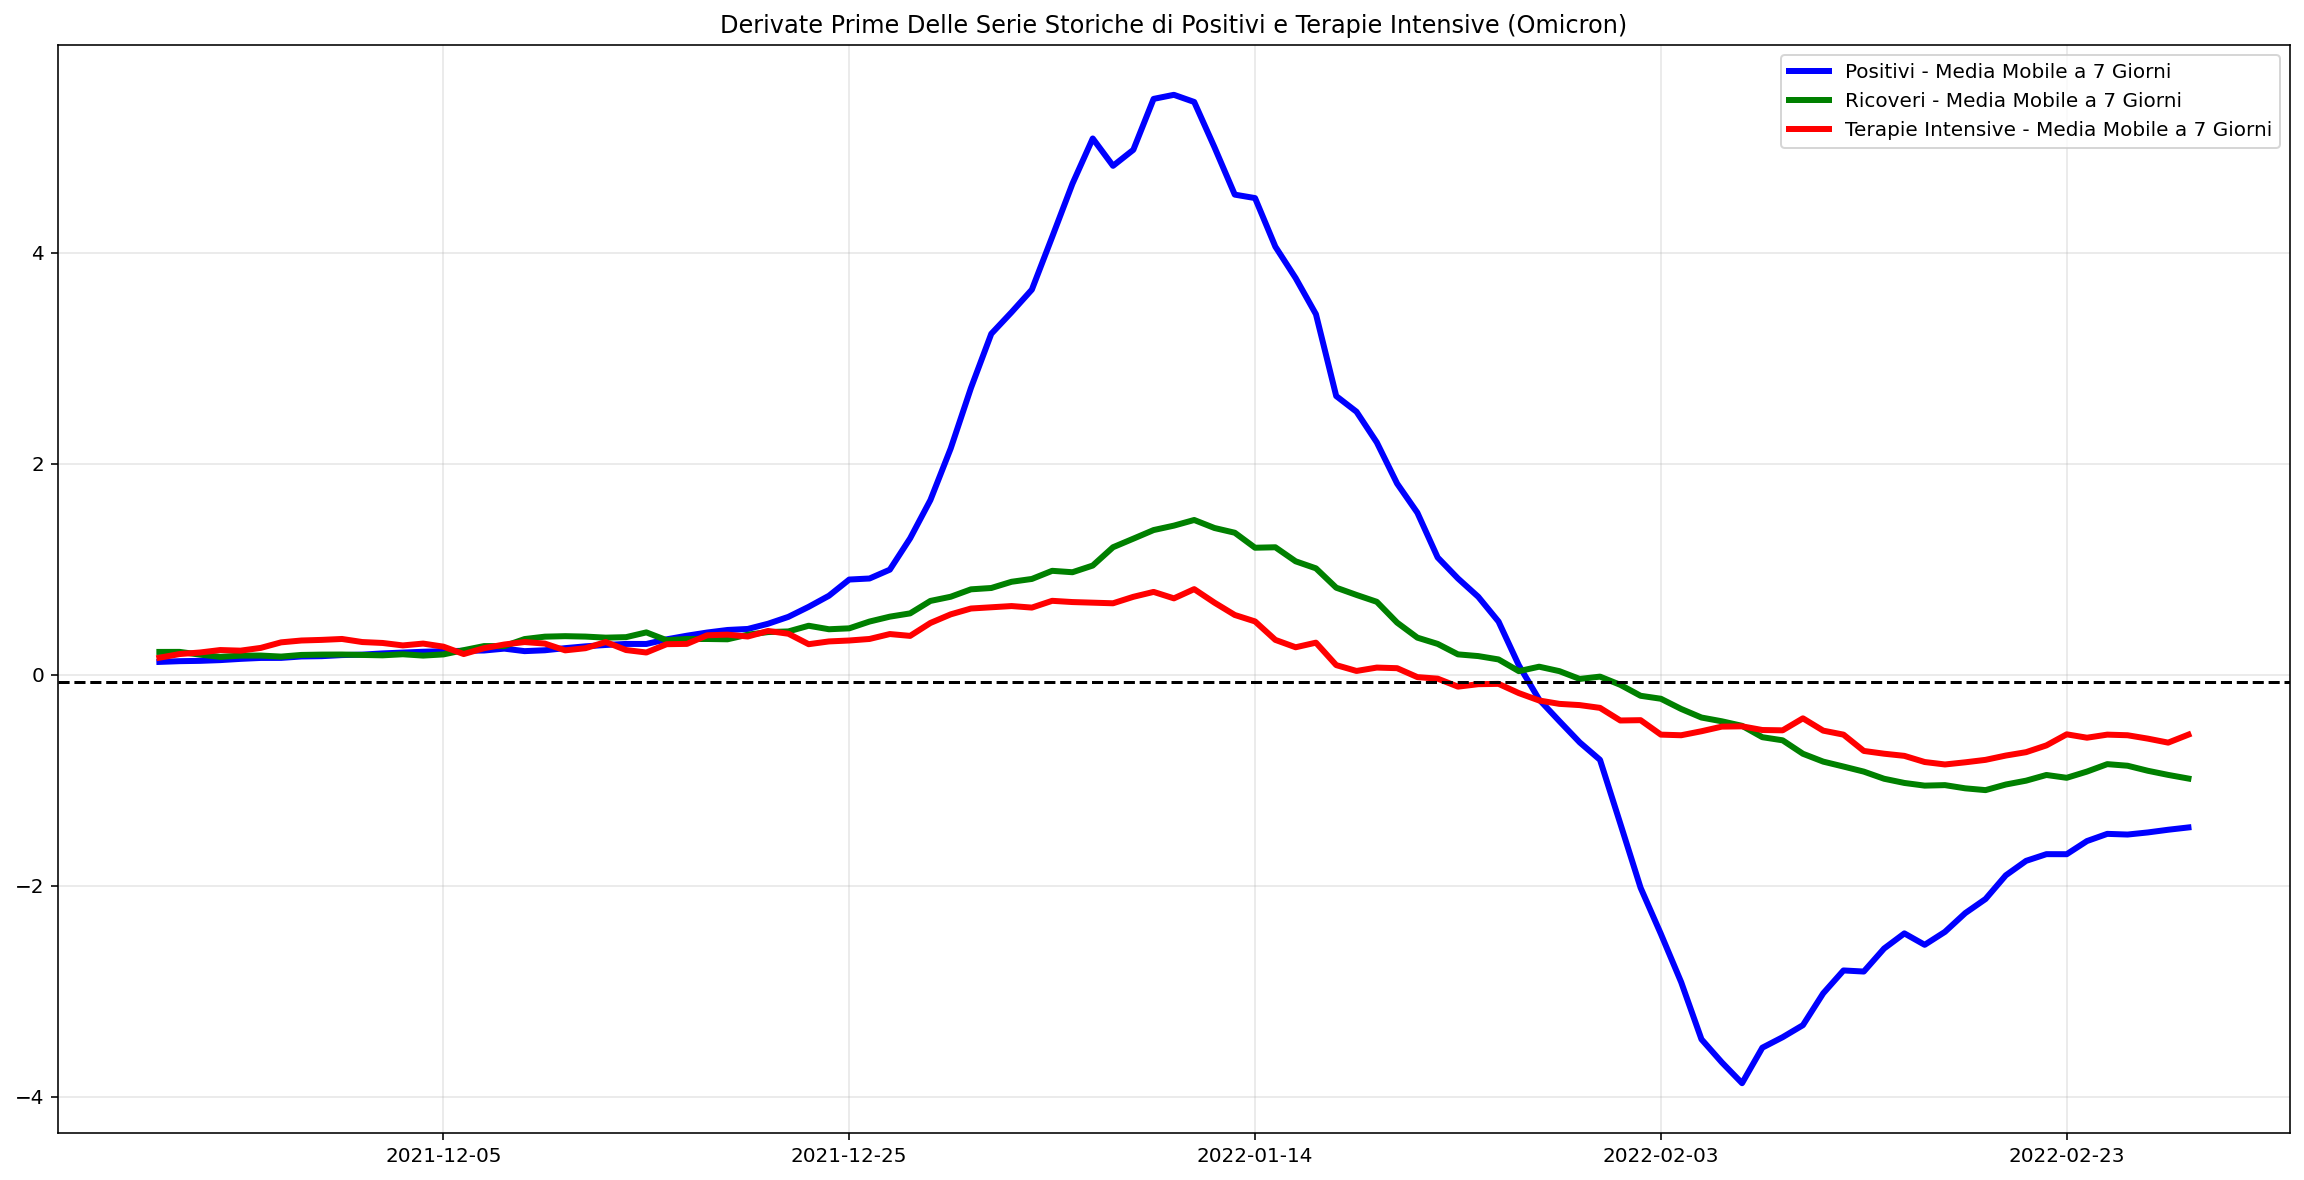

In [87]:
fig, ax = plt.subplots(figsize=(20,10))

std_scal(d_pos)[630:].rolling(7).mean().plot(ax=ax, linewidth=3, c = 'b', label = 'Positivi - Media Mobile a 7 Giorni')
std_scal(d_osp)[630:].rolling(7).mean().plot(ax=ax, linewidth=3, c = 'g', label = 'Ricoveri - Media Mobile a 7 Giorni')
std_scal(d_ti)[630:].rolling(7).mean().plot(ax=ax, linewidth=3, c = 'r', label = 'Terapie Intensive - Media Mobile a 7 Giorni')
_ = ax.legend()
_ = ax.axhline(std_zero, c='k', linestyle='--')
_ = ax.grid(alpha=.3)
_ = ax.set_xlabel('')
_ = ax.set_ylabel('')
_ = ax.set_title('Derivate Prime Delle Serie Storiche di Positivi e Terapie Intensive (Omicron)')

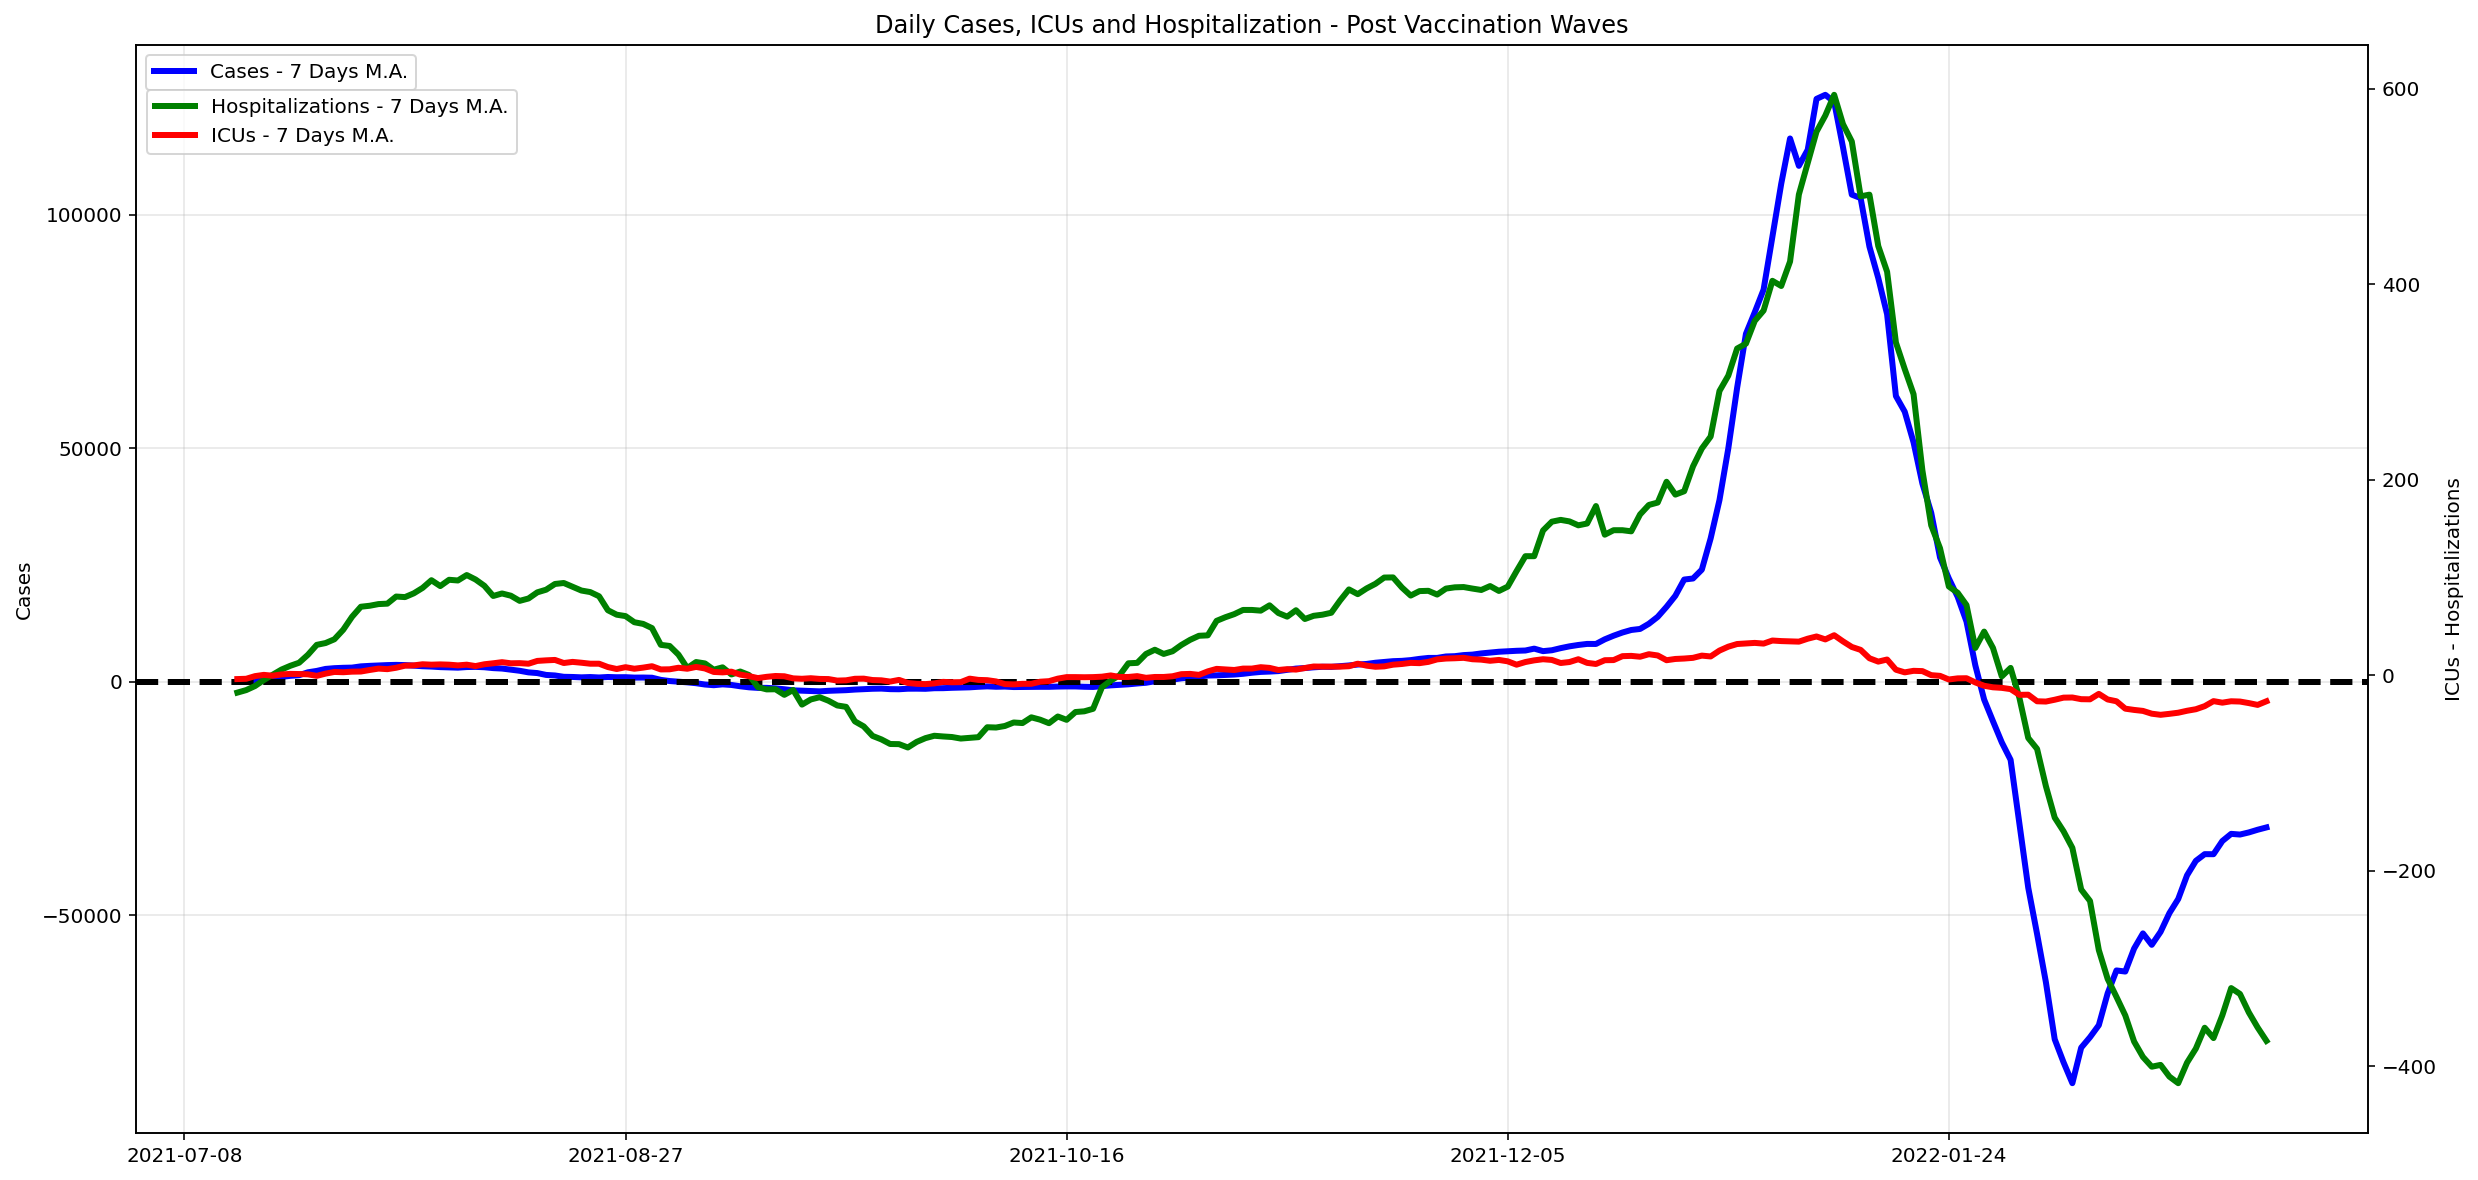

In [88]:
fig, ax = plt.subplots(figsize=(20,10))

cax = ax.twinx()
d_pos[500:].rolling(7).mean().plot(ax=ax, linewidth=3, c = 'b', label = 'Cases - 7 Days M.A.')
d_osp[500:].rolling(7).mean().plot(ax=cax, linewidth=3, c = 'g', label = 'Hospitalizations - 7 Days M.A.')
d_ti[500:].rolling(7).mean().plot(ax=cax, linewidth=3, c = 'r', label = 'ICUs - 7 Days M.A.')
_ = ax.axhline(0, c = 'k', linewidth = 3, linestyle = '--')
_ = ax.grid(alpha = .3)
_ = ax.set_xlabel('')
_ = ax.set_ylabel('Cases')
_ = cax.set_ylabel('ICUs - Hospitalizations')
_ = ax.legend(loc = 'upper left')
_ = cax.legend(loc = (0.005, .9))
_ = ax.set_title('Daily Cases, ICUs and Hospitalization - Post Vaccination Waves')

In [89]:
start = ti.index[0]

ti['days_since_start'] = diff_dates(pd.to_datetime(start), pd.to_datetime(ti.index), days = True)
first_wave = ti.iloc[:round(ti.shape[0]/2)].reset_index()
second_wave = ti.iloc[-round(ti.shape[0]/2):].reset_index()

In [90]:
fw_start = first_wave.data[0]
sw_start = second_wave.data[0]
first_wave.days_since_start = diff_dates(pd.to_datetime(fw_start), pd.to_datetime(first_wave.data), days = True)
second_wave.days_since_start = diff_dates(pd.to_datetime(sw_start), pd.to_datetime(second_wave.data), days = True)

In [91]:
d_ti_fw = first_wave.terapia_intensiva.diff()
d_ti_sw = second_wave.terapia_intensiva.diff()

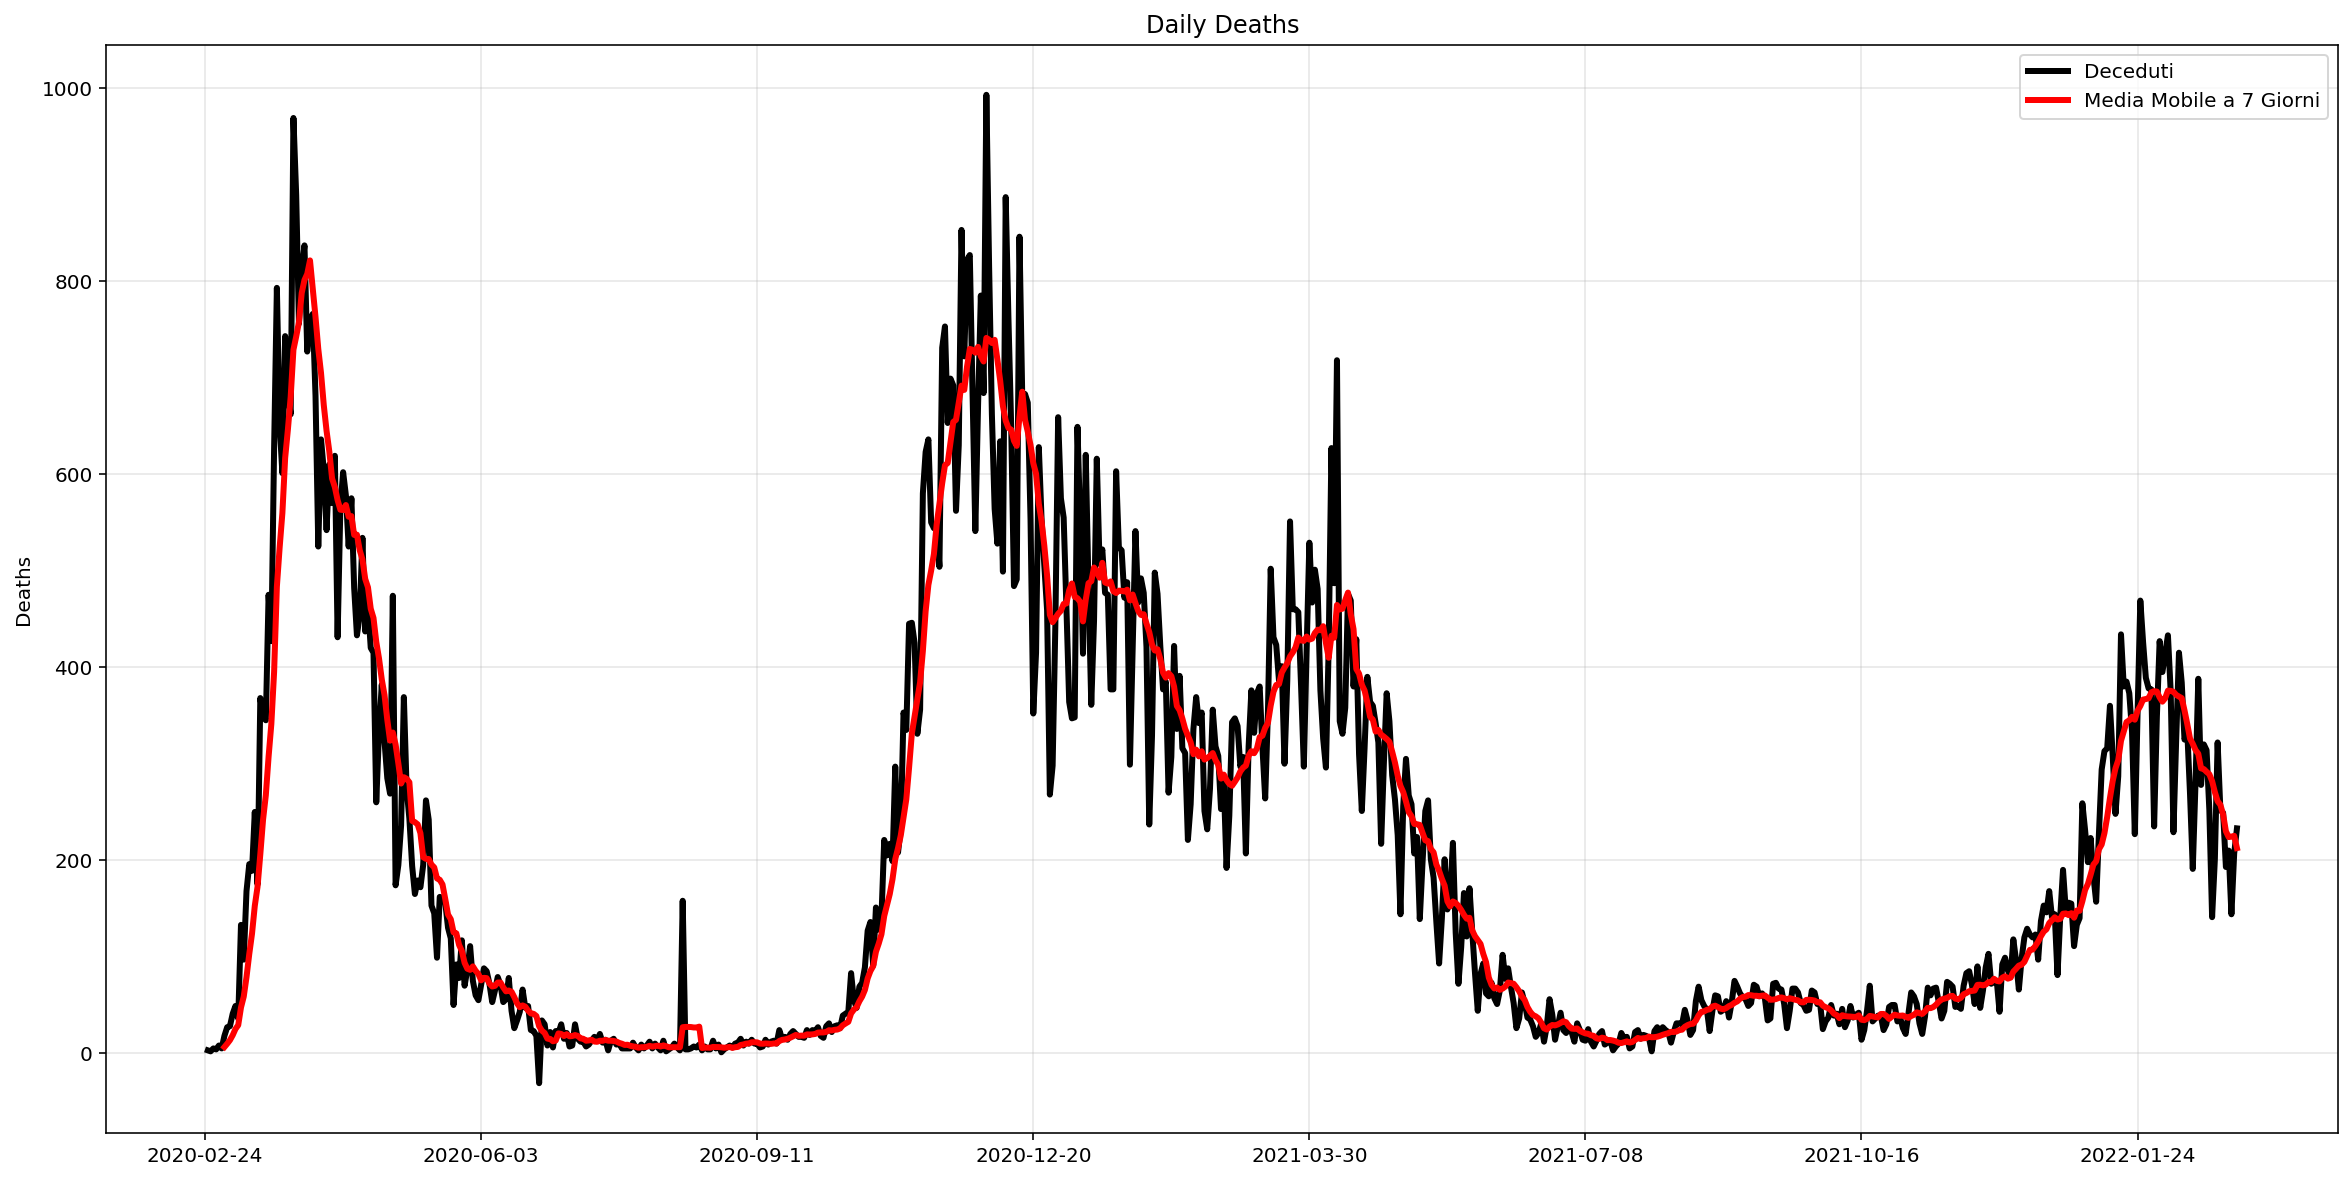

In [92]:
fig, ax = plt.subplots(figsize = (20,10))

ti.deceduti.diff().plot(ax = ax, c = 'k', linewidth = 3, label = 'Deceduti')
ti.deceduti.rolling(7).mean().diff().plot(ax = ax, c = 'r', linewidth = 3, label = 'Media Mobile a 7 Giorni')
_ = ax.grid(alpha = .3)
_ = ax.legend()
_ = ax.set_xlabel('')
_ = ax.set_ylabel('Deaths')
_ = ax.set_title('Daily Deaths')

In [93]:
d_dec_fw = first_wave.deceduti.diff()
d_dec_sw = second_wave.deceduti.diff()

In [94]:
same_start = True

if same_start:
    y21 = y21[y21.days_since_start >= y21.days_since_start[54]]
    y21 = y21.reset_index(drop = True)
    y21.days_since_start = np.arange(len(y21))
    y21 = y21.set_index('data')

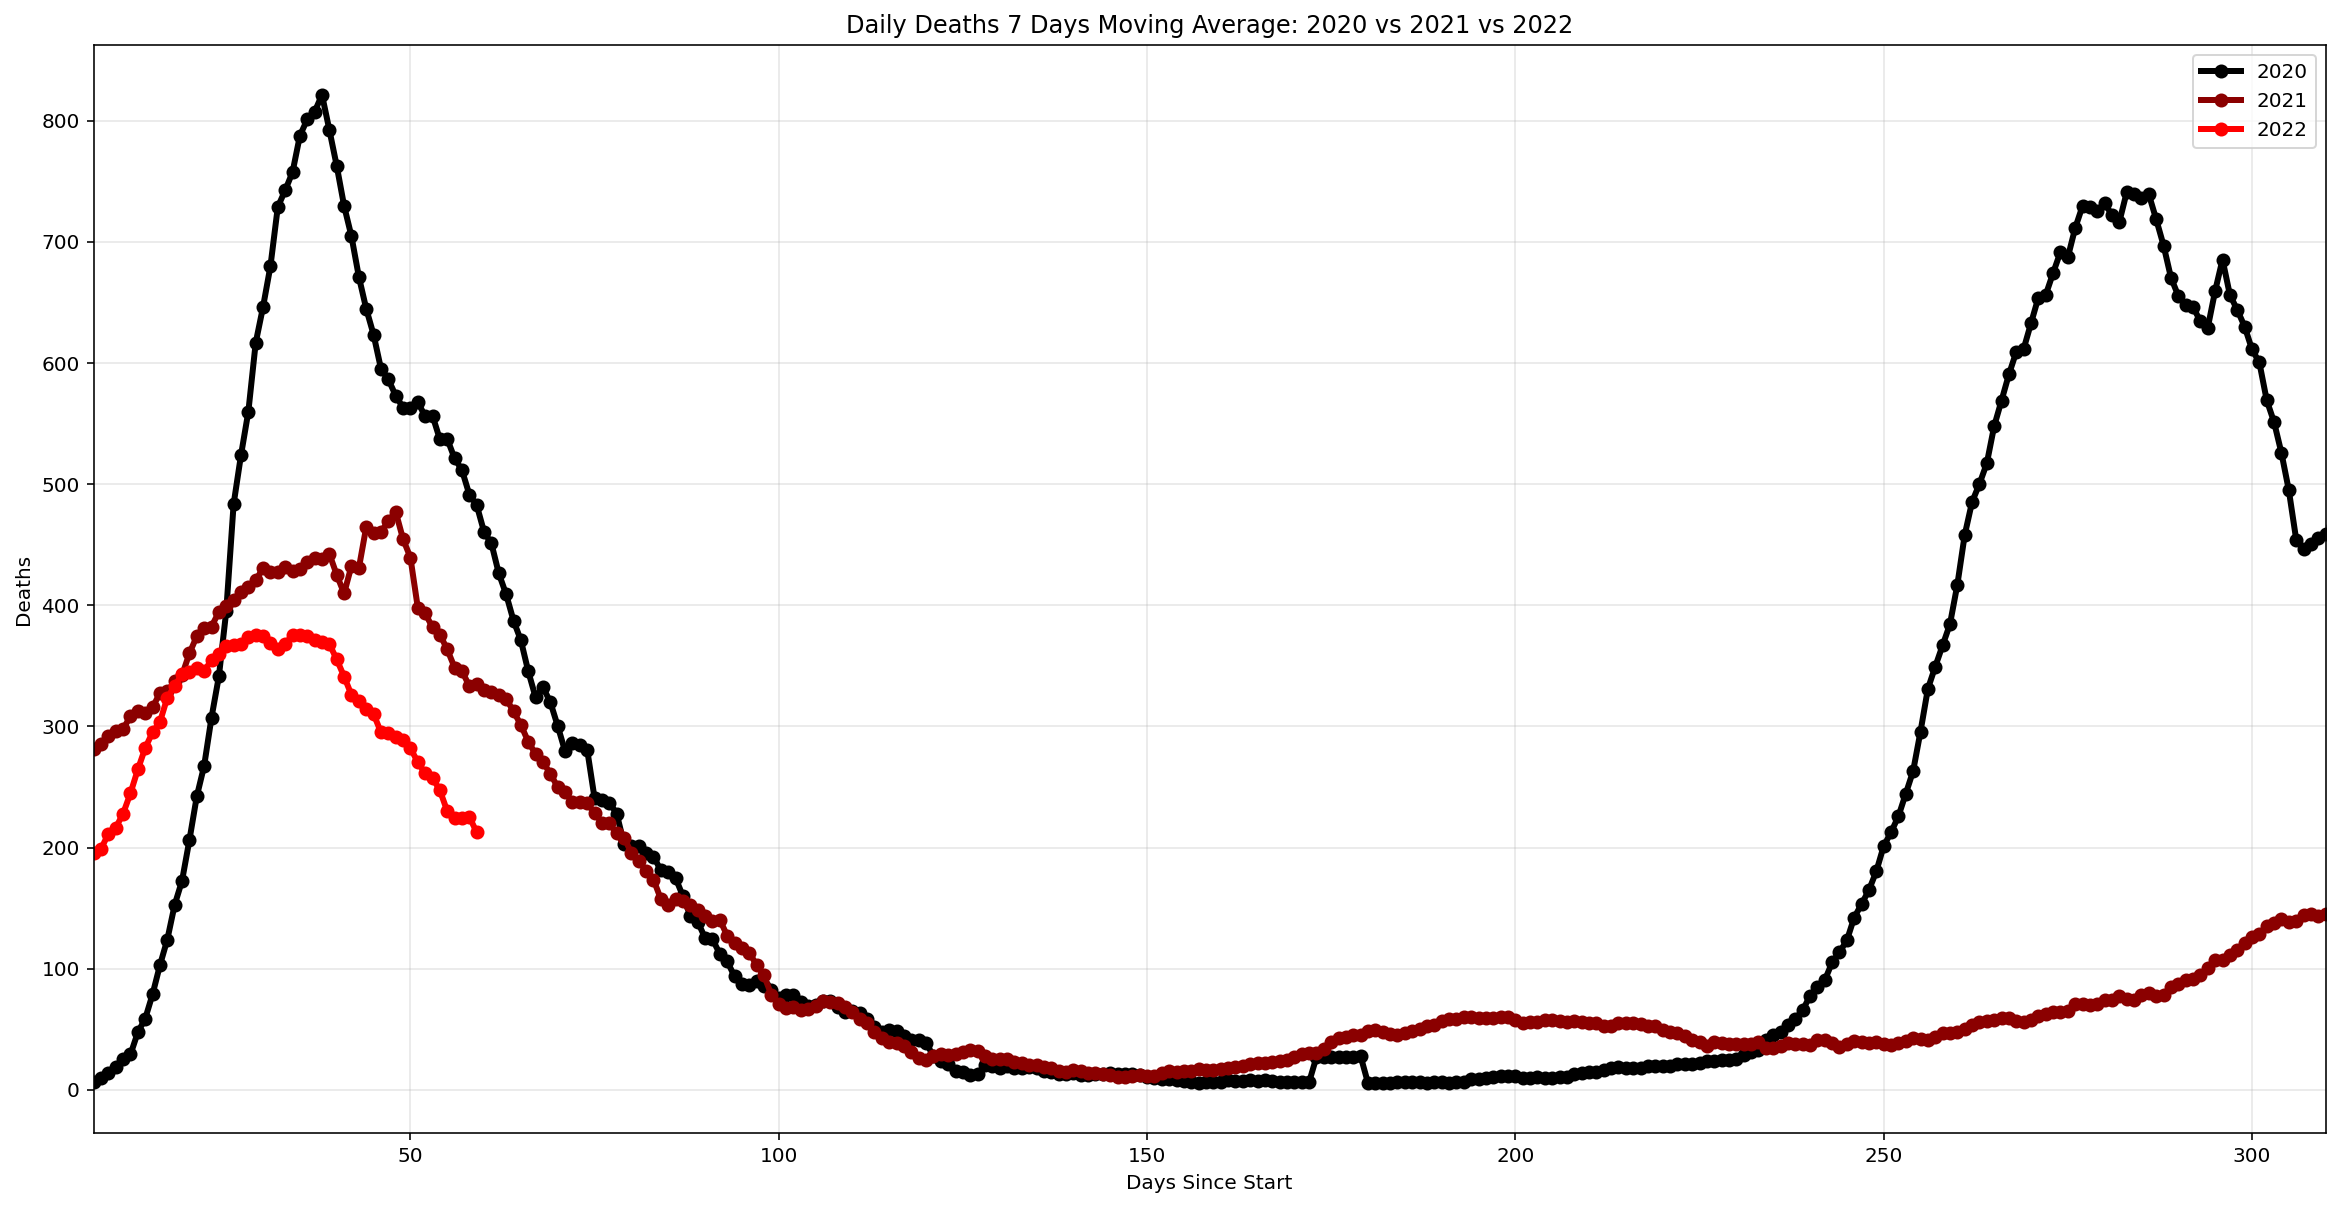

In [109]:
d_dec_fw = y20.deceduti.diff()
d_dec_sw = y21.deceduti.diff()
d_dec_tw = y22.deceduti.diff()

y21_end = y21.days_since_start[-1]
fig, ax = plt.subplots(figsize=(20,10))

d_dec_fw_rm = pd.Series(d_dec_fw).rolling(7).mean()
d_dec_sw_rm = pd.Series(d_dec_sw).rolling(7).mean()
d_dec_tw_rm = pd.Series(d_dec_tw).rolling(7).mean()
ax.plot(y20.days_since_start, d_dec_fw_rm, linewidth = 3, c = 'k', marker = 'o', label = '2020')
ax.plot(y21.days_since_start, d_dec_sw_rm, linewidth = 3, c = 'darkred', marker = 'o', label = '2021')
ax.plot(y22.days_since_start, d_dec_tw_rm, linewidth = 3, c = 'r', marker = 'o', label = '2022')
# _ = ax.fill_between(y21.days_since_start, d_dec_fw_rm[:y21_end+1], d_dec_sw_rm, color = 'k', alpha=.4, label = 'Differenza Tassi di Crescita')
_ = ax.grid(alpha = .3)
_ = ax.legend()
_ = ax.set_xlim([7, y21.days_since_start[-1]])
_ = ax.set_xlabel('Days Since Start')
_ = ax.set_ylabel('Deaths')
_ = ax.set_title('Daily Deaths 7 Days Moving Average: 2020 vs 2021 vs 2022')

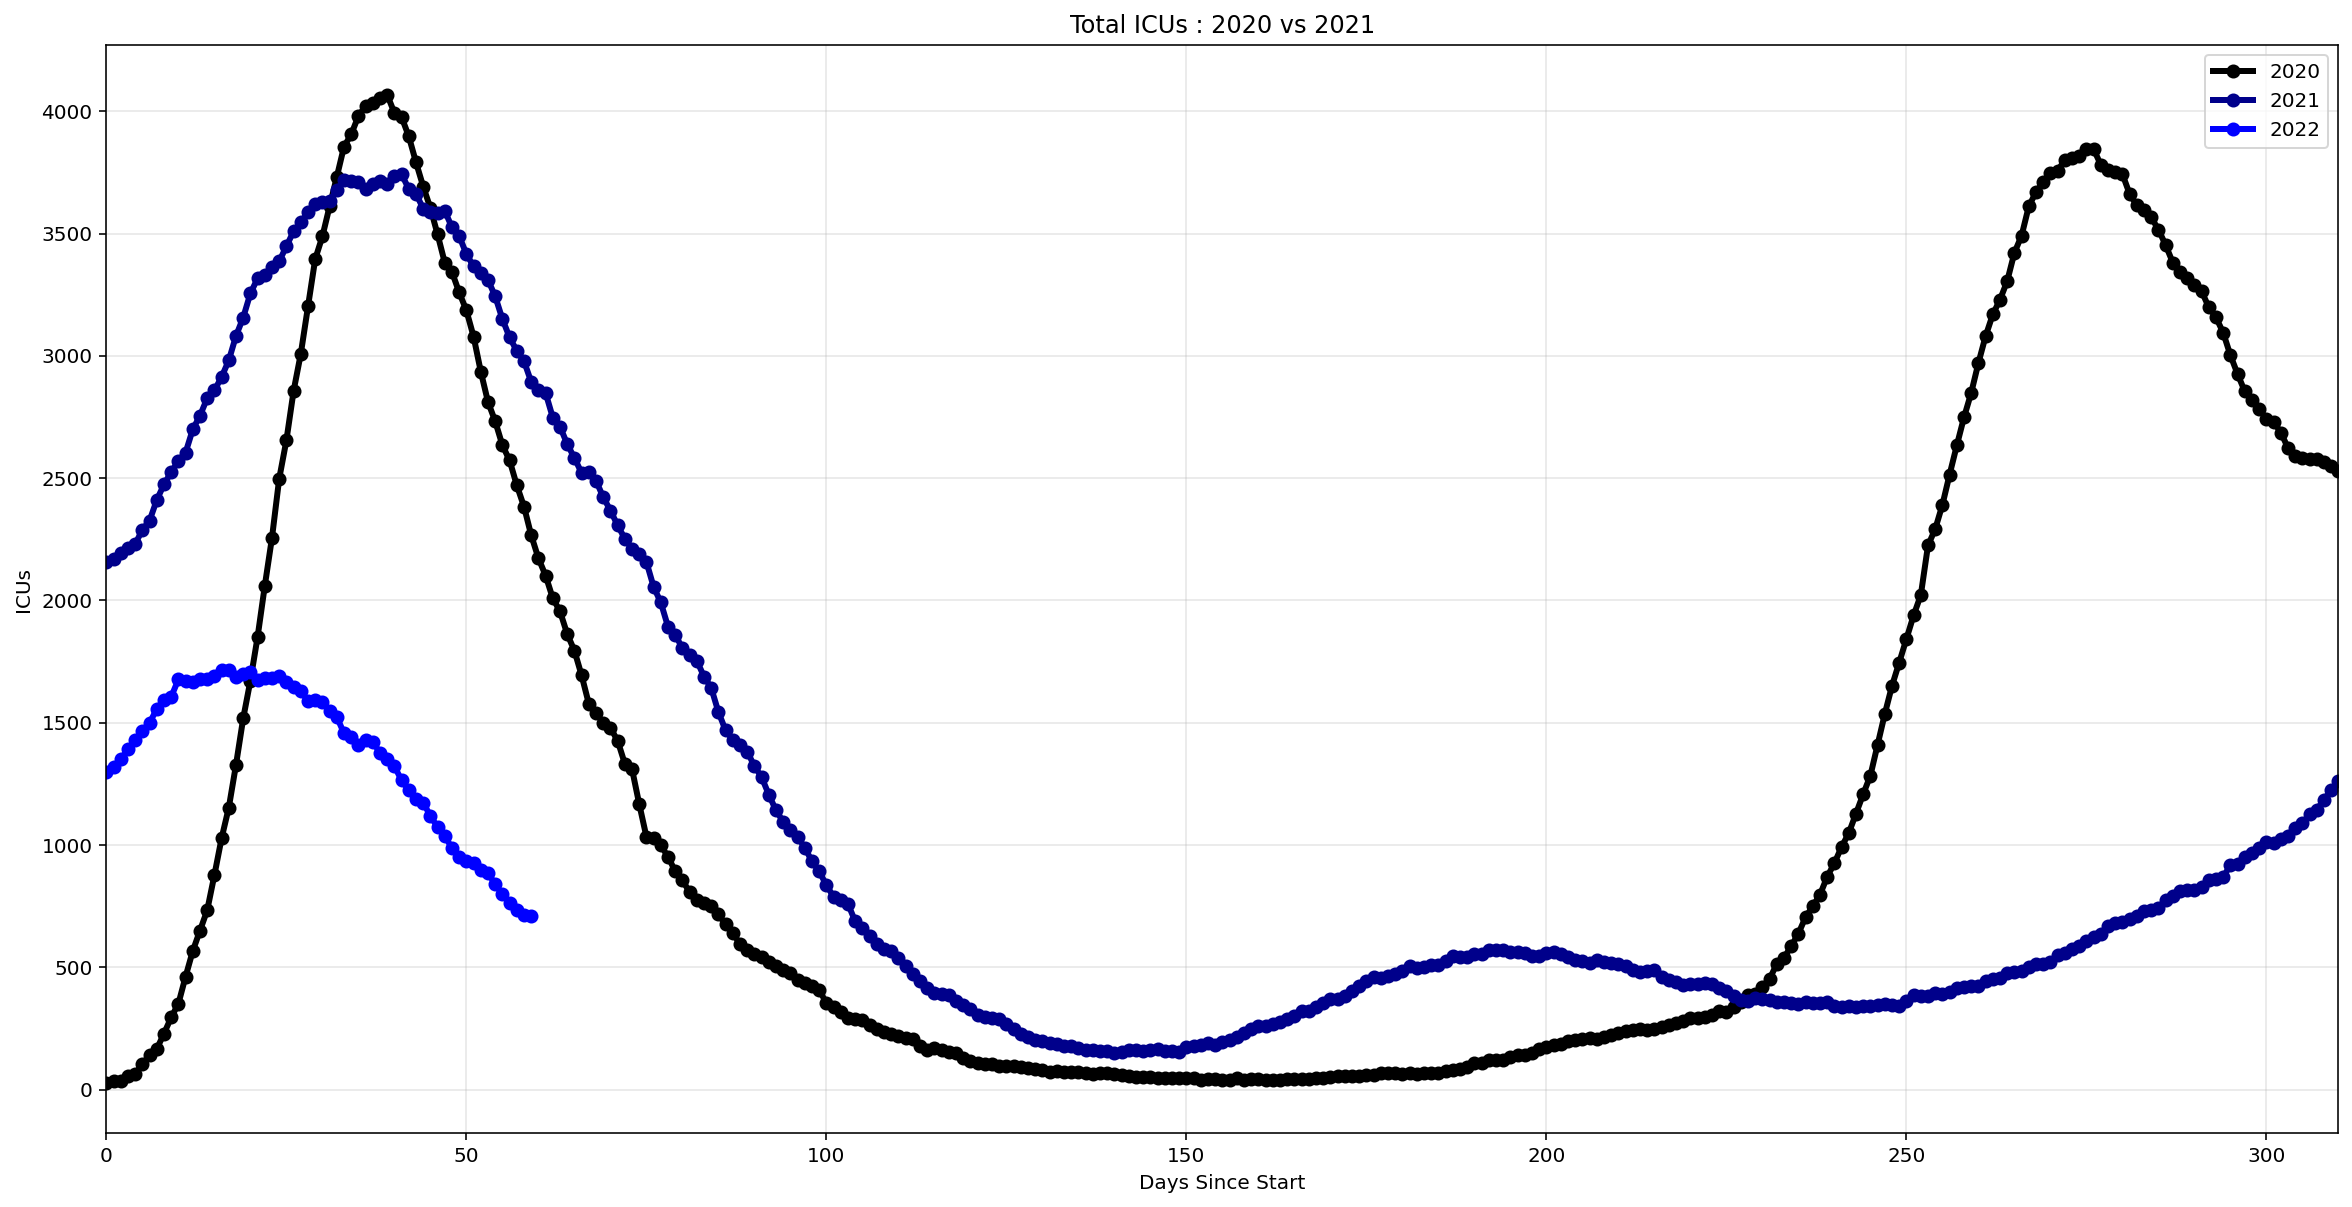

In [105]:
d_dec_fw = y20.terapia_intensiva
d_dec_sw = y21.terapia_intensiva
d_dec_tw = y22.terapia_intensiva

fig, ax = plt.subplots(figsize=(20,10))

d_dec_fw_rm = pd.Series(d_dec_fw)
d_dec_sw_rm = pd.Series(d_dec_sw)
d_dec_tw_rm = pd.Series(d_dec_tw)
ax.plot(y20.days_since_start, d_dec_fw_rm, linewidth = 3, c = 'k', marker = 'o', label = '2020')
ax.plot(y21.days_since_start, d_dec_sw_rm, linewidth = 3, c = 'darkblue', marker = 'o', label = '2021')
ax.plot(y22.days_since_start, d_dec_tw_rm, linewidth = 3, c = 'b', marker = 'o', label = '2022')
# _ = ax.fill_between(y21.days_since_start, d_dec_fw_rm[:y21_end+1], d_dec_sw_rm, color = 'b', alpha=.4, label = 'Differenza Tassi di Crescita')
_ = ax.grid(alpha = .3)
_ = ax.legend()
_ = ax.set_xlim([0, y21.days_since_start[-1]])
_ = ax.set_xlabel('Days Since Start')
_ = ax.set_ylabel('ICUs')
_ = ax.set_title('Total ICUs : 2020 vs 2021')

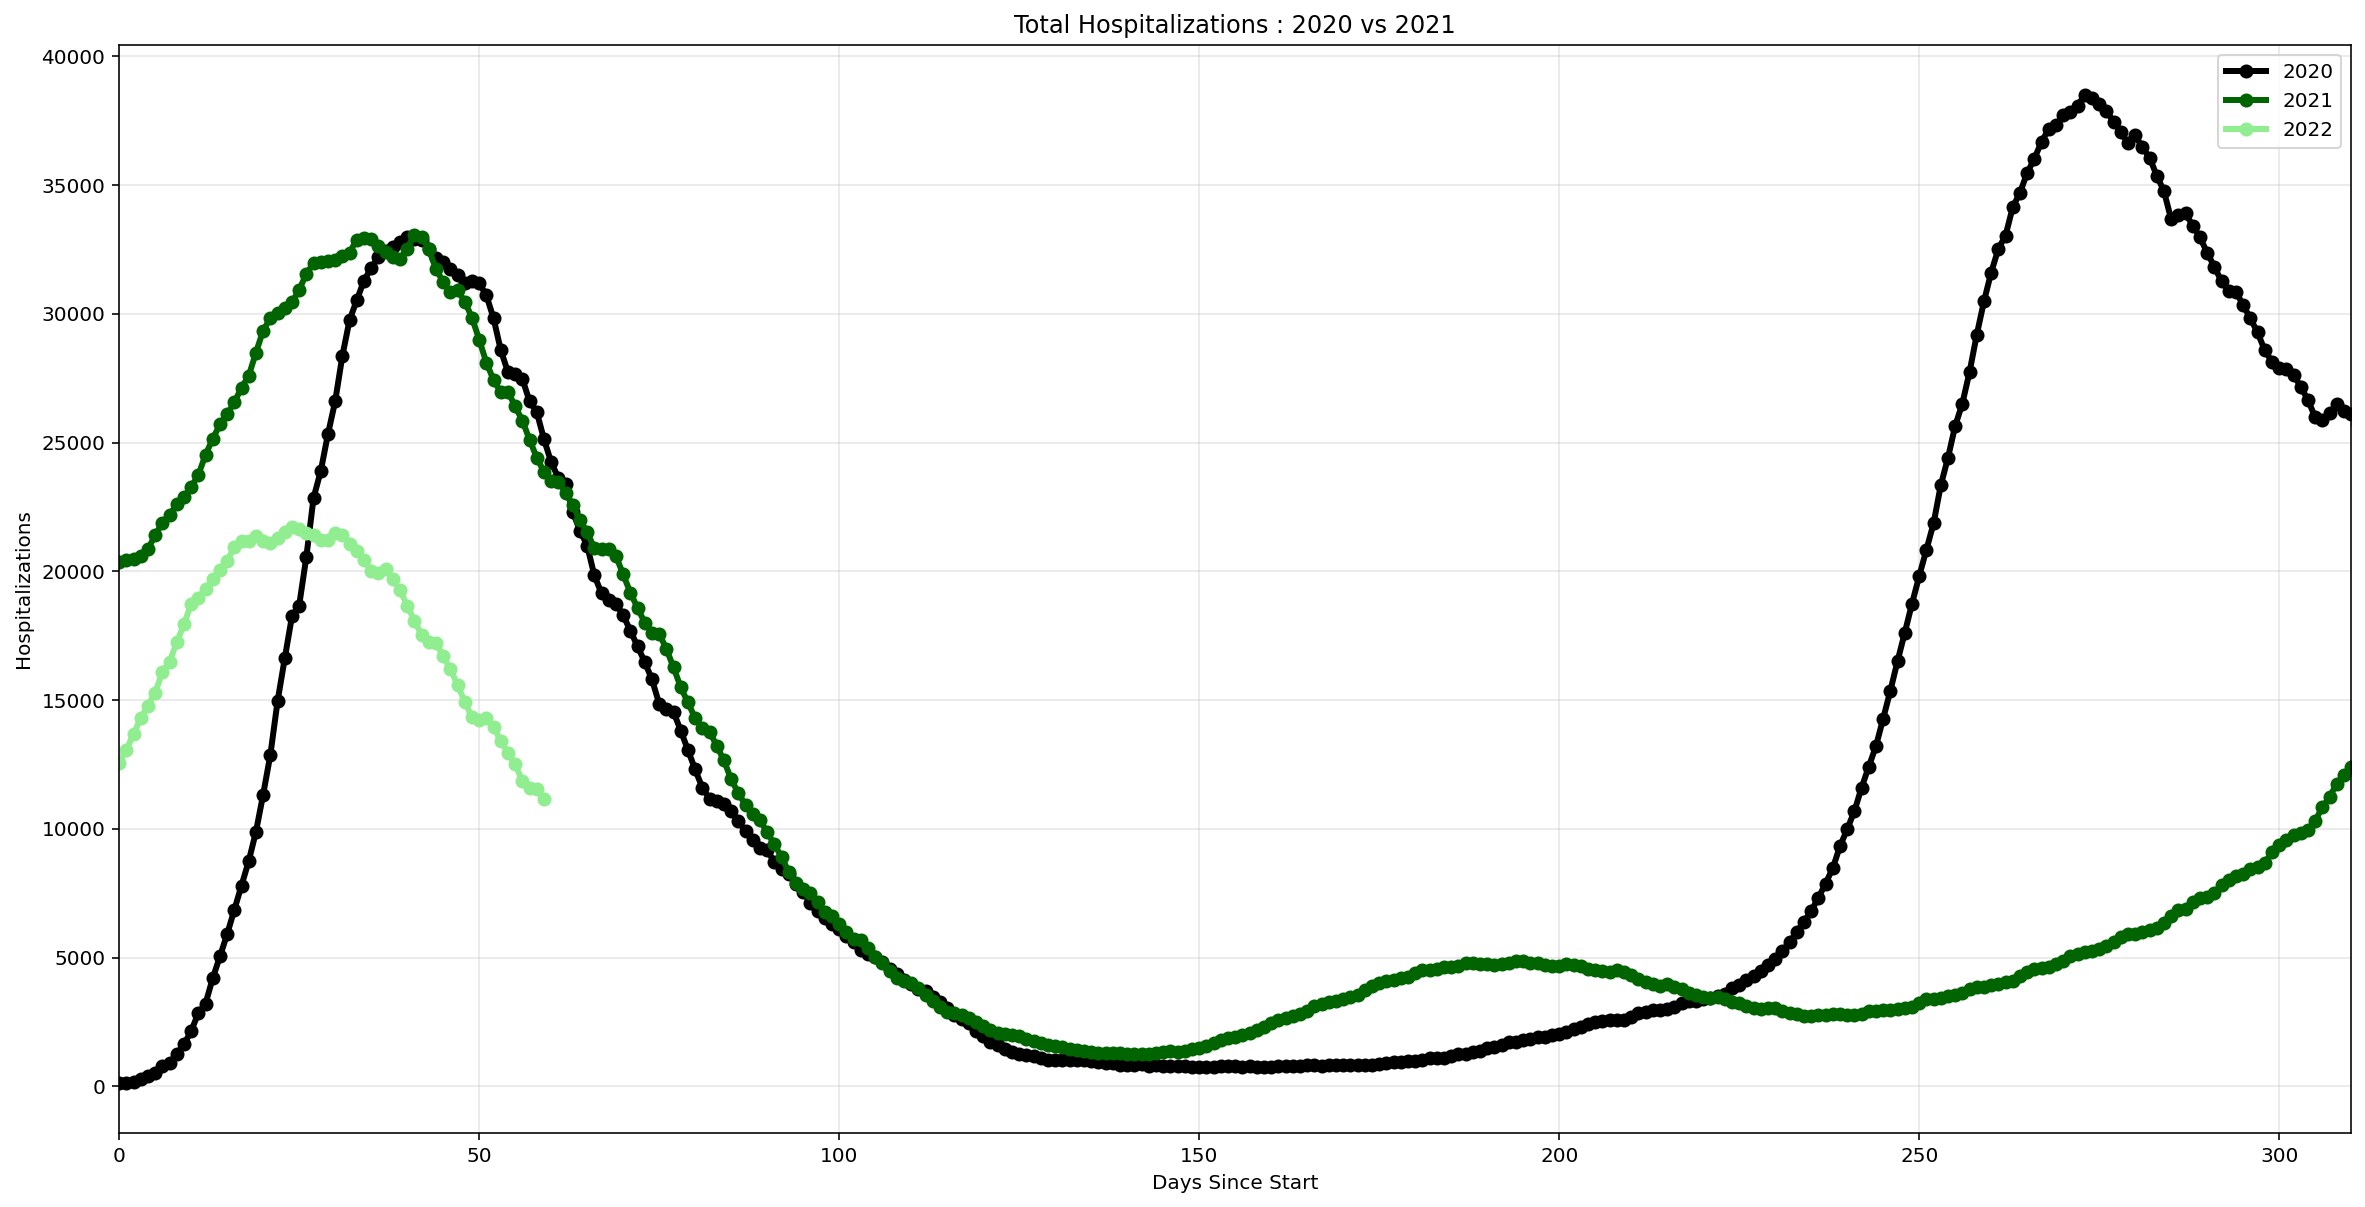

In [119]:
d_dec_fw = y20.ospedalizzati
d_dec_sw = y21.ospedalizzati
d_dec_tw = y22.ospedalizzati

fig, ax = plt.subplots(figsize=(20,10))

d_dec_fw_rm = pd.Series(d_dec_fw)
d_dec_sw_rm = pd.Series(d_dec_sw)
d_dec_tw_rm = pd.Series(d_dec_tw)
ax.plot(y20.days_since_start, d_dec_fw_rm, linewidth = 3, c = 'k', marker = 'o', label = '2020')
ax.plot(y21.days_since_start, d_dec_sw_rm, linewidth = 3, c = 'darkgreen', marker = 'o', label = '2021')
ax.plot(y22.days_since_start, d_dec_tw_rm, linewidth = 3, c = 'lightgreen', marker = 'o', label = '2022')
# _ = ax.fill_between(y21.days_since_start, d_dec_fw_rm[:y21_end+1], d_dec_sw_rm, color = 'b', alpha=.4, label = 'Differenza Tassi di Crescita')
_ = ax.grid(alpha = .3)
_ = ax.legend()
_ = ax.set_xlim([0, y21.days_since_start[-1]])
_ = ax.set_xlabel('Days Since Start')
_ = ax.set_ylabel('Hospitalizations')
_ = ax.set_title('Total Hospitalizations : 2020 vs 2021')

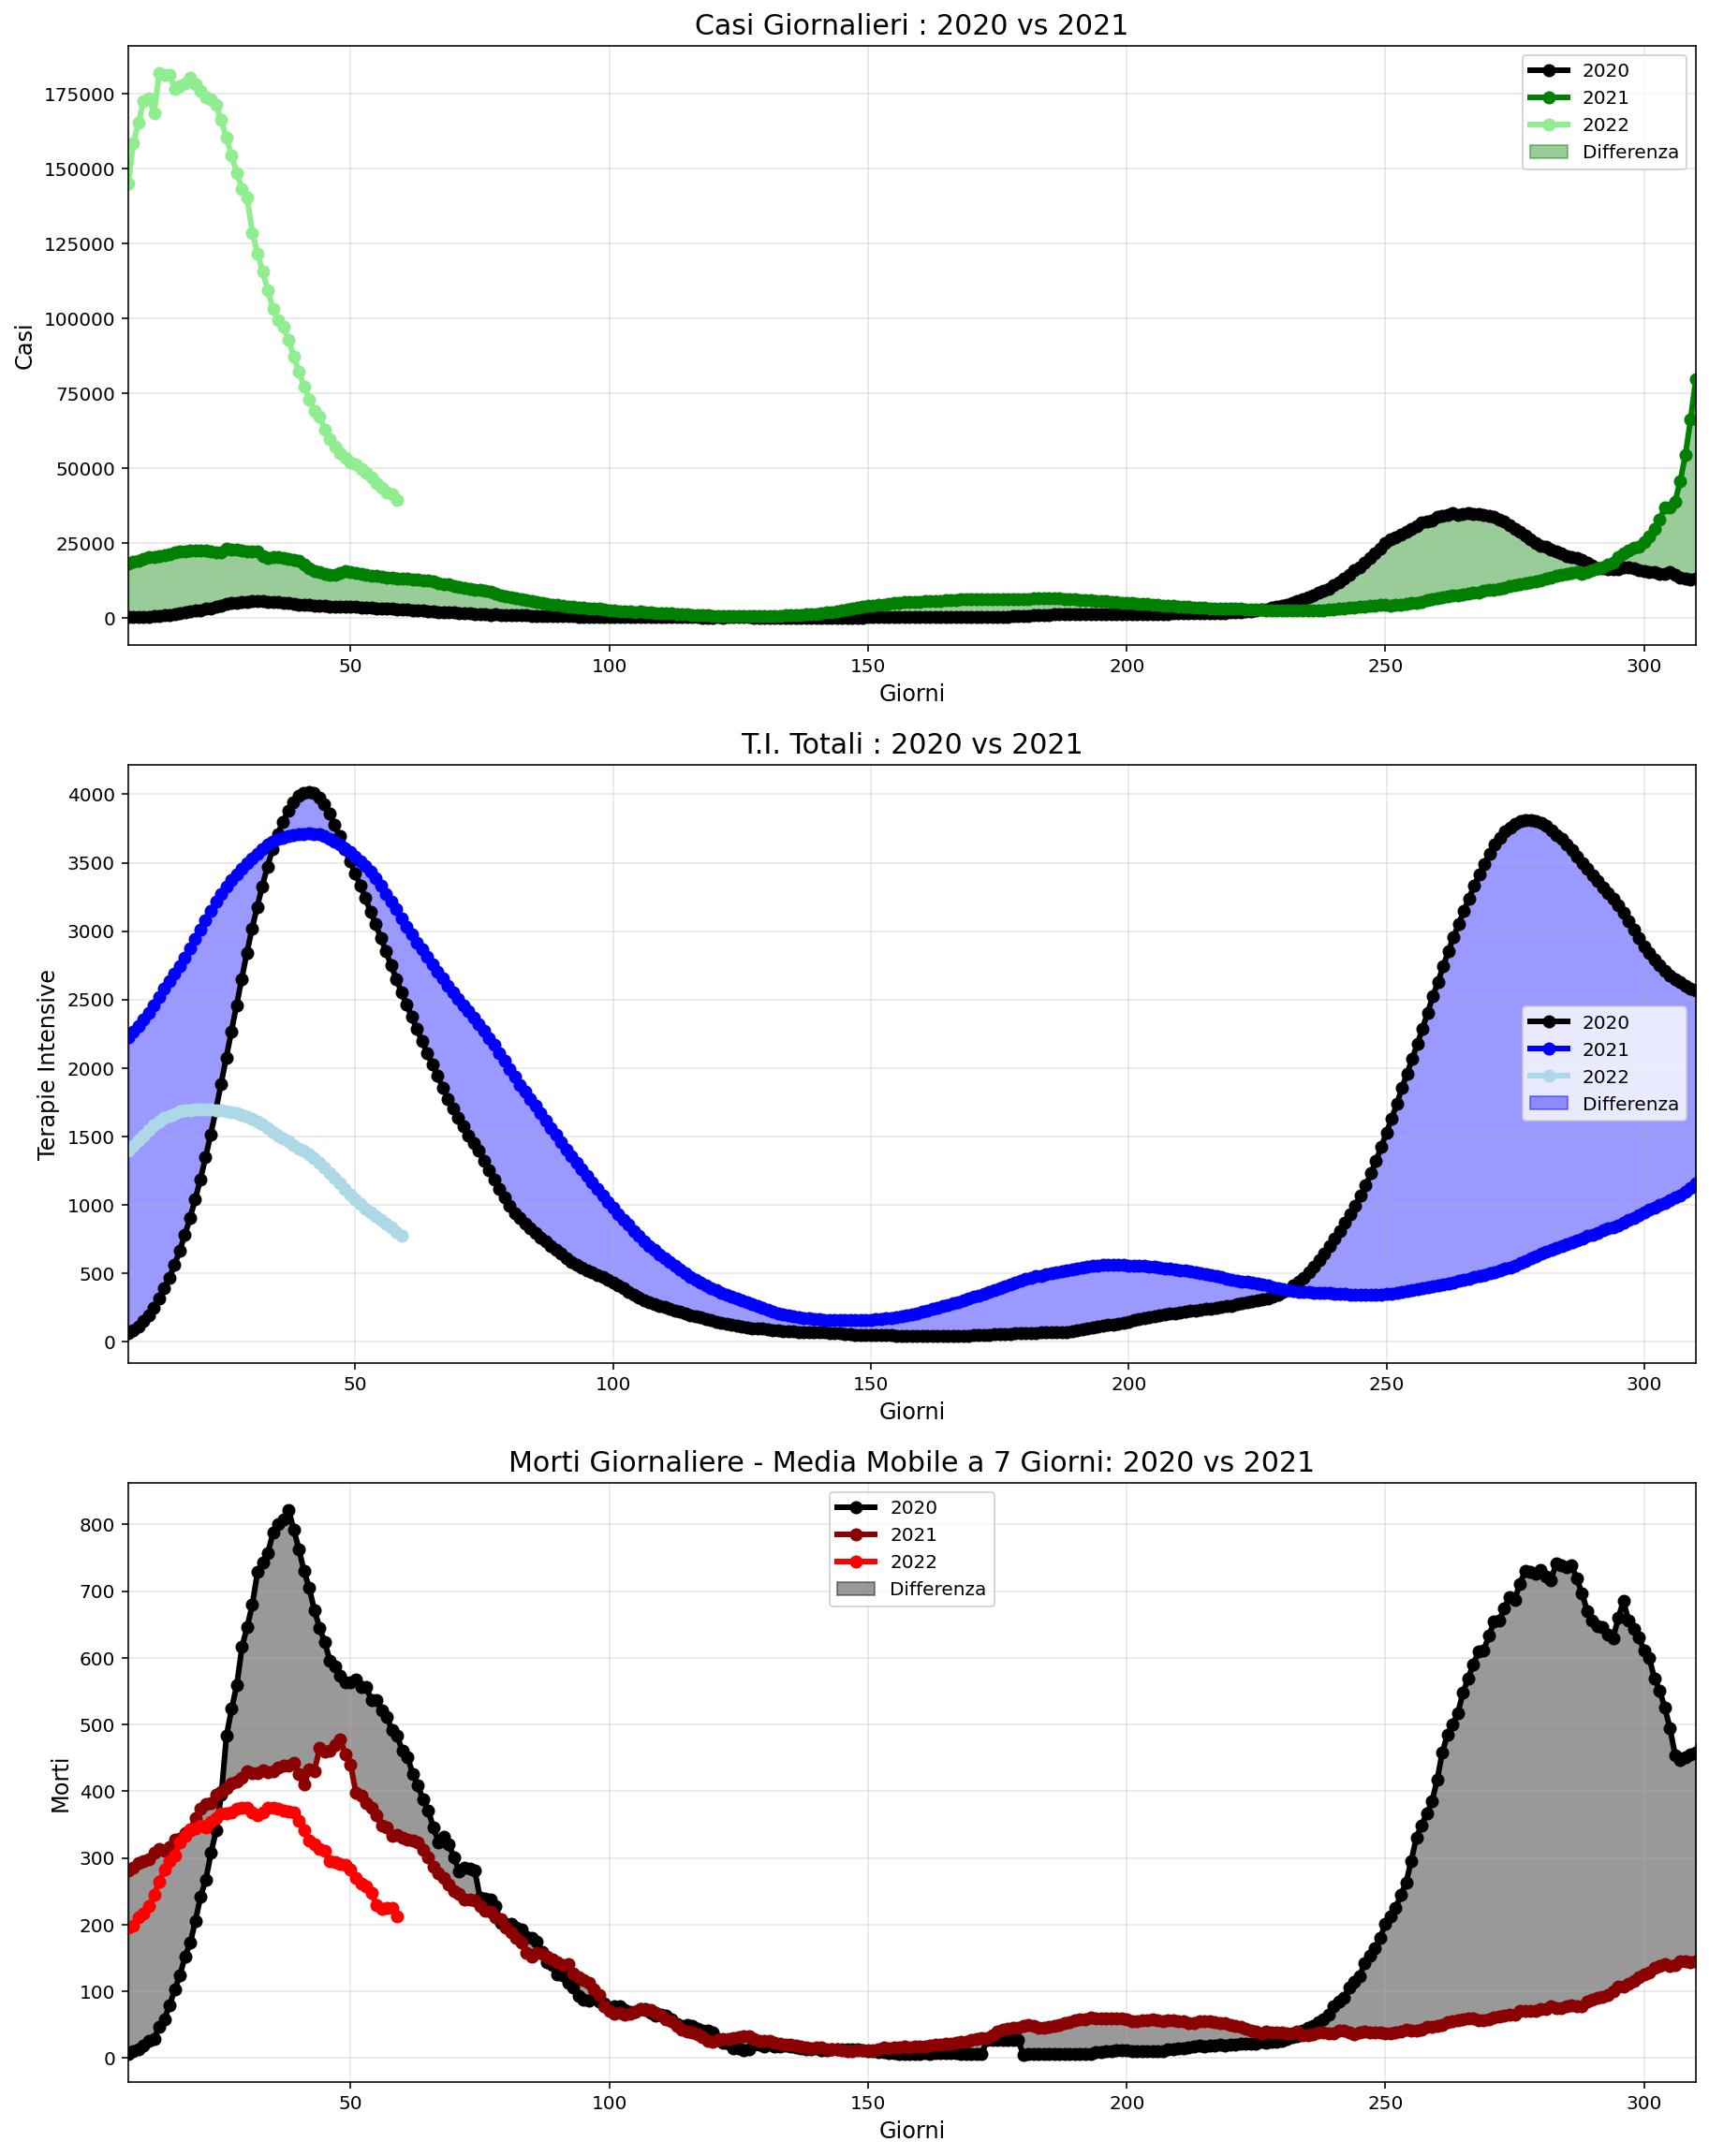

In [115]:
fig, ax = plt.subplots(3,1, figsize = (15, 20))

d_casi_fw = y20.totale_casi.diff().rolling(7).mean()
d_casi_sw = y21.totale_casi.diff().rolling(7).mean()
d_casi_tw = y22.totale_casi.diff().rolling(7).mean()

d_ti_fw = y20.terapia_intensiva
d_ti_sw = y21.terapia_intensiva
d_ti_tw = y22.terapia_intensiva

d_dec_fw = y20.deceduti.diff()
d_dec_sw = y21.deceduti.diff()
d_dec_tw = y22.deceduti.diff()

d_dec_fw_rm = pd.Series(d_dec_fw).rolling(7).mean()
d_dec_sw_rm = pd.Series(d_dec_sw).rolling(7).mean()
d_dec_tw_rm = pd.Series(d_dec_tw).rolling(7).mean()

d_ti_fw_rm = pd.Series(d_ti_fw).rolling(7).mean()
d_ti_sw_rm = pd.Series(d_ti_sw).rolling(7).mean()
d_ti_tw_rm = pd.Series(d_ti_tw).rolling(7).mean()

ax[0].plot(y20.days_since_start, d_casi_fw, linewidth = 3, c = 'k', marker = 'o', label = '2020')
ax[0].plot(y21.days_since_start, d_casi_sw, linewidth = 3, c = 'green', marker = 'o', label = '2021')
ax[0].plot(y22.days_since_start, d_casi_tw, linewidth = 3, c = 'lightgreen', marker = 'o', label = '2022')
ax[1].plot(y20.days_since_start, d_ti_fw_rm, linewidth = 3, c = 'k', marker = 'o', label = '2020')
ax[1].plot(y21.days_since_start, d_ti_sw_rm, linewidth = 3, c = 'b', marker = 'o', label = '2021')
ax[1].plot(y22.days_since_start, d_ti_tw_rm, linewidth = 3, c = 'lightblue', marker = 'o', label = '2022')
ax[2].plot(y20.days_since_start, d_dec_fw_rm, linewidth = 3, c = 'k', marker = 'o', label = '2020')
ax[2].plot(y21.days_since_start, d_dec_sw_rm, linewidth = 3, c = 'darkred', marker = 'o', label = '2021')
ax[2].plot(y22.days_since_start, d_dec_tw_rm, linewidth = 3, c = 'r', marker = 'o', label = '2022')
_ = ax[0].fill_between(y21.days_since_start, d_casi_fw[:y21_end+1], d_casi_sw, color='green', alpha=.4, label='Differenza')
_ = ax[1].fill_between(y21.days_since_start, d_ti_fw_rm[:y21_end+1], d_ti_sw_rm, color='b', alpha=.4, label='Differenza')
_ = ax[2].fill_between(y21.days_since_start, d_dec_fw_rm[:y21_end+1], d_dec_sw_rm, color='k', alpha=.4, label='Differenza')
_, _, _ = ax[0].grid(alpha = .3), ax[1].grid(alpha = .3), ax[2].grid(alpha = .3)
_, _, _ = ax[0].legend(), ax[1].legend(), ax[2].legend()
_ = ax[0].set_xlim([7, y21.days_since_start[-1]])
_, _ = ax[1].set_xlim([6, y21.days_since_start[-1]]), ax[2].set_xlim([7, y21.days_since_start[-1]])
_, _, _ = ax[0].set_xlabel('Giorni', fontsize = 12), ax[1].set_xlabel('Giorni', fontsize = 12), ax[2].set_xlabel('Giorni', fontsize = 12)
_, _, _ = ax[0].set_ylabel('Casi',fontsize = 12), ax[1].set_ylabel('Terapie Intensive', fontsize = 12), ax[2].set_ylabel('Morti', fontsize = 12)
_ = ax[0].set_title('Casi Giornalieri : 2020 vs 2021', fontsize = 15)
_, _ = ax[1].set_title('T.I. Totali : 2020 vs 2021', fontsize = 15), ax[2].set_title(
    'Morti Giornaliere - Media Mobile a 7 Giorni: 2020 vs 2021', fontsize = 15
)

_ = fig.savefig('waves_comparison.png')

#### 2. Some Basic Simulations ####

In [32]:
def exp_growth(x0,b,t): return x0*np.exp(b*t)
ti_sep = ti.loc['2020-10-01':]
start = ti_sep.index[0]

In [33]:
ti_sep['days_since_start'] = diff_dates(pd.to_datetime(start), pd.to_datetime(ti_sep.index), days = True)

C:\Users\PC\Anaconda3\envs\ps_eda_home\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


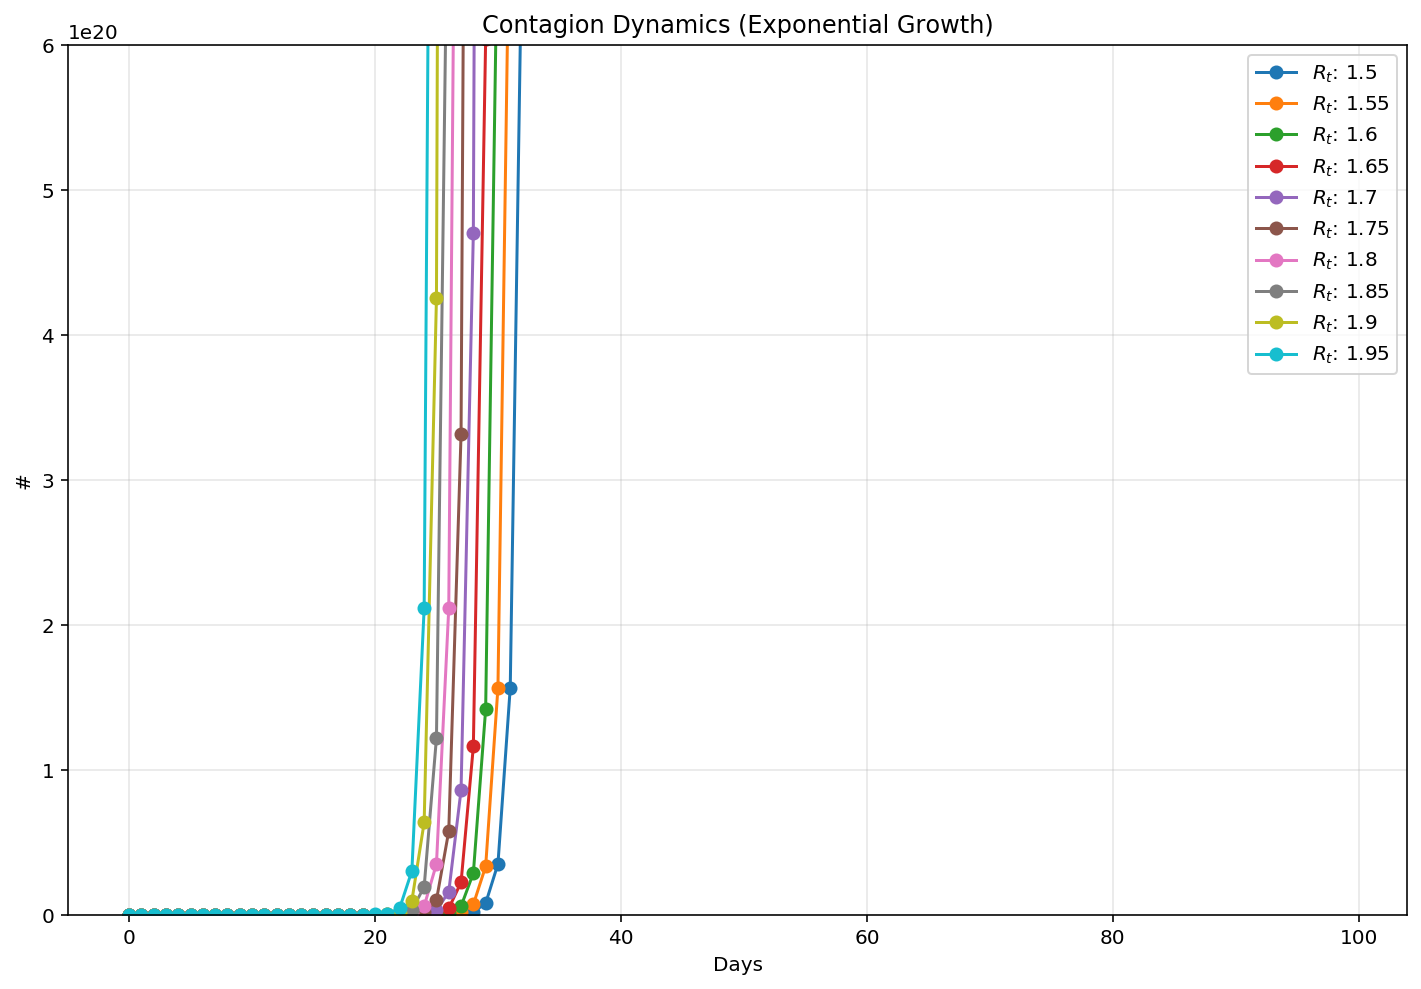

In [48]:
days = ti_sep.days_since_start

fig, ax = plt.subplots(figsize=(12,8))
for rt in np.arange(1.5,2,.05):
    cases = exp_growth(1,rt,days)
    ax.plot(days, cases, label = f'$R_t$: {round(rt,2)}', marker = 'o')
    ax.legend()
_ = ax.grid(alpha=.3)
_ = ax.set_xlabel('Days')
_ = ax.set_ylabel('#')
_ = ax.set_title('Contagion Dynamics (Exponential Growth)')
# _ = ax.set_xlim(-.5, len(days)-.5)

lim = True

if lim:
    daystart = 26 # set the day you want to see
    val = 0.01*1e8 # set the number of infections you want as limit
    # comment the lim you don't want to see
#     _ = ax.set_xlim(daystart,days[-10])
    _ = ax.set_ylim(0,6*1e20)

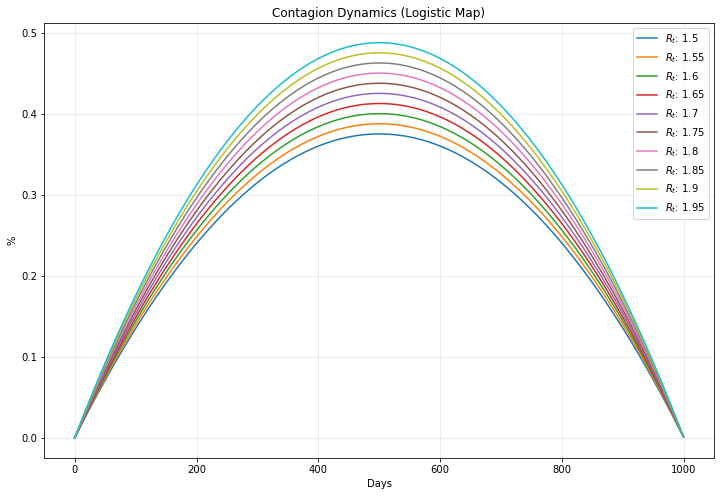

In [34]:
def logistic_map(xn,r): return np.dot(r,xn)*(np.ones(len(xn))-xn)

perc_inf = [i for i in np.arange(0,1,.001)]
days = [i for i in range(1000)]

cases = []
fig, ax = plt.subplots(figsize=(12,8))
for rt in np.arange(1.5,2,.05):
    case = logistic_map(perc_inf,rt)
    cases.append(case)
    ax.plot(days, case, label = f'$R_t$: {round(rt,2)}')
    ax.legend()
_ = ax.grid(alpha=.3)
_ = ax.set_xlabel('Days')
_ = ax.set_ylabel('%')
_ = ax.set_title('Contagion Dynamics (Logistic Map)')

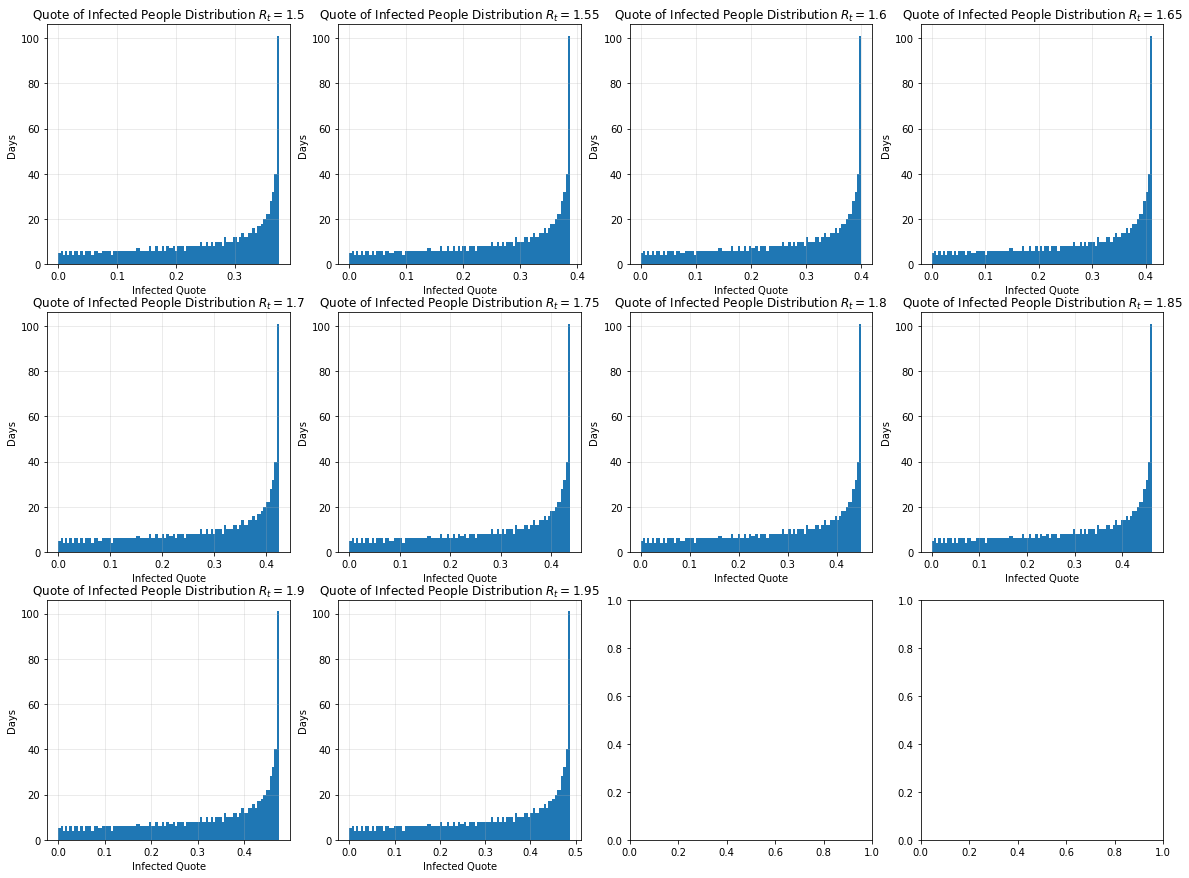

In [35]:
fig, ax = plt.subplots(3,4, figsize=(20,15))

flax = ax.flatten()
for n, cs in enumerate(cases):
    flax[n].hist(cs, bins=100)
    _ = flax[n].grid(alpha=.3)
    _ = flax[n].set_ylabel('Days')
    _ = flax[n].set_xlabel('Infected Quote')
    _ = flax[n].set_title(f'Quote of Infected People Distribution $R_t=${[round(rt,3) for rt in np.arange(1.5,2,.05)][n]}')

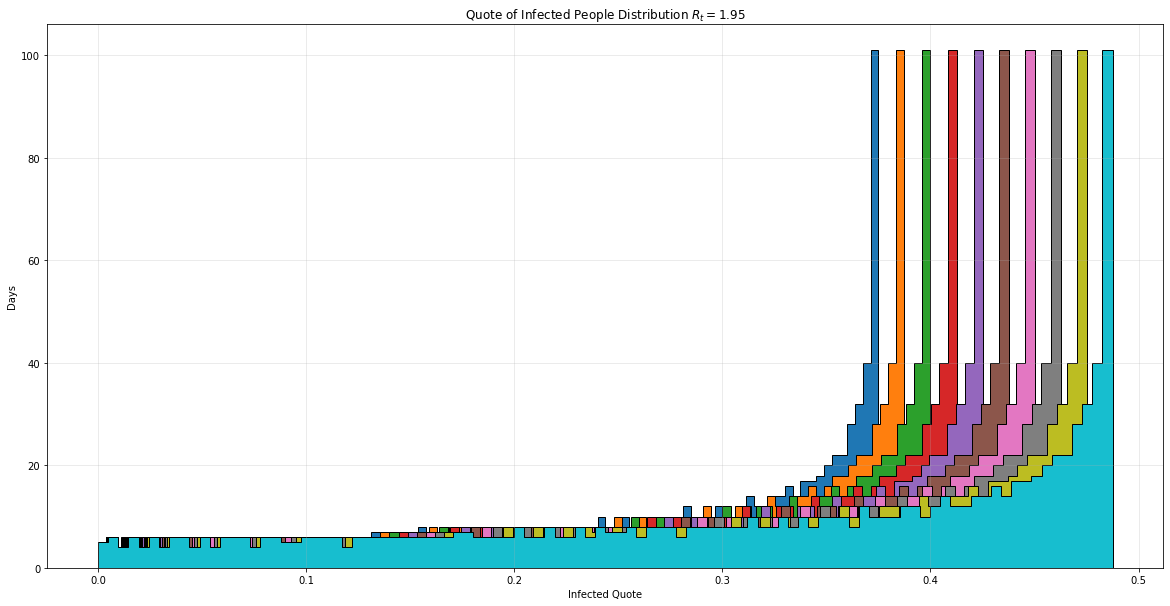

In [36]:
fig, ax = plt.subplots(figsize=(20,10))

for n, cs in enumerate(cases):
    ax.hist(cs, bins=100, histtype = 'stepfilled', edgecolor = 'k')
    _ = ax.grid(alpha=.3)
    _ = ax.set_ylabel('Days')
    _ = ax.set_xlabel('Infected Quote')
    _ = ax.set_title(f'Quote of Infected People Distribution $R_t=${[round(rt,3) for rt in np.arange(1.5,2,.05)][n]}')

#### 3. Bayesian Estimation ####

In [128]:
# Column vector of k
k = np.arange(0, 70)[:, None]

# Different values of Lambda
lambdas = [10, 20, 30, 40]

# Evaluated the Probability Mass Function (remember: poisson is discrete)
y = ss.poisson.pmf(k, lambdas)

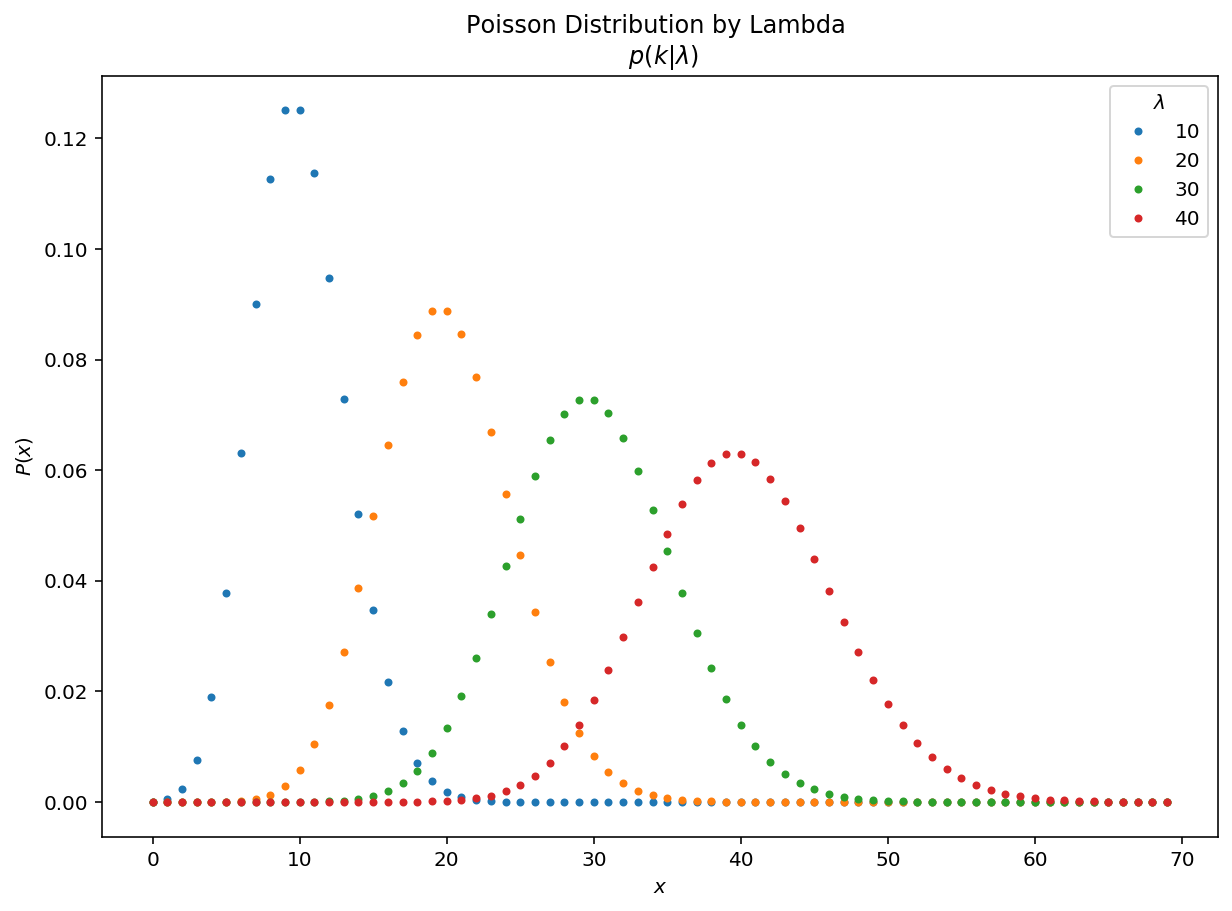

In [129]:
fig, ax = plt.subplots(figsize=(10,7))

ax.plot(k, y, marker='o', markersize=3,lw=0)
_ = ax.legend(title="$\lambda$", labels=lambdas)
_ = ax.set_ylabel('$P(x)$')
_ = ax.set_xlabel('$x$')
_ = ax.set_title('Poisson Distribution by Lambda \n $p(k|\lambda)$')

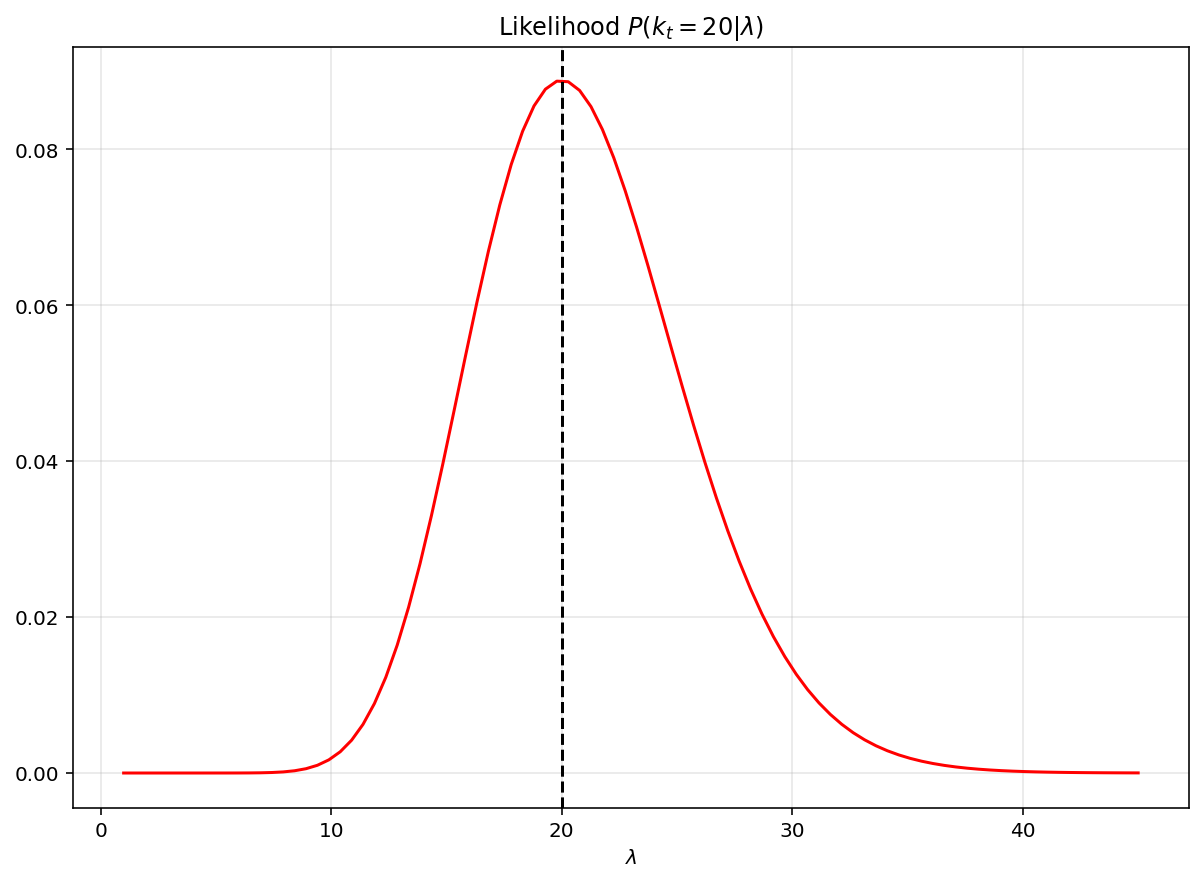

In [130]:
# plotting the likelihood function. Note: we assume, for example, 20 cases (k = 20)

k = 20
lambdas = np.linspace(1, 45, 90)
likelihood = pd.DataFrame({'Likelihood':ss.poisson.pmf(k, lambdas), 'Lambdas':lambdas}).set_index('Lambdas')
_ = likelihood.plot(title=r'Likelihood $P\left(k_t=20|\lambda\right)$', figsize=(10,7), legend = False, c = 'r')
_ = plt.xlabel('$\lambda$')
_ = plt.grid(alpha=.3)
_ = plt.axvline(20, linestyle = '--', c = 'k')

So we can see that the maximum likelihood corresponds to 20, as we expected assuming $k = 20$.

The derivation of the connection between $\lambda$ and $R_{t}$ can be found on Battencourt and Riberio (2008). The resulting equation is:

$$\lambda=k_{t-1}e^{\gamma(R_{t}-1)}$$

Since we know every new case count on the previous day, we can now reformulate the likelihood function as a Poisson parameterized by fixing $k$ and varying $R_t$. 

$$P(k|R_{t})=\frac{\lambda^{k}e^{-\lambda}}{k!}$$

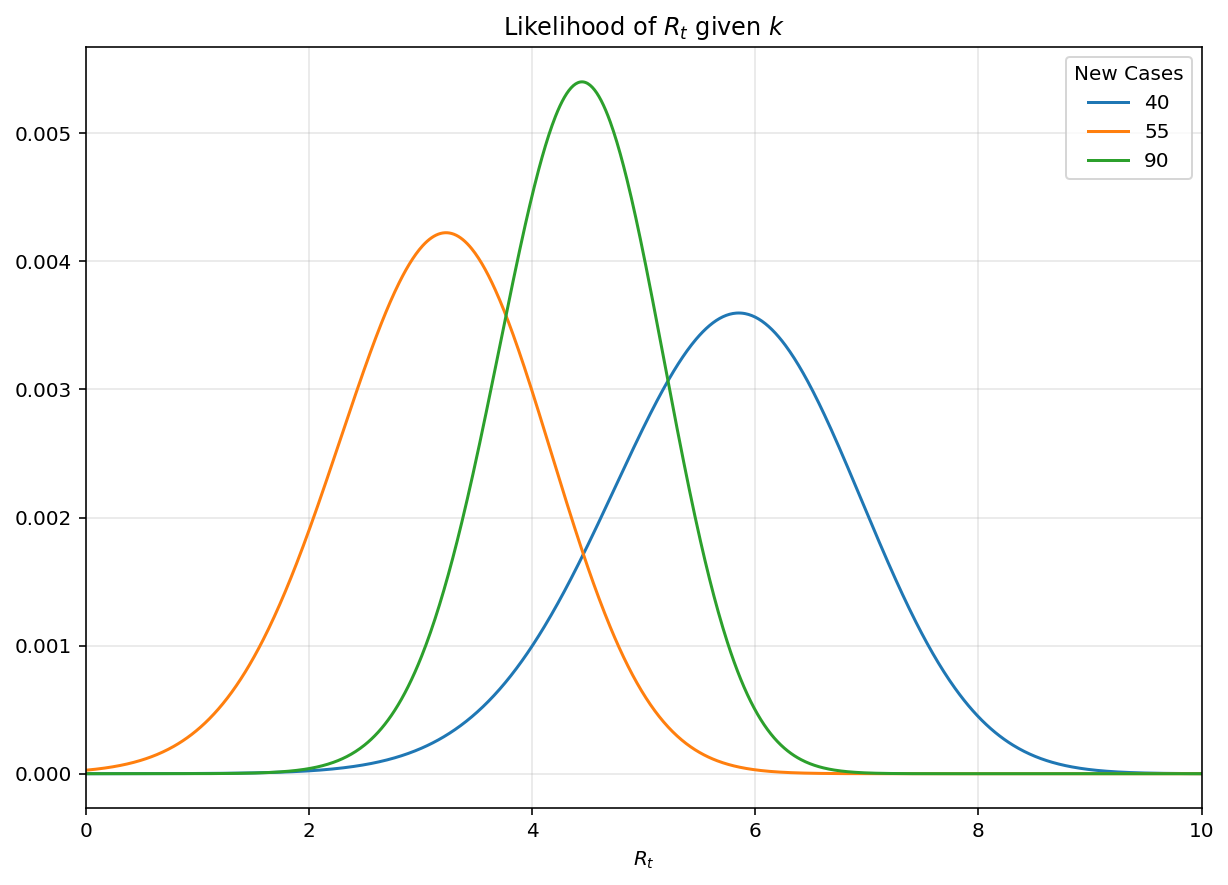

In [131]:
k = np.array([20, 40, 55, 90])

# We create an array for every possible value of Rt
R_T_MAX = 12
r_t_range = np.linspace(0, R_T_MAX, R_T_MAX*100+1)

# Gamma is 1/serial interval
# https://wwwnc.cdc.gov/eid/article/26/7/20-0282_article
# https://www.nejm.org/doi/full/10.1056/NEJMoa2001316
GAMMA = 1/7

# Map Rt into lambda so we can substitute it into the equation below
# Note that we have N-1 lambdas because on the first day of an outbreak
# you do not know what to expect.
lam = k[:-1] * np.exp(GAMMA * (r_t_range.reshape(-1,1) - 1))

# Evaluate the likelihood on each day and normalize sum of each day to 1.0
likelihood_r_t = ss.poisson.pmf(k[1:], lam)
likelihood_r_t /= np.sum(likelihood_r_t, axis=0)

fig, ax = plt.subplots(figsize=(10,7))

pd.DataFrame(data = likelihood_r_t, index = r_t_range).plot(ax = ax, title = 'Likelihood of $R_t$ given $k$', xlim = (0,10))
_ = ax.legend(labels=k[1:], title='New Cases')
_ = ax.set_xlabel('$R_t$')
_ = ax.grid(alpha=.3)

##### Bayesian Update #####

Here we just use the bayes rule to update our posteriors. To do this, we just multiply the likelihood with his previous value (the prior).

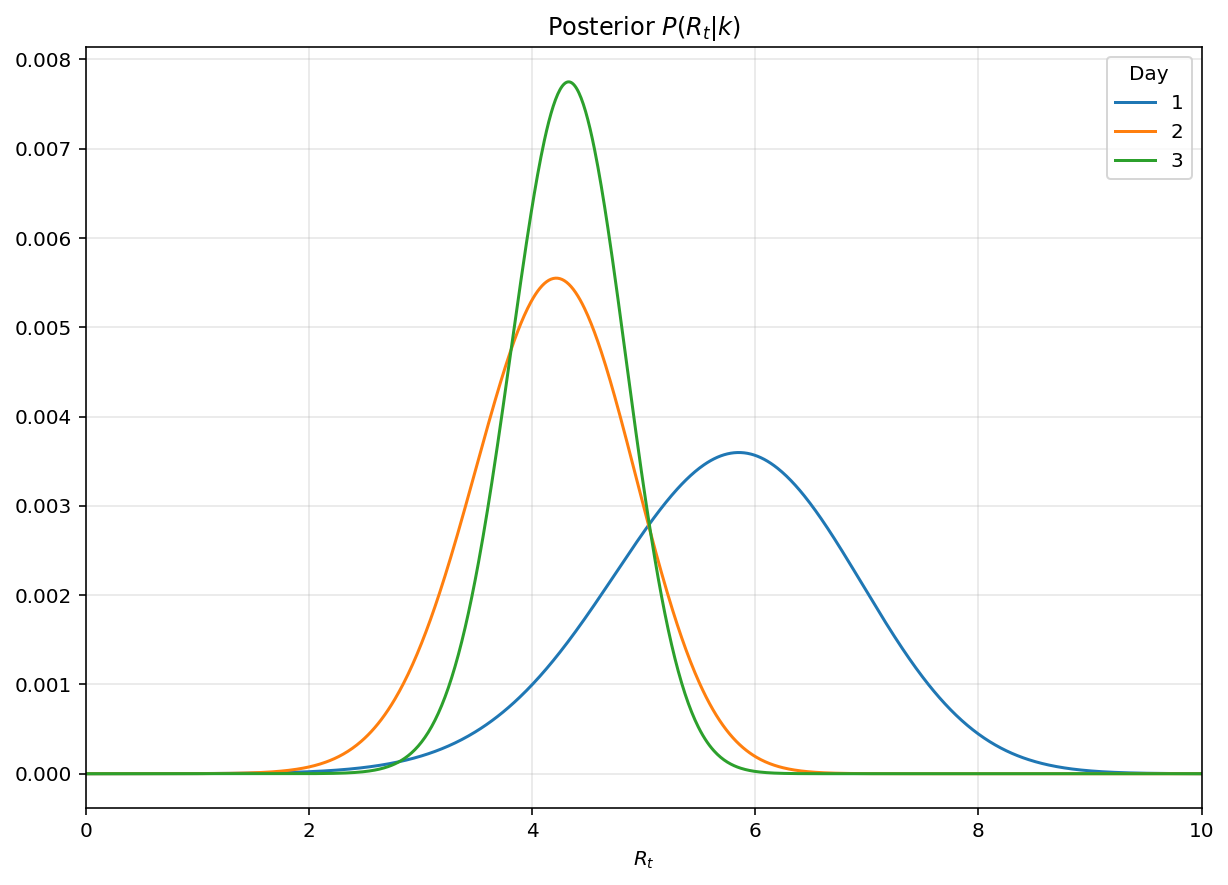

In [132]:
posteriors = likelihood_r_t.cumprod(axis=1) # Bayes Rule
posteriors /= np.sum(posteriors, axis=0) # scaling

columns = pd.Index(range(1, posteriors.shape[1]+1), name='Day')
posteriors = pd.DataFrame(data = posteriors, index = r_t_range, columns = columns)

fig, ax = plt.subplots(figsize=(10,7))

posteriors.plot(ax = ax, title='Posterior $P(R_t|k)$', xlim=(0,10))
_ = ax.legend(title='Day')
_ = ax.set_xlabel('$R_t$')
_ = ax.grid(alpha = .3)

In [133]:
most_likely_values = posteriors.idxmax(axis=0)
most_likely_values

Day
1    5.85
2    4.22
3    4.33
dtype: float64

In [98]:
def highest_density_interval(pmf, p=.9, debug=False):
    # If we pass a DataFrame, just call this recursively on the columns
    if(isinstance(pmf, pd.DataFrame)):
        return pd.DataFrame([highest_density_interval(pmf[col], p=p) for col in pmf],
                            index=pmf.columns)
    
    cumsum = np.cumsum(pmf.values)
    
    # N x N matrix of total probability mass for each low, high
    total_p = cumsum - cumsum.reshape(-1,1)
    
    # Return all indices with total_p > p
    lows, highs = (total_p > p).nonzero()
    
    # Find the smallest range (highest density)
    best = (highs - lows).argmin()
    
    low = pmf.index[lows[best]]
    high = pmf.index[highs[best]]
    
    return pd.Series([low, high],
                     index=[f'Low_{p*100:.0f}',
                            f'High_{p*100:.0f}'])

hdi = highest_density_interval(posteriors, debug=True)
hdi.tail()

Low_90  High_90
Day                 
1      3.89     7.55
2      2.96     5.33
3      3.42     5.12

In [134]:
cumsum = np.cumsum(posteriors.values)
    
# N x N matrix of total probability mass for each low, high
total_p = cumsum - cumsum[:, None]

In [150]:
(total_p > .9).nonzero()

(array([   0,    0,    0, ..., 1526, 1526, 1526], dtype=int64),
 array([1240, 1241, 1242, ..., 3600, 3601, 3602], dtype=int64))

In [154]:
total_p[0]

array([0.00000000e+00, 3.63145877e-09, 3.63146060e-09, ...,
       2.99999992e+00, 2.99999992e+00, 2.99999992e+00])

In [152]:
cumsum

array([7.50289985e-08, 7.86604573e-08, 7.86604591e-08, ...,
       3.00000000e+00, 3.00000000e+00, 3.00000000e+00])

In [153]:
cumsum[:, None]

array([[7.50289985e-08],
       [7.86604573e-08],
       [7.86604591e-08],
       ...,
       [3.00000000e+00],
       [3.00000000e+00],
       [3.00000000e+00]])

In [156]:
cumsum[2] -  cumsum[:, None][0]

array([3.6314606e-09])